In [1]:
#importing libraries

import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import sys
from zipfile import ZipFile
from sklearn.preprocessing import scale
from sklearn import preprocessing
import random
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

C:\Users\karna\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. Load the data

In [2]:
#Reading the Local Energy Schedules

LE = h5py.File("C:\\Users\\karna\\Downloads\\GC12-LES.hdf5", 'r')

# List all groups
print(list(LE.keys()))

# Get the data
dataLE = LE['LocalEnergySchedules']

#append the keys
ke=[]

for key in dataLE.keys():
    ke.append(key)

['LocalEnergySchedules']


In [3]:
#Reading the Thermal histories

TH = h5py.File("C:\\Users\karna\\Downloads\\GC12-TH.hdf5", 'r')

# List all groups
print(list(TH.keys()))

# Get the data
dataTH = TH['ThermalHistories']

#append the keys
ke2=[]

for key in dataTH.keys():
    ke2.append(key)

['ThermalHistories']


In [4]:
#check if indices match
print(ke == ke2)

True


In [5]:
#Load the energy and the thermal history data into corresponding lists
Local_Energy_Schedules = []

for key in ke:
    Local_Energy_Schedules.append(dataLE[key])
        
Thermal_Histories=[]
    
for key in ke2:
    Thermal_Histories.append(dataTH[key])

# 2. Exploratory Analysis

### 2.1 Sample plots

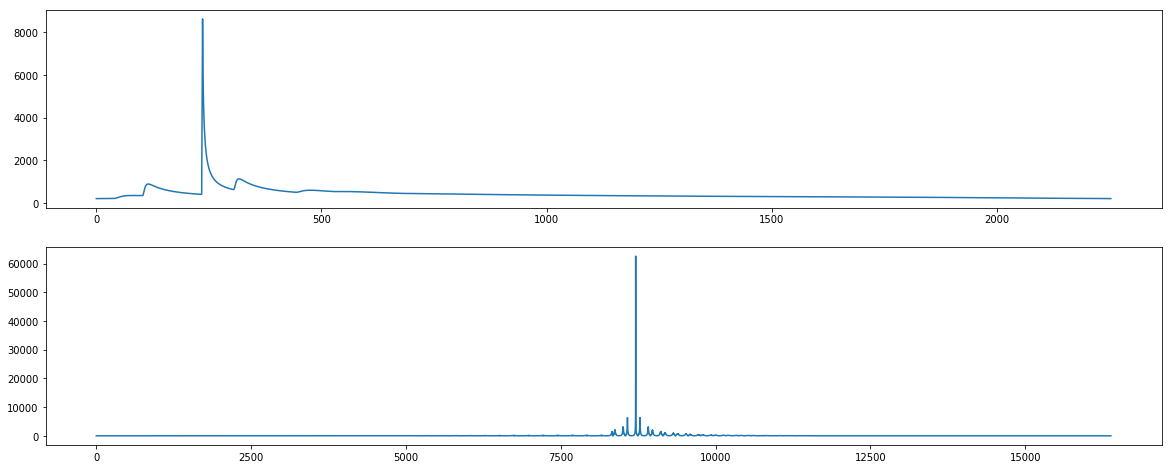

In [6]:
a = pd.Series(Thermal_Histories[1000])
b = pd.Series(Local_Energy_Schedules[1000])

fig,ax = plt.subplots()
fig.set_size_inches(20,8)

plt.subplot(2,1,1)
plt.plot(a)

plt.subplot(2,1,2)
plt.plot(b)

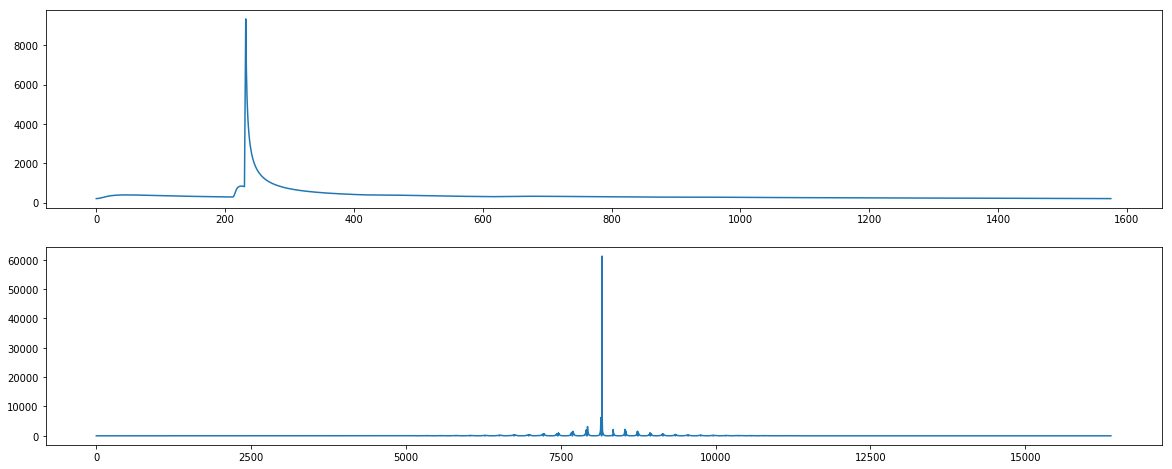

In [7]:
a = pd.Series(Thermal_Histories[100])
b = pd.Series(Local_Energy_Schedules[100])

fig,ax = plt.subplots()
fig.set_size_inches(20,8)

plt.subplot(2,1,1)
plt.plot(a)

plt.subplot(2,1,2)
plt.plot(b)

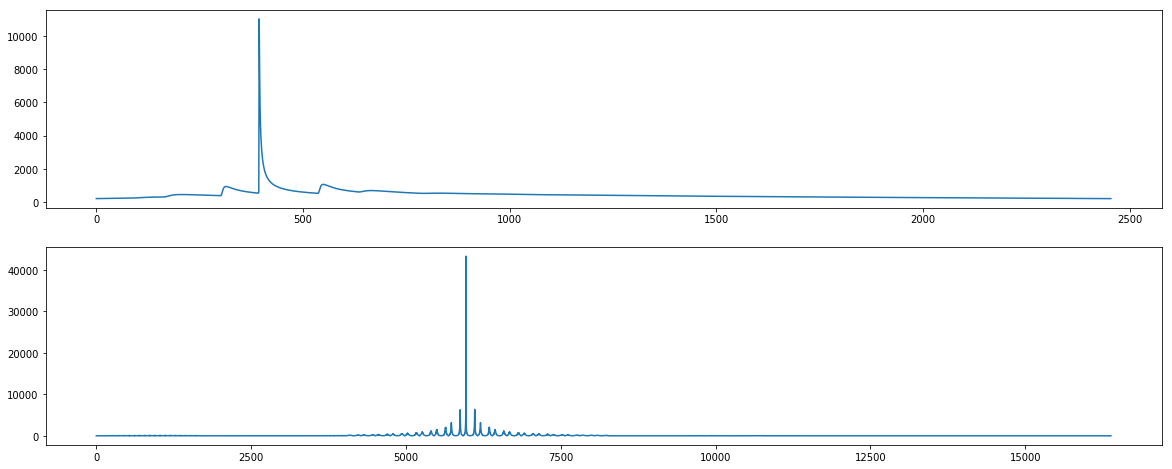

In [8]:
a = pd.Series(Thermal_Histories[1010])
b = pd.Series(Local_Energy_Schedules[1010])

fig,ax = plt.subplots()
fig.set_size_inches(20,8)

plt.subplot(2,1,1)
plt.plot(a)

plt.subplot(2,1,2)
plt.plot(b)

### 2.2 Overlap the peaks and adjust the indices accordingly

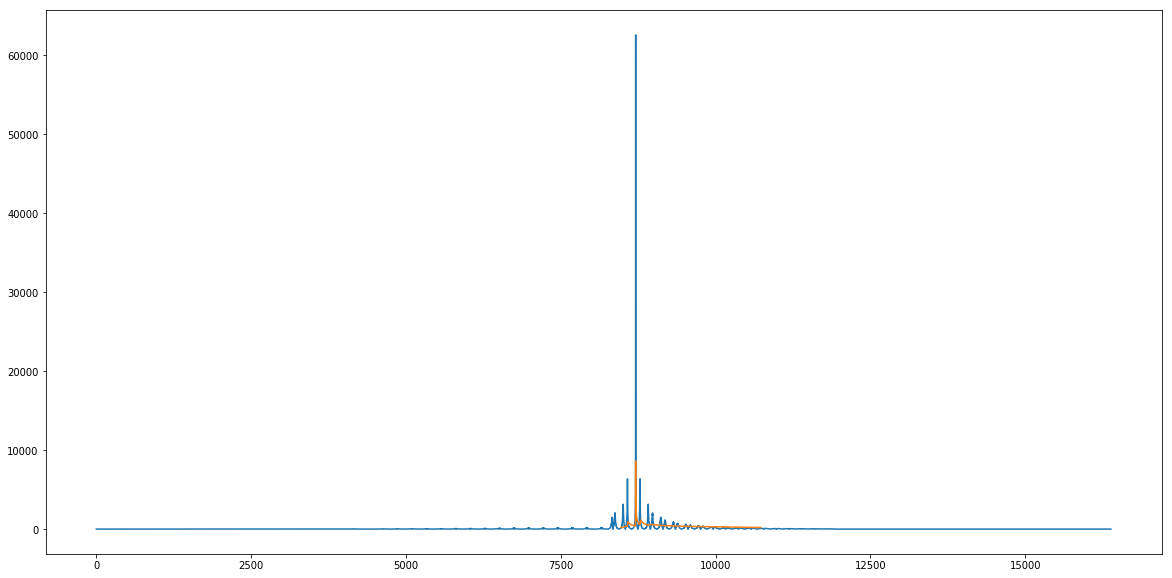

In [9]:
a = pd.Series(Thermal_Histories[1000])
b = pd.Series(Local_Energy_Schedules[1000])


from scipy import signal

fig,ax = plt.subplots()
fig.set_size_inches(20,10)
plt.plot(b.index.values, b)
dx = np.mean(np.diff(b.index.values))
    
shift = (np.argmax(signal.correlate(b, a))-len(a))*dx
plt.plot(a.index.values + shift , a)

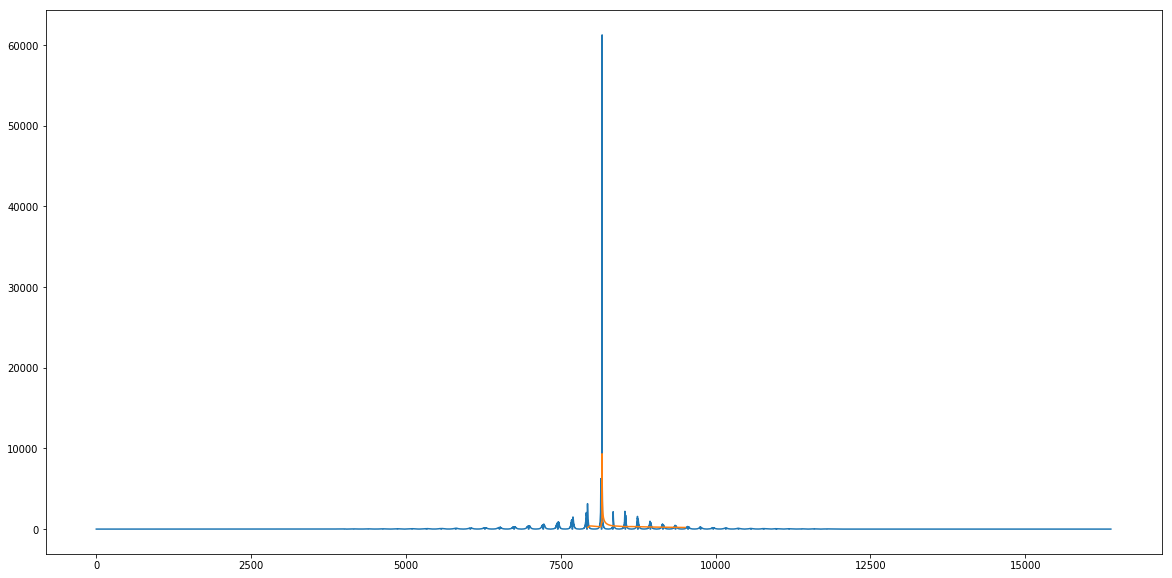

In [10]:
a = pd.Series(Thermal_Histories[100])
b = pd.Series(Local_Energy_Schedules[100])

from scipy import signal

fig,ax = plt.subplots()
fig.set_size_inches(20,10)
plt.plot(b.index.values, b)
dx = np.mean(np.diff(b.index.values))
    
shift = (np.argmax(signal.correlate(b, a))-len(a))*dx
plt.plot(a.index.values  + shift, a)

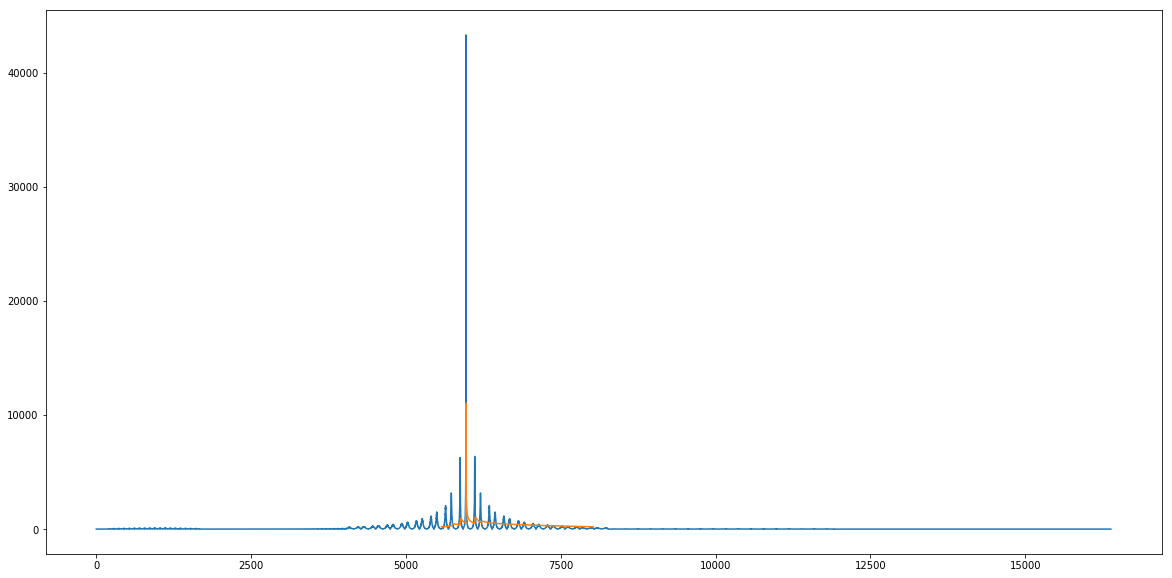

In [11]:
b = pd.Series(Local_Energy_Schedules[1010])
a = pd.Series(Thermal_Histories[1010])

from scipy import signal

fig,ax = plt.subplots()
fig.set_size_inches(20,10)
plt.plot(b.index.values, b)
dx = np.mean(np.diff(b.index.values))
    
shift = (np.argmax(signal.correlate(b, a))-len(a))*dx
plt.plot(a.index.values + shift , a)

In [12]:
# Reindex the thermal histories accordingly

for i in range(0,len(Local_Energy_Schedules)):
    Local_Energy_Schedules[i] = pd.Series(Local_Energy_Schedules[i])
    Thermal_Histories[i] = pd.Series(Thermal_Histories[i])

for i in range(0,len(Thermal_Histories)):
    
    dx = np.mean(np.diff(Local_Energy_Schedules[i].index.values))
    
    shift = (np.argmax(signal.correlate(Local_Energy_Schedules[i], Thermal_Histories[i]))-len(Thermal_Histories[i]))*dx
    Thermal_Histories[i].index = Thermal_Histories[i].index.values + int(shift)

### 2.3 Fill in missing values

In [13]:
max_len = max([len(i) for i in Thermal_Histories])
min_len = min([len(i) for i in Thermal_Histories])
print("min and max length of Thermal Histories", min_len, max_len)

max_len = max([len(i) for i in Local_Energy_Schedules])
min_len = min([len(i) for i in Local_Energy_Schedules])
print("min and max length of Local Energy Schedules", min_len, max_len)

min and max length of Thermal Histories 716 8579
min and max length of Local Energy Schedules 16384 16384


In [14]:
# Fill in the missing thermal values with 100 after matching the peaks of the energy schedules and their corresponding thermal histories

# create an array of 100s to the max length of energy schedules 
Y_array = np.zeros([len(Thermal_Histories),max(Local_Energy_Schedules,key = lambda x: len(x)).index[-1]+1])+100

for i,j in enumerate(Thermal_Histories):
    Y_array[i][j.index[0]:j.index[-1]+1] = j
    
print(Y_array.shape)

(6579, 16384)


In [15]:
# remove negative indices

for i,j in enumerate(Thermal_Histories):
    m = j.index[0]
    while (m < 0):
        Thermal_Histories[i] = Thermal_Histories[i].drop(index=m)
        m+=1

### 2.4 Check out some of the plots

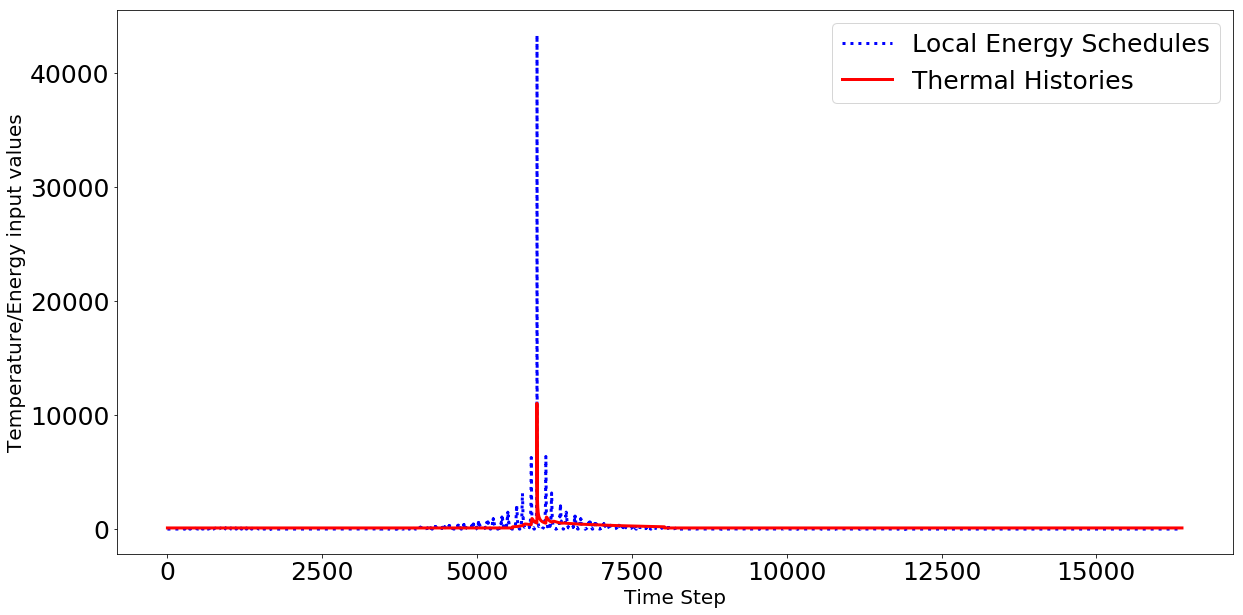

In [16]:
a = pd.Series(Y_array[1010])
b = pd.Series(Local_Energy_Schedules[1010])

np.argmax(signal.correlate(b, a))

fig,ax = plt.subplots()
fig.set_size_inches(20,10)


ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)

plt.plot(b,linestyle=':',c='b',linewidth=3)
plt.plot(a,c='r',linewidth=3)
plt.xlabel("Time Step",fontsize=20)
plt.ylabel("Temperature/Energy input values",fontsize=20)
plt.legend(labels=("Local Energy Schedules","Thermal Histories"),fontsize=25)

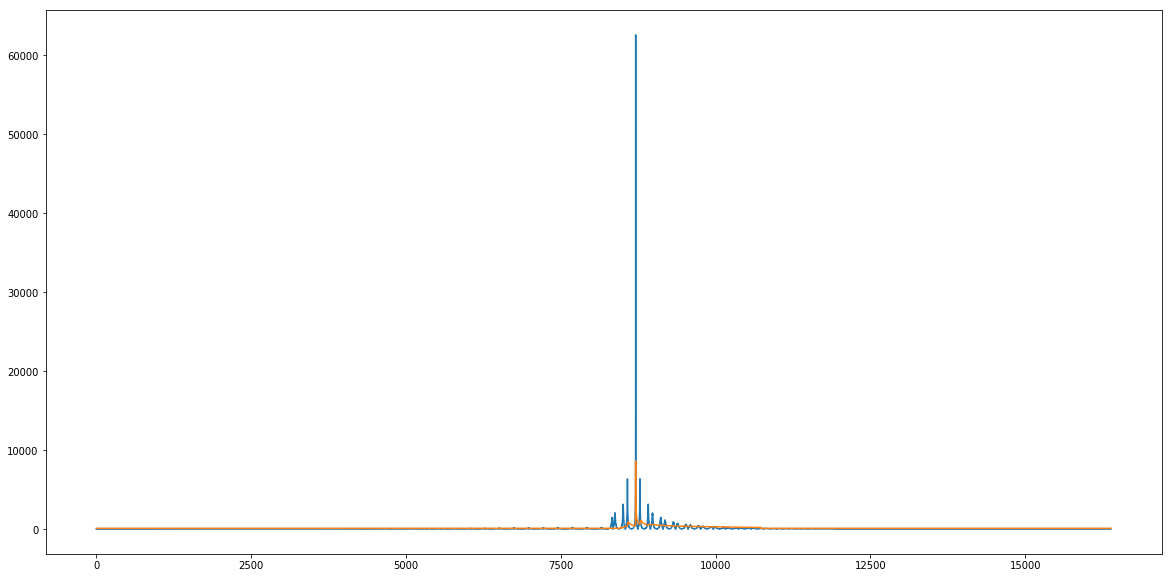

In [17]:
a = pd.Series(Y_array[1000])
b = pd.Series(Local_Energy_Schedules[1000])

np.argmax(signal.correlate(b, a))

fig,ax = plt.subplots()
fig.set_size_inches(20,10)

plt.plot(b)
plt.plot(a)

In [18]:
# Store the local energy schedules into an array

X_array = np.zeros([len(Local_Energy_Schedules),max(Local_Energy_Schedules,key = lambda x: len(x)).index[-1]+1])

for i,j in enumerate(Local_Energy_Schedules):
    X_array[i][0:len(j)] = j
        

In [19]:
X_array.shape

(6579, 16384)

# 3. Granger causality test

In [69]:
# check for stationarity

from statsmodels.tsa.stattools import adfuller

count = 0
not_stationary = []

for i in range(len(Thermal_Histories)):
    if (adfuller(Thermal_Histories[i], maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)[1])<=0.05:
        count+=1
    else:
        not_stationary.append(i)

In [70]:
#check how many are stationary

print(round((count/len(Thermal_Histories))*100,2),'%')

99.85 %


In [71]:
# Granger causality test

from sklearn import preprocessing
from statsmodels.tsa.stattools import grangercausalitytests
count = 0
ind = []
for i in range(0,len(Thermal_Histories)):
    t1 = Local_Energy_Schedules[i]
    t2 = Thermal_Histories[i]
    x = pd.concat([t1,t2],axis=1)
    x = x.dropna()
    if (grangercausalitytests(x,maxlag=1)[1][0]['lrtest'][1]) <=0.05:
        count+=1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=618.3228, p=0.0000  , df_denom=1781, df_num=1
ssr based chi2 test:   chi2=619.3644, p=0.0000  , df=1
likelihood ratio test: chi2=531.6526, p=0.0000  , df=1
parameter F test:         F=618.3228, p=0.0000  , df_denom=1781, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=486.9672, p=0.0000  , df_denom=2287, df_num=1
ssr based chi2 test:   chi2=487.6060, p=0.0000  , df=1
likelihood ratio test: chi2=442.0561, p=0.0000  , df=1
parameter F test:         F=486.9672, p=0.0000  , df_denom=2287, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=894.6192, p=0.0000  , df_denom=2424, df_num=1
ssr based chi2 test:   chi2=895.7264, p=0.0000  , df=1
likelihood ratio test: chi2=762.3928, p=0.0000  , df=1
parameter F test:         F=894.6192, p=0.0000  , df_denom=2424, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=906.7431, p=0.

ssr based F test:         F=721.6808, p=0.0000  , df_denom=2142, df_num=1
ssr based chi2 test:   chi2=722.6916, p=0.0000  , df=1
likelihood ratio test: chi2=622.8390, p=0.0000  , df=1
parameter F test:         F=721.6808, p=0.0000  , df_denom=2142, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1013.0950, p=0.0000  , df_denom=2395, df_num=1
ssr based chi2 test:   chi2=1014.3640, p=0.0000  , df=1
likelihood ratio test: chi2=845.9430, p=0.0000  , df=1
parameter F test:         F=1013.0950, p=0.0000  , df_denom=2395, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=569.6738, p=0.0000  , df_denom=2077, df_num=1
ssr based chi2 test:   chi2=570.4966, p=0.0000  , df=1
likelihood ratio test: chi2=504.1486, p=0.0000  , df=1
parameter F test:         F=569.6738, p=0.0000  , df_denom=2077, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=625.2993, p=0.0000  , df_denom=1785, df_num=1
ssr based c


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=905.5871, p=0.0000  , df_denom=2173, df_num=1
ssr based chi2 test:   chi2=906.8373, p=0.0000  , df=1
likelihood ratio test: chi2=758.0358, p=0.0000  , df=1
parameter F test:         F=905.5871, p=0.0000  , df_denom=2173, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=609.6303, p=0.0000  , df_denom=1761, df_num=1
ssr based chi2 test:   chi2=610.6689, p=0.0000  , df=1
likelihood ratio test: chi2=524.3914, p=0.0000  , df=1
parameter F test:         F=609.6303, p=0.0000  , df_denom=1761, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=841.8082, p=0.0000  , df_denom=2319, df_num=1
ssr based chi2 test:   chi2=842.8972, p=0.0000  , df=1
likelihood ratio test: chi2=719.1041, p=0.0000  , df=1
parameter F test:         F=841.8082, p=0.0000  , df_denom=2319, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=879.9580, p=0.

ssr based F test:         F=668.8763, p=0.0000  , df_denom=2176, df_num=1
ssr based chi2 test:   chi2=669.7985, p=0.0000  , df=1
likelihood ratio test: chi2=584.0401, p=0.0000  , df=1
parameter F test:         F=668.8763, p=0.0000  , df_denom=2176, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1215.0487, p=0.0000  , df_denom=2377, df_num=1
ssr based chi2 test:   chi2=1216.5822, p=0.0000  , df=1
likelihood ratio test: chi2=982.6628, p=0.0000  , df=1
parameter F test:         F=1215.0487, p=0.0000  , df_denom=2377, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=652.8228, p=0.0000  , df_denom=2308, df_num=1
ssr based chi2 test:   chi2=653.6714, p=0.0000  , df=1
likelihood ratio test: chi2=575.6374, p=0.0000  , df=1
parameter F test:         F=652.8228, p=0.0000  , df_denom=2308, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=616.1283, p=0.0000  , df_denom=2004, df_num=1
ssr based c

parameter F test:         F=521.1872, p=0.0000  , df_denom=2282, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=506.1603, p=0.0000  , df_denom=1762, df_num=1
ssr based chi2 test:   chi2=507.0221, p=0.0000  , df=1
likelihood ratio test: chi2=445.6970, p=0.0000  , df=1
parameter F test:         F=506.1603, p=0.0000  , df_denom=1762, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=656.2040, p=0.0000  , df_denom=2170, df_num=1
ssr based chi2 test:   chi2=657.1112, p=0.0000  , df=1
likelihood ratio test: chi2=574.1224, p=0.0000  , df=1
parameter F test:         F=656.2040, p=0.0000  , df_denom=2170, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1432.2260, p=0.0000  , df_denom=1677, df_num=1
ssr based chi2 test:   chi2=1434.7881, p=0.0000  , df=1
likelihood ratio test: chi2=1037.1771, p=0.0000  , df=1
parameter F test:         F=1432.2260, p=0.0000  , df_denom=1677, df_num=1

Granger C

ssr based F test:         F=750.0756, p=0.0000  , df_denom=2337, df_num=1
ssr based chi2 test:   chi2=751.0385, p=0.0000  , df=1
likelihood ratio test: chi2=651.3535, p=0.0000  , df=1
parameter F test:         F=750.0756, p=0.0000  , df_denom=2337, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=842.6484, p=0.0000  , df_denom=2212, df_num=1
ssr based chi2 test:   chi2=843.7913, p=0.0000  , df=1
likelihood ratio test: chi2=714.9298, p=0.0000  , df=1
parameter F test:         F=842.6484, p=0.0000  , df_denom=2212, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=809.6960, p=0.0000  , df_denom=2317, df_num=1
ssr based chi2 test:   chi2=810.7443, p=0.0000  , df=1
likelihood ratio test: chi2=695.3124, p=0.0000  , df=1
parameter F test:         F=809.6960, p=0.0000  , df_denom=2317, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=741.7574, p=0.0000  , df_denom=1819, df_num=1
ssr based chi2

ssr based F test:         F=550.0241, p=0.0000  , df_denom=1654, df_num=1
ssr based chi2 test:   chi2=551.0217, p=0.0000  , df=1
likelihood ratio test: chi2=475.7052, p=0.0000  , df=1
parameter F test:         F=550.0241, p=0.0000  , df_denom=1654, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=929.4186, p=0.0000  , df_denom=2345, df_num=1
ssr based chi2 test:   chi2=930.6076, p=0.0000  , df=1
likelihood ratio test: chi2=783.8914, p=0.0000  , df=1
parameter F test:         F=929.4186, p=0.0000  , df_denom=2345, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=593.6018, p=0.0000  , df_denom=2457, df_num=1
ssr based chi2 test:   chi2=594.3266, p=0.0000  , df=1
likelihood ratio test: chi2=532.3386, p=0.0000  , df=1
parameter F test:         F=593.6018, p=0.0000  , df_denom=2457, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=912.5285, p=0.0000  , df_denom=2400, df_num=1
ssr based chi2

ssr based F test:         F=705.6729, p=0.0000  , df_denom=2179, df_num=1
ssr based chi2 test:   chi2=706.6445, p=0.0000  , df=1
likelihood ratio test: chi2=612.1502, p=0.0000  , df=1
parameter F test:         F=705.6729, p=0.0000  , df_denom=2179, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=584.0300, p=0.0000  , df_denom=1925, df_num=1
ssr based chi2 test:   chi2=584.9402, p=0.0000  , df=1
likelihood ratio test: chi2=510.8627, p=0.0000  , df=1
parameter F test:         F=584.0300, p=0.0000  , df_denom=1925, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=533.3434, p=0.0000  , df_denom=1991, df_num=1
ssr based chi2 test:   chi2=534.1471, p=0.0000  , df=1
likelihood ratio test: chi2=473.2639, p=0.0000  , df=1
parameter F test:         F=533.3434, p=0.0000  , df_denom=1991, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=785.0251, p=0.0000  , df_denom=1558, df_num=1
ssr based chi2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=670.8570, p=0.0000  , df_denom=1784, df_num=1
ssr based chi2 test:   chi2=671.9851, p=0.0000  , df=1
likelihood ratio test: chi2=570.4291, p=0.0000  , df=1
parameter F test:         F=670.8570, p=0.0000  , df_denom=1784, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=643.5702, p=0.0000  , df_denom=1739, df_num=1
ssr based chi2 test:   chi2=644.6804, p=0.0000  , df=1
likelihood ratio test: chi2=548.5028, p=0.0000  , df=1
parameter F test:         F=643.5702, p=0.0000  , df_denom=1739, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=663.1935, p=0.0000  , df_denom=1774, df_num=1
ssr based chi2 test:   chi2=664.3150, p=0.0000  , df=1
likelihood ratio test: chi2=564.3935, p=0.0000  , df=1
parameter F test:         F=663.1935, p=0.0000  , df_denom=1774, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=764.9013, p=0.

parameter F test:         F=545.6603, p=0.0000  , df_denom=1738, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=904.8192, p=0.0000  , df_denom=1936, df_num=1
ssr based chi2 test:   chi2=906.2213, p=0.0000  , df=1
likelihood ratio test: chi2=743.5454, p=0.0000  , df=1
parameter F test:         F=904.8192, p=0.0000  , df_denom=1936, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=562.7448, p=0.0000  , df_denom=2163, df_num=1
ssr based chi2 test:   chi2=563.5253, p=0.0000  , df=1
likelihood ratio test: chi2=500.8779, p=0.0000  , df=1
parameter F test:         F=562.7448, p=0.0000  , df_denom=2163, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=765.2784, p=0.0000  , df_denom=1881, df_num=1
ssr based chi2 test:   chi2=766.4989, p=0.0000  , df=1
likelihood ratio test: chi2=643.1047, p=0.0000  , df=1
parameter F test:         F=765.2784, p=0.0000  , df_denom=1881, df_num=1

Granger Causa

likelihood ratio test: chi2=1826.2350, p=0.0000  , df=1
parameter F test:         F=2087.4154, p=0.0000  , df_denom=6955, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=483.0958, p=0.0000  , df_denom=2269, df_num=1
ssr based chi2 test:   chi2=483.7346, p=0.0000  , df=1
likelihood ratio test: chi2=438.5495, p=0.0000  , df=1
parameter F test:         F=483.0958, p=0.0000  , df_denom=2269, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=685.3292, p=0.0000  , df_denom=1853, df_num=1
ssr based chi2 test:   chi2=686.4388, p=0.0000  , df=1
likelihood ratio test: chi2=584.0835, p=0.0000  , df=1
parameter F test:         F=685.3292, p=0.0000  , df_denom=1853, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=665.9390, p=0.0000  , df_denom=1971, df_num=1
ssr based chi2 test:   chi2=666.9526, p=0.0000  , df=1
likelihood ratio test: chi2=574.5875, p=0.0000  , df=1
parameter F test:         F=665

parameter F test:         F=1119.0419, p=0.0000  , df_denom=2315, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=448.5338, p=0.0000  , df_denom=1786, df_num=1
ssr based chi2 test:   chi2=449.2872, p=0.0000  , df=1
likelihood ratio test: chi2=400.8328, p=0.0000  , df=1
parameter F test:         F=448.5338, p=0.0000  , df_denom=1786, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=575.7111, p=0.0000  , df_denom=2301, df_num=1
ssr based chi2 test:   chi2=576.4617, p=0.0000  , df=1
likelihood ratio test: chi2=514.4921, p=0.0000  , df=1
parameter F test:         F=575.7111, p=0.0000  , df_denom=2301, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=722.3112, p=0.0000  , df_denom=1636, df_num=1
ssr based chi2 test:   chi2=723.6358, p=0.0000  , df=1
likelihood ratio test: chi2=599.3684, p=0.0000  , df=1
parameter F test:         F=722.3112, p=0.0000  , df_denom=1636, df_num=1

Granger Caus

ssr based F test:         F=635.4474, p=0.0000  , df_denom=1731, df_num=1
ssr based chi2 test:   chi2=636.5487, p=0.0000  , df=1
likelihood ratio test: chi2=542.2054, p=0.0000  , df=1
parameter F test:         F=635.4474, p=0.0000  , df_denom=1731, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=841.3846, p=0.0000  , df_denom=2125, df_num=1
ssr based chi2 test:   chi2=842.5724, p=0.0000  , df=1
likelihood ratio test: chi2=709.8414, p=0.0000  , df=1
parameter F test:         F=841.3846, p=0.0000  , df_denom=2125, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=732.8718, p=0.0000  , df_denom=1687, df_num=1
ssr based chi2 test:   chi2=734.1750, p=0.0000  , df=1
likelihood ratio test: chi2=609.6890, p=0.0000  , df=1
parameter F test:         F=732.8718, p=0.0000  , df_denom=1687, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=502.5267, p=0.0000  , df_denom=2006, df_num=1
ssr based chi2

likelihood ratio test: chi2=617.3855, p=0.0000  , df=1
parameter F test:         F=713.3269, p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1151.9333, p=0.0000  , df_denom=2437, df_num=1
ssr based chi2 test:   chi2=1153.3513, p=0.0000  , df=1
likelihood ratio test: chi2=944.4929, p=0.0000  , df=1
parameter F test:         F=1151.9333, p=0.0000  , df_denom=2437, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=600.8478, p=0.0000  , df_denom=1796, df_num=1
ssr based chi2 test:   chi2=601.8514, p=0.0000  , df=1
likelihood ratio test: chi2=519.1779, p=0.0000  , df=1
parameter F test:         F=600.8478, p=0.0000  , df_denom=1796, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=455.4469, p=0.0000  , df_denom=2140, df_num=1
ssr based chi2 test:   chi2=456.0854, p=0.0000  , df=1
likelihood ratio test: chi2=413.4980, p=0.0000  , df=1
parameter F test:         F=45


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=763.8814, p=0.0000  , df_denom=1861, df_num=1
ssr based chi2 test:   chi2=765.1128, p=0.0000  , df=1
likelihood ratio test: chi2=641.0701, p=0.0000  , df=1
parameter F test:         F=763.8814, p=0.0000  , df_denom=1861, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=591.9209, p=0.0000  , df_denom=2170, df_num=1
ssr based chi2 test:   chi2=592.7392, p=0.0000  , df=1
likelihood ratio test: chi2=524.1259, p=0.0000  , df=1
parameter F test:         F=591.9209, p=0.0000  , df_denom=2170, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=712.9928, p=0.0000  , df_denom=2170, df_num=1
ssr based chi2 test:   chi2=713.9786, p=0.0000  , df=1
likelihood ratio test: chi2=617.3531, p=0.0000  , df=1
parameter F test:         F=712.9928, p=0.0000  , df_denom=2170, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=871.1546, p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=669.5141, p=0.0000  , df_denom=2430, df_num=1
ssr based chi2 test:   chi2=670.3406, p=0.0000  , df=1
likelihood ratio test: chi2=592.0805, p=0.0000  , df=1
parameter F test:         F=669.5141, p=0.0000  , df_denom=2430, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=862.6032, p=0.0000  , df_denom=1783, df_num=1
ssr based chi2 test:   chi2=864.0546, p=0.0000  , df=1
likelihood ratio test: chi2=704.7587, p=0.0000  , df=1
parameter F test:         F=862.6032, p=0.0000  , df_denom=1783, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=610.7453, p=0.0000  , df_denom=1436, df_num=1
ssr based chi2 test:   chi2=612.0212, p=0.0000  , df=1
likelihood ratio test: chi2=509.9663, p=0.0000  , df=1
parameter F test:         F=610.7453, p=0.0000  , df_denom=1436, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=791.1269, p=0.

ssr based F test:         F=434.0175, p=0.0000  , df_denom=1760, df_num=1
ssr based chi2 test:   chi2=434.7573, p=0.0000  , df=1
likelihood ratio test: chi2=388.6014, p=0.0000  , df=1
parameter F test:         F=434.0175, p=0.0000  , df_denom=1760, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=534.4093, p=0.0000  , df_denom=1860, df_num=1
ssr based chi2 test:   chi2=535.2712, p=0.0000  , df=1
likelihood ratio test: chi2=470.5194, p=0.0000  , df=1
parameter F test:         F=534.4093, p=0.0000  , df_denom=1860, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1151.9943, p=0.0000  , df_denom=1620, df_num=1
ssr based chi2 test:   chi2=1154.1276, p=0.0000  , df=1
likelihood ratio test: chi2=871.7796, p=0.0000  , df=1
parameter F test:         F=1151.9943, p=0.0000  , df_denom=1620, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=614.2104, p=0.0000  , df_denom=2348, df_num=1
ssr based c

likelihood ratio test: chi2=685.7071, p=0.0000  , df=1
parameter F test:         F=774.8212, p=0.0000  , df_denom=2835, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=873.0957, p=0.0000  , df_denom=2412, df_num=1
ssr based chi2 test:   chi2=874.1817, p=0.0000  , df=1
likelihood ratio test: chi2=746.0889, p=0.0000  , df=1
parameter F test:         F=873.0957, p=0.0000  , df_denom=2412, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=748.9331, p=0.0000  , df_denom=1779, df_num=1
ssr based chi2 test:   chi2=750.1961, p=0.0000  , df=1
likelihood ratio test: chi2=626.1068, p=0.0000  , df=1
parameter F test:         F=748.9331, p=0.0000  , df_denom=1779, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=515.2015, p=0.0000  , df_denom=2140, df_num=1
ssr based chi2 test:   chi2=515.9237, p=0.0000  , df=1
likelihood ratio test: chi2=462.2766, p=0.0000  , df=1
parameter F test:         F=515.2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=999.4129, p=0.0000  , df_denom=2396, df_num=1
ssr based chi2 test:   chi2=1000.6643, p=0.0000  , df=1
likelihood ratio test: chi2=836.3506, p=0.0000  , df=1
parameter F test:         F=999.4129, p=0.0000  , df_denom=2396, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=706.7528, p=0.0000  , df_denom=2385, df_num=1
ssr based chi2 test:   chi2=707.6418, p=0.0000  , df=1
likelihood ratio test: chi2=619.7793, p=0.0000  , df=1
parameter F test:         F=706.7528, p=0.0000  , df_denom=2385, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=541.8848, p=0.0000  , df_denom=2151, df_num=1
ssr based chi2 test:   chi2=542.6406, p=0.0000  , df=1
likelihood ratio test: chi2=483.9611, p=0.0000  , df=1
parameter F test:         F=541.8848, p=0.0000  , df_denom=2151, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=855.2842, p=0

ssr based chi2 test:   chi2=1108.4622, p=0.0000  , df=1
likelihood ratio test: chi2=904.8460, p=0.0000  , df=1
parameter F test:         F=1107.0177, p=0.0000  , df_denom=2299, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=472.7119, p=0.0000  , df_denom=2317, df_num=1
ssr based chi2 test:   chi2=473.3240, p=0.0000  , df=1
likelihood ratio test: chi2=430.7430, p=0.0000  , df=1
parameter F test:         F=472.7119, p=0.0000  , df_denom=2317, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=809.6162, p=0.0000  , df_denom=2090, df_num=1
ssr based chi2 test:   chi2=810.7783, p=0.0000  , df=1
likelihood ratio test: chi2=685.2782, p=0.0000  , df=1
parameter F test:         F=809.6162, p=0.0000  , df_denom=2090, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=596.3973, p=0.0000  , df_denom=1912, df_num=1
ssr based chi2 test:   chi2=597.3331, p=0.0000  , df=1
likelihood ratio test: chi2=519

ssr based F test:         F=549.6748, p=0.0000  , df_denom=1724, df_num=1
ssr based chi2 test:   chi2=550.6314, p=0.0000  , df=1
likelihood ratio test: chi2=477.9476, p=0.0000  , df=1
parameter F test:         F=549.6748, p=0.0000  , df_denom=1724, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=523.2061, p=0.0000  , df_denom=2279, df_num=1
ssr based chi2 test:   chi2=523.8948, p=0.0000  , df=1
likelihood ratio test: chi2=471.6215, p=0.0000  , df=1
parameter F test:         F=523.2061, p=0.0000  , df_denom=2279, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=633.7278, p=0.0000  , df_denom=1731, df_num=1
ssr based chi2 test:   chi2=634.8262, p=0.0000  , df=1
likelihood ratio test: chi2=540.9450, p=0.0000  , df=1
parameter F test:         F=633.7278, p=0.0000  , df_denom=1731, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=836.6240, p=0.0000  , df_denom=2456, df_num=1
ssr based chi2

ssr based F test:         F=681.3036, p=0.0000  , df_denom=1568, df_num=1
ssr based chi2 test:   chi2=682.6071, p=0.0000  , df=1
likelihood ratio test: chi2=566.8478, p=0.0000  , df=1
parameter F test:         F=681.3036, p=0.0000  , df_denom=1568, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=478.4667, p=0.0000  , df_denom=2312, df_num=1
ssr based chi2 test:   chi2=479.0875, p=0.0000  , df=1
likelihood ratio test: chi2=435.4420, p=0.0000  , df=1
parameter F test:         F=478.4667, p=0.0000  , df_denom=2312, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=968.0117, p=0.0000  , df_denom=2438, df_num=1
ssr based chi2 test:   chi2=969.2028, p=0.0000  , df=1
likelihood ratio test: chi2=816.1825, p=0.0000  , df=1
parameter F test:         F=968.0117, p=0.0000  , df_denom=2438, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=671.5109, p=0.0000  , df_denom=2400, df_num=1
ssr based chi2

parameter F test:         F=643.7430, p=0.0000  , df_denom=1717, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=853.9374, p=0.0000  , df_denom=2324, df_num=1
ssr based chi2 test:   chi2=855.0397, p=0.0000  , df=1
likelihood ratio test: chi2=728.2173, p=0.0000  , df=1
parameter F test:         F=853.9374, p=0.0000  , df_denom=2324, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=641.0867, p=0.0000  , df_denom=2223, df_num=1
ssr based chi2 test:   chi2=641.9518, p=0.0000  , df=1
likelihood ratio test: chi2=564.0503, p=0.0000  , df=1
parameter F test:         F=641.0867, p=0.0000  , df_denom=2223, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=952.8460, p=0.0000  , df_denom=1791, df_num=1
ssr based chi2 test:   chi2=954.4421, p=0.0000  , df=1
likelihood ratio test: chi2=765.2961, p=0.0000  , df=1
parameter F test:         F=952.8460, p=0.0000  , df_denom=1791, df_num=1

Granger Causa

ssr based F test:         F=747.4512, p=0.0000  , df_denom=1771, df_num=1
ssr based chi2 test:   chi2=748.7174, p=0.0000  , df=1
likelihood ratio test: chi2=624.6250, p=0.0000  , df=1
parameter F test:         F=747.4512, p=0.0000  , df_denom=1771, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=489.2462, p=0.0000  , df_denom=1737, df_num=1
ssr based chi2 test:   chi2=490.0912, p=0.0000  , df=1
likelihood ratio test: chi2=431.7938, p=0.0000  , df=1
parameter F test:         F=489.2462, p=0.0000  , df_denom=1737, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=667.5760, p=0.0000  , df_denom=2207, df_num=1
ssr based chi2 test:   chi2=668.4834, p=0.0000  , df=1
likelihood ratio test: chi2=584.0390, p=0.0000  , df=1
parameter F test:         F=667.5760, p=0.0000  , df_denom=2207, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=791.0056, p=0.0000  , df_denom=1531, df_num=1
ssr based chi2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=922.9080, p=0.0000  , df_denom=2426, df_num=1
ssr based chi2 test:   chi2=924.0493, p=0.0000  , df=1
likelihood ratio test: chi2=783.0866, p=0.0000  , df=1
parameter F test:         F=922.9080, p=0.0000  , df_denom=2426, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=601.2975, p=0.0000  , df_denom=1155, df_num=1
ssr based chi2 test:   chi2=602.8593, p=0.0000  , df=1
likelihood ratio test: chi2=485.3265, p=0.0000  , df=1
parameter F test:         F=601.2975, p=0.0000  , df_denom=1155, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=931.8692, p=0.0000  , df_denom=2111, df_num=1
ssr based chi2 test:   chi2=933.1935, p=0.0000  , df=1
likelihood ratio test: chi2=772.9611, p=0.0000  , df=1
parameter F test:         F=931.8692, p=0.0000  , df_denom=2111, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=968.7419, p=0.

ssr based F test:         F=926.4328, p=0.0000  , df_denom=1824, df_num=1
ssr based chi2 test:   chi2=927.9566, p=0.0000  , df=1
likelihood ratio test: chi2=750.3971, p=0.0000  , df=1
parameter F test:         F=926.4328, p=0.0000  , df_denom=1824, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=978.5027, p=0.0000  , df_denom=2148, df_num=1
ssr based chi2 test:   chi2=979.8693, p=0.0000  , df=1
likelihood ratio test: chi2=807.4377, p=0.0000  , df=1
parameter F test:         F=978.5027, p=0.0000  , df_denom=2148, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=795.2542, p=0.0000  , df_denom=1711, df_num=1
ssr based chi2 test:   chi2=796.6486, p=0.0000  , df=1
likelihood ratio test: chi2=654.2532, p=0.0000  , df=1
parameter F test:         F=795.2542, p=0.0000  , df_denom=1711, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=716.7659, p=0.0000  , df_denom=1849, df_num=1
ssr based chi2

parameter F test:         F=748.8334, p=0.0000  , df_denom=1866, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=686.6972, p=0.0000  , df_denom=2163, df_num=1
ssr based chi2 test:   chi2=687.6497, p=0.0000  , df=1
likelihood ratio test: chi2=597.2022, p=0.0000  , df=1
parameter F test:         F=686.6972, p=0.0000  , df_denom=2163, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=398.5984, p=0.0000  , df_denom=1754, df_num=1
ssr based chi2 test:   chi2=399.2801, p=0.0000  , df=1
likelihood ratio test: chi2=359.7928, p=0.0000  , df=1
parameter F test:         F=398.5984, p=0.0000  , df_denom=1754, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=788.4973, p=0.0000  , df_denom=1676, df_num=1
ssr based chi2 test:   chi2=789.9087, p=0.0000  , df=1
likelihood ratio test: chi2=647.3852, p=0.0000  , df=1
parameter F test:         F=788.4973, p=0.0000  , df_denom=1676, df_num=1

Granger Causa

ssr based F test:         F=2359.0350, p=0.0000  , df_denom=4631, df_num=1
ssr based chi2 test:   chi2=2360.5632, p=0.0000  , df=1
likelihood ratio test: chi2=1907.8768, p=0.0000  , df=1
parameter F test:         F=2359.0350, p=0.0000  , df_denom=4631, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=375.3208, p=0.0000  , df_denom=1853, df_num=1
ssr based chi2 test:   chi2=375.9284, p=0.0000  , df=1
likelihood ratio test: chi2=342.3250, p=0.0000  , df=1
parameter F test:         F=375.3208, p=0.0000  , df_denom=1853, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2381.8134, p=0.0000  , df_denom=7523, df_num=1
ssr based chi2 test:   chi2=2382.7632, p=0.0000  , df=1
likelihood ratio test: chi2=2070.0703, p=0.0000  , df=1
parameter F test:         F=2381.8134, p=0.0000  , df_denom=7523, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=829.9135, p=0.0000  , df_denom=1471, df_num=1
ssr ba

likelihood ratio test: chi2=569.8527, p=0.0000  , df=1
parameter F test:         F=666.1134, p=0.0000  , df_denom=1850, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=586.2861, p=0.0000  , df_denom=2167, df_num=1
ssr based chi2 test:   chi2=587.0978, p=0.0000  , df=1
likelihood ratio test: chi2=519.6096, p=0.0000  , df=1
parameter F test:         F=586.2861, p=0.0000  , df_denom=2167, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=476.9129, p=0.0000  , df_denom=1691, df_num=1
ssr based chi2 test:   chi2=477.7590, p=0.0000  , df=1
likelihood ratio test: chi2=420.8655, p=0.0000  , df=1
parameter F test:         F=476.9129, p=0.0000  , df_denom=1691, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=622.7219, p=0.0000  , df_denom=1897, df_num=1
ssr based chi2 test:   chi2=623.7067, p=0.0000  , df=1
likelihood ratio test: chi2=539.3622, p=0.0000  , df=1
parameter F test:         F=622.7

likelihood ratio test: chi2=519.4037, p=0.0000  , df=1
parameter F test:         F=581.1000, p=0.0000  , df_denom=2327, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=596.9009, p=0.0000  , df_denom=1257, df_num=1
ssr based chi2 test:   chi2=598.3255, p=0.0000  , df=1
likelihood ratio test: chi2=489.5907, p=0.0000  , df=1
parameter F test:         F=596.9009, p=0.0000  , df_denom=1257, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1524.4571, p=0.0000  , df_denom=5749, df_num=1
ssr based chi2 test:   chi2=1525.2526, p=0.0000  , df=1
likelihood ratio test: chi2=1352.9036, p=0.0000  , df=1
parameter F test:         F=1524.4571, p=0.0000  , df_denom=5749, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=761.1158, p=0.0000  , df_denom=2446, df_num=1
ssr based chi2 test:   chi2=762.0493, p=0.0000  , df=1
likelihood ratio test: chi2=663.4782, p=0.0000  , df=1
parameter F test:         F=7


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2235.9689, p=0.0000  , df_denom=6516, df_num=1
ssr based chi2 test:   chi2=2236.9983, p=0.0000  , df=1
likelihood ratio test: chi2=1923.2223, p=0.0000  , df=1
parameter F test:         F=2235.9689, p=0.0000  , df_denom=6516, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=681.6324, p=0.0000  , df_denom=2230, df_num=1
ssr based chi2 test:   chi2=682.5494, p=0.0000  , df=1
likelihood ratio test: chi2=595.5686, p=0.0000  , df=1
parameter F test:         F=681.6324, p=0.0000  , df_denom=2230, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1191.7661, p=0.0000  , df_denom=3772, df_num=1
ssr based chi2 test:   chi2=1192.7140, p=0.0000  , df=1
likelihood ratio test: chi2=1036.4617, p=0.0000  , df=1
parameter F test:         F=1191.7661, p=0.0000  , df_denom=3772, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=729.34


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=571.7015, p=0.0000  , df_denom=2086, df_num=1
ssr based chi2 test:   chi2=572.5237, p=0.0000  , df=1
likelihood ratio test: chi2=505.9836, p=0.0000  , df=1
parameter F test:         F=571.7015, p=0.0000  , df_denom=2086, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2193.0641, p=0.0000  , df_denom=8004, df_num=1
ssr based chi2 test:   chi2=2193.8861, p=0.0000  , df=1
likelihood ratio test: chi2=1938.9625, p=0.0000  , df=1
parameter F test:         F=2193.0641, p=0.0000  , df_denom=8004, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=670.3718, p=0.0000  , df_denom=2108, df_num=1
ssr based chi2 test:   chi2=671.3258, p=0.0000  , df=1
likelihood ratio test: chi2=582.9008, p=0.0000  , df=1
parameter F test:         F=670.3718, p=0.0000  , df_denom=2108, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=532.5504, 

likelihood ratio test: chi2=581.3708, p=0.0000  , df=1
parameter F test:         F=656.4348, p=0.0000  , df_denom=2414, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=917.0976, p=0.0000  , df_denom=1676, df_num=1
ssr based chi2 test:   chi2=918.7392, p=0.0000  , df=1
likelihood ratio test: chi2=732.7881, p=0.0000  , df=1
parameter F test:         F=917.0976, p=0.0000  , df_denom=1676, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=516.0828, p=0.0000  , df_denom=1330, df_num=1
ssr based chi2 test:   chi2=517.2469, p=0.0000  , df=1
likelihood ratio test: chi2=437.0734, p=0.0000  , df=1
parameter F test:         F=516.0828, p=0.0000  , df_denom=1330, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=313.3113, p=0.0000  , df_denom=2325, df_num=1
ssr based chi2 test:   chi2=313.7155, p=0.0000  , df=1
likelihood ratio test: chi2=294.3034, p=0.0000  , df=1
parameter F test:         F=313.3

ssr based F test:         F=521.7815, p=0.0000  , df_denom=2297, df_num=1
ssr based chi2 test:   chi2=522.4629, p=0.0000  , df=1
likelihood ratio test: chi2=470.8118, p=0.0000  , df=1
parameter F test:         F=521.7815, p=0.0000  , df_denom=2297, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=646.4667, p=0.0000  , df_denom=1759, df_num=1
ssr based chi2 test:   chi2=647.5693, p=0.0000  , df=1
likelihood ratio test: chi2=551.5033, p=0.0000  , df=1
parameter F test:         F=646.4667, p=0.0000  , df_denom=1759, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=670.3213, p=0.0000  , df_denom=1807, df_num=1
ssr based chi2 test:   chi2=671.4342, p=0.0000  , df=1
likelihood ratio test: chi2=571.0728, p=0.0000  , df=1
parameter F test:         F=670.3213, p=0.0000  , df_denom=1807, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=548.2363, p=0.0000  , df_denom=1911, df_num=1
ssr based chi2

ssr based chi2 test:   chi2=452.5918, p=0.0000  , df=1
likelihood ratio test: chi2=413.8892, p=0.0000  , df=1
parameter F test:         F=452.0138, p=0.0000  , df_denom=2346, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=847.4519, p=0.0000  , df_denom=1773, df_num=1
ssr based chi2 test:   chi2=848.8859, p=0.0000  , df=1
likelihood ratio test: chi2=693.8366, p=0.0000  , df=1
parameter F test:         F=847.4519, p=0.0000  , df_denom=1773, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=954.7783, p=0.0000  , df_denom=2041, df_num=1
ssr based chi2 test:   chi2=956.1817, p=0.0000  , df=1
likelihood ratio test: chi2=784.4140, p=0.0000  , df=1
parameter F test:         F=954.7783, p=0.0000  , df_denom=2041, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=816.2810, p=0.0000  , df_denom=1917, df_num=1
ssr based chi2 test:   chi2=817.5584, p=0.0000  , df=1
likelihood ratio test: chi2=681.1

ssr based F test:         F=693.0361, p=0.0000  , df_denom=2272, df_num=1
ssr based chi2 test:   chi2=693.9512, p=0.0000  , df=1
likelihood ratio test: chi2=605.6703, p=0.0000  , df=1
parameter F test:         F=693.0361, p=0.0000  , df_denom=2272, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=576.2189, p=0.0000  , df_denom=1788, df_num=1
ssr based chi2 test:   chi2=577.1858, p=0.0000  , df=1
likelihood ratio test: chi2=500.3159, p=0.0000  , df=1
parameter F test:         F=576.2189, p=0.0000  , df_denom=1788, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=748.4503, p=0.0000  , df_denom=2433, df_num=1
ssr based chi2 test:   chi2=749.3732, p=0.0000  , df=1
likelihood ratio test: chi2=653.3647, p=0.0000  , df=1
parameter F test:         F=748.4503, p=0.0000  , df_denom=2433, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=504.2063, p=0.0000  , df_denom=2391, df_num=1
ssr based chi2

parameter F test:         F=915.2484, p=0.0000  , df_denom=1871, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=776.0508, p=0.0000  , df_denom=2392, df_num=1
ssr based chi2 test:   chi2=777.0241, p=0.0000  , df=1
likelihood ratio test: chi2=672.9631, p=0.0000  , df=1
parameter F test:         F=776.0508, p=0.0000  , df_denom=2392, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=365.7725, p=0.0000  , df_denom=1481, df_num=1
ssr based chi2 test:   chi2=366.5134, p=0.0000  , df=1
likelihood ratio test: chi2=327.5514, p=0.0000  , df=1
parameter F test:         F=365.7725, p=0.0000  , df_denom=1481, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=800.7976, p=0.0000  , df_denom=1907, df_num=1
ssr based chi2 test:   chi2=802.0574, p=0.0000  , df=1
likelihood ratio test: chi2=669.6542, p=0.0000  , df=1
parameter F test:         F=800.7976, p=0.0000  , df_denom=1907, df_num=1

Granger Causa

ssr based F test:         F=515.9487, p=0.0000  , df_denom=2368, df_num=1
ssr based chi2 test:   chi2=516.6024, p=0.0000  , df=1
likelihood ratio test: chi2=467.3590, p=0.0000  , df=1
parameter F test:         F=515.9487, p=0.0000  , df_denom=2368, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=682.6141, p=0.0000  , df_denom=2399, df_num=1
ssr based chi2 test:   chi2=683.4677, p=0.0000  , df=1
likelihood ratio test: chi2=601.4645, p=0.0000  , df=1
parameter F test:         F=682.6141, p=0.0000  , df_denom=2399, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=943.9474, p=0.0000  , df_denom=1737, df_num=1
ssr based chi2 test:   chi2=945.5777, p=0.0000  , df=1
likelihood ratio test: chi2=755.1787, p=0.0000  , df=1
parameter F test:         F=943.9474, p=0.0000  , df_denom=1737, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=654.9609, p=0.0000  , df_denom=1855, df_num=1
ssr based chi2

ssr based F test:         F=779.7698, p=0.0000  , df_denom=1761, df_num=1
ssr based chi2 test:   chi2=781.0982, p=0.0000  , df=1
likelihood ratio test: chi2=646.6564, p=0.0000  , df=1
parameter F test:         F=779.7698, p=0.0000  , df_denom=1761, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=909.9979, p=0.0000  , df_denom=1875, df_num=1
ssr based chi2 test:   chi2=911.4539, p=0.0000  , df=1
likelihood ratio test: chi2=743.0090, p=0.0000  , df=1
parameter F test:         F=909.9979, p=0.0000  , df_denom=1875, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=547.3621, p=0.0000  , df_denom=2263, df_num=1
ssr based chi2 test:   chi2=548.0877, p=0.0000  , df=1
likelihood ratio test: chi2=490.8654, p=0.0000  , df=1
parameter F test:         F=547.3621, p=0.0000  , df_denom=2263, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=812.6202, p=0.0000  , df_denom=2011, df_num=1
ssr based chi2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=673.1325, p=0.0000  , df_denom=1615, df_num=1
ssr based chi2 test:   chi2=674.3829, p=0.0000  , df=1
likelihood ratio test: chi2=563.7128, p=0.0000  , df=1
parameter F test:         F=673.1325, p=0.0000  , df_denom=1615, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=622.6158, p=0.0000  , df_denom=2439, df_num=1
ssr based chi2 test:   chi2=623.3817, p=0.0000  , df=1
likelihood ratio test: chi2=555.2002, p=0.0000  , df=1
parameter F test:         F=622.6158, p=0.0000  , df_denom=2439, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=836.4347, p=0.0000  , df_denom=1330, df_num=1
ssr based chi2 test:   chi2=838.3214, p=0.0000  , df=1
likelihood ratio test: chi2=650.3759, p=0.0000  , df=1
parameter F test:         F=836.4347, p=0.0000  , df_denom=1330, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1021.6187, p=0


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=707.8239, p=0.0000  , df_denom=2170, df_num=1
ssr based chi2 test:   chi2=708.8025, p=0.0000  , df=1
likelihood ratio test: chi2=613.4537, p=0.0000  , df=1
parameter F test:         F=707.8239, p=0.0000  , df_denom=2170, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=686.8545, p=0.0000  , df_denom=1751, df_num=1
ssr based chi2 test:   chi2=688.0313, p=0.0000  , df=1
likelihood ratio test: chi2=580.4535, p=0.0000  , df=1
parameter F test:         F=686.8545, p=0.0000  , df_denom=1751, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=741.4490, p=0.0000  , df_denom=1915, df_num=1
ssr based chi2 test:   chi2=742.6105, p=0.0000  , df=1
likelihood ratio test: chi2=627.7089, p=0.0000  , df=1
parameter F test:         F=741.4490, p=0.0000  , df_denom=1915, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=574.8524, p=0.

ssr based F test:         F=774.8588, p=0.0000  , df_denom=1775, df_num=1
ssr based chi2 test:   chi2=776.1684, p=0.0000  , df=1
likelihood ratio test: chi2=644.0584, p=0.0000  , df=1
parameter F test:         F=774.8588, p=0.0000  , df_denom=1775, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1556.1965, p=0.0000  , df_denom=8063, df_num=1
ssr based chi2 test:   chi2=1556.7755, p=0.0000  , df=1
likelihood ratio test: chi2=1423.4477, p=0.0000  , df=1
parameter F test:         F=1556.1965, p=0.0000  , df_denom=8063, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=598.7729, p=0.0000  , df_denom=1785, df_num=1
ssr based chi2 test:   chi2=599.7793, p=0.0000  , df=1
likelihood ratio test: chi2=517.2077, p=0.0000  , df=1
parameter F test:         F=598.7729, p=0.0000  , df_denom=1785, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1094.7019, p=0.0000  , df_denom=1637, df_num=1
ssr based

likelihood ratio test: chi2=437.6104, p=0.0000  , df=1
parameter F test:         F=478.3993, p=0.0000  , df_denom=2455, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=720.7633, p=0.0000  , df_denom=2346, df_num=1
ssr based chi2 test:   chi2=721.6850, p=0.0000  , df=1
likelihood ratio test: chi2=629.3228, p=0.0000  , df=1
parameter F test:         F=720.7633, p=0.0000  , df_denom=2346, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1946.9513, p=0.0000  , df_denom=6000, df_num=1
ssr based chi2 test:   chi2=1947.9248, p=0.0000  , df=1
likelihood ratio test: chi2=1687.0165, p=0.0000  , df=1
parameter F test:         F=1946.9513, p=0.0000  , df_denom=6000, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=662.6558, p=0.0000  , df_denom=2005, df_num=1
ssr based chi2 test:   chi2=663.6473, p=0.0000  , df=1
likelihood ratio test: chi2=573.3965, p=0.0000  , df=1
parameter F test:         F=6


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=526.5978, p=0.0000  , df_denom=2179, df_num=1
ssr based chi2 test:   chi2=527.3228, p=0.0000  , df=1
likelihood ratio test: chi2=472.3088, p=0.0000  , df=1
parameter F test:         F=526.5978, p=0.0000  , df_denom=2179, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=488.5163, p=0.0000  , df_denom=1843, df_num=1
ssr based chi2 test:   chi2=489.3115, p=0.0000  , df=1
likelihood ratio test: chi2=434.0392, p=0.0000  , df=1
parameter F test:         F=488.5163, p=0.0000  , df_denom=1843, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=902.2212, p=0.0000  , df_denom=1856, df_num=1
ssr based chi2 test:   chi2=903.6796, p=0.0000  , df=1
likelihood ratio test: chi2=736.4658, p=0.0000  , df=1
parameter F test:         F=902.2212, p=0.0000  , df_denom=1856, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=776.2602, p=0.

ssr based F test:         F=1166.5637, p=0.0000  , df_denom=4796, df_num=1
ssr based chi2 test:   chi2=1167.2934, p=0.0000  , df=1
likelihood ratio test: chi2=1044.8302, p=0.0000  , df=1
parameter F test:         F=1166.5637, p=0.0000  , df_denom=4796, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=518.1421, p=0.0000  , df_denom=2388, df_num=1
ssr based chi2 test:   chi2=518.7931, p=0.0000  , df=1
likelihood ratio test: chi2=469.5213, p=0.0000  , df=1
parameter F test:         F=518.1421, p=0.0000  , df_denom=2388, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=572.3447, p=0.0000  , df_denom=1278, df_num=1
ssr based chi2 test:   chi2=573.6882, p=0.0000  , df=1
likelihood ratio test: chi2=474.0668, p=0.0000  , df=1
parameter F test:         F=572.3447, p=0.0000  , df_denom=1278, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1119.9500, p=0.0000  , df_denom=5063, df_num=1
ssr based

likelihood ratio test: chi2=411.4227, p=0.0000  , df=1
parameter F test:         F=462.8233, p=0.0000  , df_denom=1753, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=930.6800, p=0.0000  , df_denom=1905, df_num=1
ssr based chi2 test:   chi2=932.1457, p=0.0000  , df=1
likelihood ratio test: chi2=759.0020, p=0.0000  , df=1
parameter F test:         F=930.6800, p=0.0000  , df_denom=1905, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1028.5380, p=0.0000  , df_denom=1490, df_num=1
ssr based chi2 test:   chi2=1030.6089, p=0.0000  , df=1
likelihood ratio test: chi2=783.6794, p=0.0000  , df=1
parameter F test:         F=1028.5380, p=0.0000  , df_denom=1490, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=919.7674, p=0.0000  , df_denom=1993, df_num=1
ssr based chi2 test:   chi2=921.1519, p=0.0000  , df=1
likelihood ratio test: chi2=757.4073, p=0.0000  , df=1
parameter F test:         F=91

parameter F test:         F=463.6691, p=0.0000  , df_denom=1771, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=717.8584, p=0.0000  , df_denom=2347, df_num=1
ssr based chi2 test:   chi2=718.7760, p=0.0000  , df=1
likelihood ratio test: chi2=627.1291, p=0.0000  , df=1
parameter F test:         F=717.8584, p=0.0000  , df_denom=2347, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1175.3091, p=0.0000  , df_denom=2346, df_num=1
ssr based chi2 test:   chi2=1176.8121, p=0.0000  , df=1
likelihood ratio test: chi2=953.9784, p=0.0000  , df=1
parameter F test:         F=1175.3091, p=0.0000  , df_denom=2346, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1740.4874, p=0.0000  , df_denom=8111, df_num=1
ssr based chi2 test:   chi2=1741.1312, p=0.0000  , df=1
likelihood ratio test: chi2=1577.3720, p=0.0000  , df=1
parameter F test:         F=1740.4874, p=0.0000  , df_denom=8111, df_num=1

Grange

ssr based F test:         F=845.4322, p=0.0000  , df_denom=1717, df_num=1
ssr based chi2 test:   chi2=846.9094, p=0.0000  , df=1
likelihood ratio test: chi2=688.6507, p=0.0000  , df=1
parameter F test:         F=845.4322, p=0.0000  , df_denom=1717, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=803.5060, p=0.0000  , df_denom=2173, df_num=1
ssr based chi2 test:   chi2=804.6153, p=0.0000  , df=1
likelihood ratio test: chi2=684.6598, p=0.0000  , df=1
parameter F test:         F=803.5060, p=0.0000  , df_denom=2173, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=760.8108, p=0.0000  , df_denom=2313, df_num=1
ssr based chi2 test:   chi2=761.7976, p=0.0000  , df=1
likelihood ratio test: chi2=658.6072, p=0.0000  , df=1
parameter F test:         F=760.8108, p=0.0000  , df_denom=2313, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=602.9917, p=0.0000  , df_denom=2435, df_num=1
ssr based chi2

ssr based F test:         F=891.2086, p=0.0000  , df_denom=2427, df_num=1
ssr based chi2 test:   chi2=892.3102, p=0.0000  , df=1
likelihood ratio test: chi2=760.0290, p=0.0000  , df=1
parameter F test:         F=891.2086, p=0.0000  , df_denom=2427, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1361.0462, p=0.0000  , df_denom=2148, df_num=1
ssr based chi2 test:   chi2=1362.9471, p=0.0000  , df=1
likelihood ratio test: chi2=1055.7260, p=0.0000  , df=1
parameter F test:         F=1361.0462, p=0.0000  , df_denom=2148, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=695.4276, p=0.0000  , df_denom=1332, df_num=1
ssr based chi2 test:   chi2=696.9939, p=0.0000  , df=1
likelihood ratio test: chi2=560.8151, p=0.0000  , df=1
parameter F test:         F=695.4276, p=0.0000  , df_denom=1332, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1093.8414, p=0.0000  , df_denom=2341, df_num=1
ssr based


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1140.6128, p=0.0000  , df_denom=2221, df_num=1
ssr based chi2 test:   chi2=1142.1534, p=0.0000  , df=1
likelihood ratio test: chi2=921.7664, p=0.0000  , df=1
parameter F test:         F=1140.6128, p=0.0000  , df_denom=2221, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=843.9777, p=0.0000  , df_denom=1032, df_num=1
ssr based chi2 test:   chi2=846.4312, p=0.0000  , df=1
likelihood ratio test: chi2=618.5484, p=0.0000  , df=1
parameter F test:         F=843.9777, p=0.0000  , df_denom=1032, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=812.5994, p=0.0000  , df_denom=1898, df_num=1
ssr based chi2 test:   chi2=813.8838, p=0.0000  , df=1
likelihood ratio test: chi2=677.4577, p=0.0000  , df=1
parameter F test:         F=812.5994, p=0.0000  , df_denom=1898, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=760.4870, p

parameter F test:         F=585.8086, p=0.0000  , df_denom=1948, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=966.0832, p=0.0000  , df_denom=2425, df_num=1
ssr based chi2 test:   chi2=967.2783, p=0.0000  , df=1
likelihood ratio test: chi2=814.1518, p=0.0000  , df=1
parameter F test:         F=966.0832, p=0.0000  , df_denom=2425, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=638.9330, p=0.0000  , df_denom=2199, df_num=1
ssr based chi2 test:   chi2=639.8047, p=0.0000  , df=1
likelihood ratio test: chi2=561.6714, p=0.0000  , df=1
parameter F test:         F=638.9330, p=0.0000  , df_denom=2199, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=825.0083, p=0.0000  , df_denom=1820, df_num=1
ssr based chi2 test:   chi2=826.3682, p=0.0000  , df=1
likelihood ratio test: chi2=681.5061, p=0.0000  , df=1
parameter F test:         F=825.0083, p=0.0000  , df_denom=1820, df_num=1

Granger Causa


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=771.9999, p=0.0000  , df_denom=2434, df_num=1
ssr based chi2 test:   chi2=772.9514, p=0.0000  , df=1
likelihood ratio test: chi2=671.3643, p=0.0000  , df=1
parameter F test:         F=771.9999, p=0.0000  , df_denom=2434, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=529.9069, p=0.0000  , df_denom=2345, df_num=1
ssr based chi2 test:   chi2=530.5849, p=0.0000  , df=1
likelihood ratio test: chi2=478.3696, p=0.0000  , df=1
parameter F test:         F=529.9069, p=0.0000  , df_denom=2345, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=561.3610, p=0.0000  , df_denom=2074, df_num=1
ssr based chi2 test:   chi2=562.1730, p=0.0000  , df=1
likelihood ratio test: chi2=497.5268, p=0.0000  , df=1
parameter F test:         F=561.3610, p=0.0000  , df_denom=2074, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1317.2541, p=0

parameter F test:         F=1167.0776, p=0.0000  , df_denom=1466, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=785.8621, p=0.0000  , df_denom=2456, df_num=1
ssr based chi2 test:   chi2=786.8220, p=0.0000  , df=1
likelihood ratio test: chi2=682.6525, p=0.0000  , df=1
parameter F test:         F=785.8621, p=0.0000  , df_denom=2456, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=749.7410, p=0.0000  , df_denom=1670, df_num=1
ssr based chi2 test:   chi2=751.0879, p=0.0000  , df=1
likelihood ratio test: chi2=620.4101, p=0.0000  , df=1
parameter F test:         F=749.7410, p=0.0000  , df_denom=1670, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=972.3253, p=0.0000  , df_denom=1912, df_num=1
ssr based chi2 test:   chi2=973.8509, p=0.0000  , df=1
likelihood ratio test: chi2=787.3354, p=0.0000  , df=1
parameter F test:         F=972.3253, p=0.0000  , df_denom=1912, df_num=1

Granger Caus


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1680.7839, p=0.0000  , df_denom=7538, df_num=1
ssr based chi2 test:   chi2=1681.4528, p=0.0000  , df=1
likelihood ratio test: chi2=1517.8995, p=0.0000  , df=1
parameter F test:         F=1680.7839, p=0.0000  , df_denom=7538, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=767.3434, p=0.0000  , df_denom=2229, df_num=1
ssr based chi2 test:   chi2=768.3762, p=0.0000  , df=1
likelihood ratio test: chi2=660.3141, p=0.0000  , df=1
parameter F test:         F=767.3434, p=0.0000  , df_denom=2229, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=909.3246, p=0.0000  , df_denom=1773, df_num=1
ssr based chi2 test:   chi2=910.8632, p=0.0000  , df=1
likelihood ratio test: chi2=735.2831, p=0.0000  , df=1
parameter F test:         F=909.3246, p=0.0000  , df_denom=1773, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=751.3969, 

likelihood ratio test: chi2=395.6874, p=0.0000  , df=1
parameter F test:         F=440.9193, p=0.0000  , df_denom=1830, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=714.4448, p=0.0000  , df_denom=2286, df_num=1
ssr based chi2 test:   chi2=715.3824, p=0.0000  , df=1
likelihood ratio test: chi2=622.5096, p=0.0000  , df=1
parameter F test:         F=714.4448, p=0.0000  , df_denom=2286, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=763.7441, p=0.0000  , df_denom=1785, df_num=1
ssr based chi2 test:   chi2=765.0277, p=0.0000  , df=1
likelihood ratio test: chi2=636.8540, p=0.0000  , df=1
parameter F test:         F=763.7441, p=0.0000  , df_denom=1785, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3852.4929, p=0.0000  , df_denom=7865, df_num=1
ssr based chi2 test:   chi2=3853.9623, p=0.0000  , df=1
likelihood ratio test: chi2=3136.6593, p=0.0000  , df=1
parameter F test:         F=38


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=588.0132, p=0.0000  , df_denom=1786, df_num=1
ssr based chi2 test:   chi2=589.0009, p=0.0000  , df=1
likelihood ratio test: chi2=509.1554, p=0.0000  , df=1
parameter F test:         F=588.0132, p=0.0000  , df_denom=1786, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=994.4371, p=0.0000  , df_denom=2004, df_num=1
ssr based chi2 test:   chi2=995.9258, p=0.0000  , df=1
likelihood ratio test: chi2=808.7127, p=0.0000  , df=1
parameter F test:         F=994.4371, p=0.0000  , df_denom=2004, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1080.8543, p=0.0000  , df_denom=2299, df_num=1
ssr based chi2 test:   chi2=1082.2648, p=0.0000  , df=1
likelihood ratio test: chi2=887.0950, p=0.0000  , df=1
parameter F test:         F=1080.8543, p=0.0000  , df_denom=2299, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3555.0318, 

ssr based F test:         F=2050.1550, p=0.0000  , df_denom=8312, df_num=1
ssr based chi2 test:   chi2=2050.8950, p=0.0000  , df=1
likelihood ratio test: chi2=1833.1247, p=0.0000  , df=1
parameter F test:         F=2050.1550, p=0.0000  , df_denom=8312, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=592.8284, p=0.0000  , df_denom=2376, df_num=1
ssr based chi2 test:   chi2=593.5769, p=0.0000  , df=1
likelihood ratio test: chi2=529.9199, p=0.0000  , df=1
parameter F test:         F=592.8284, p=0.0000  , df_denom=2376, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=992.4332, p=0.0000  , df_denom=2162, df_num=1
ssr based chi2 test:   chi2=993.8103, p=0.0000  , df=1
likelihood ratio test: chi2=817.8831, p=0.0000  , df=1
parameter F test:         F=992.4332, p=0.0000  , df_denom=2162, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=611.6050, p=0.0000  , df_denom=2341, df_num=1
ssr based 

likelihood ratio test: chi2=766.3578, p=0.0000  , df=1
parameter F test:         F=914.2514, p=0.0000  , df_denom=2214, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=814.8635, p=0.0000  , df_denom=2453, df_num=1
ssr based chi2 test:   chi2=815.8601, p=0.0000  , df=1
likelihood ratio test: chi2=704.4413, p=0.0000  , df=1
parameter F test:         F=814.8635, p=0.0000  , df_denom=2453, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=809.5196, p=0.0000  , df_denom=2343, df_num=1
ssr based chi2 test:   chi2=810.5561, p=0.0000  , df=1
likelihood ratio test: chi2=696.2221, p=0.0000  , df=1
parameter F test:         F=809.5196, p=0.0000  , df_denom=2343, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=912.1007, p=0.0000  , df_denom=1753, df_num=1
ssr based chi2 test:   chi2=913.6616, p=0.0000  , df=1
likelihood ratio test: chi2=735.6117, p=0.0000  , df=1
parameter F test:         F=912.1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=629.9390, p=0.0000  , df_denom=1470, df_num=1
ssr based chi2 test:   chi2=631.2246, p=0.0000  , df=1
likelihood ratio test: chi2=525.3394, p=0.0000  , df=1
parameter F test:         F=629.9390, p=0.0000  , df_denom=1470, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=819.5744, p=0.0000  , df_denom=2396, df_num=1
ssr based chi2 test:   chi2=820.6006, p=0.0000  , df=1
likelihood ratio test: chi2=705.7986, p=0.0000  , df=1
parameter F test:         F=819.5744, p=0.0000  , df_denom=2396, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=659.9263, p=0.0000  , df_denom=2437, df_num=1
ssr based chi2 test:   chi2=660.7387, p=0.0000  , df=1
likelihood ratio test: chi2=584.7273, p=0.0000  , df=1
parameter F test:         F=659.9263, p=0.0000  , df_denom=2437, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=447.9975, p=0.

likelihood ratio test: chi2=783.8810, p=0.0000  , df=1
parameter F test:         F=930.3099, p=0.0000  , df_denom=2332, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=730.8844, p=0.0000  , df_denom=2345, df_num=1
ssr based chi2 test:   chi2=731.8195, p=0.0000  , df=1
likelihood ratio test: chi2=637.0290, p=0.0000  , df=1
parameter F test:         F=730.8844, p=0.0000  , df_denom=2345, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=868.8559, p=0.0000  , df_denom=1878, df_num=1
ssr based chi2 test:   chi2=870.2439, p=0.0000  , df=1
likelihood ratio test: chi2=715.2495, p=0.0000  , df=1
parameter F test:         F=868.8559, p=0.0000  , df_denom=1878, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=653.8349, p=0.0000  , df_denom=1877, df_num=1
ssr based chi2 test:   chi2=654.8800, p=0.0000  , df=1
likelihood ratio test: chi2=561.8841, p=0.0000  , df=1
parameter F test:         F=653.8

parameter F test:         F=2038.0069, p=0.0000  , df_denom=3551, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=502.5079, p=0.0000  , df_denom=2355, df_num=1
ssr based chi2 test:   chi2=503.1480, p=0.0000  , df=1
likelihood ratio test: chi2=456.0588, p=0.0000  , df=1
parameter F test:         F=502.5079, p=0.0000  , df_denom=2355, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=740.7613, p=0.0000  , df_denom=1498, df_num=1
ssr based chi2 test:   chi2=742.2449, p=0.0000  , df=1
likelihood ratio test: chi2=603.0896, p=0.0000  , df=1
parameter F test:         F=740.7613, p=0.0000  , df_denom=1498, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=527.7945, p=0.0000  , df_denom=2212, df_num=1
ssr based chi2 test:   chi2=528.5103, p=0.0000  , df=1
likelihood ratio test: chi2=473.9786, p=0.0000  , df=1
parameter F test:         F=527.7945, p=0.0000  , df_denom=2212, df_num=1

Granger Caus

likelihood ratio test: chi2=579.8065, p=0.0000  , df=1
parameter F test:         F=668.0418, p=0.0000  , df_denom=2070, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=686.5274, p=0.0000  , df_denom=2443, df_num=1
ssr based chi2 test:   chi2=687.3704, p=0.0000  , df=1
likelihood ratio test: chi2=605.7646, p=0.0000  , df=1
parameter F test:         F=686.5274, p=0.0000  , df_denom=2443, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1112.8348, p=0.0000  , df_denom=2326, df_num=1
ssr based chi2 test:   chi2=1114.2701, p=0.0000  , df=1
likelihood ratio test: chi2=910.5985, p=0.0000  , df=1
parameter F test:         F=1112.8348, p=0.0000  , df_denom=2326, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=747.8740, p=0.0000  , df_denom=2335, df_num=1
ssr based chi2 test:   chi2=748.8349, p=0.0000  , df=1
likelihood ratio test: chi2=649.6142, p=0.0000  , df=1
parameter F test:         F=74


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=538.7803, p=0.0000  , df_denom=2382, df_num=1
ssr based chi2 test:   chi2=539.4589, p=0.0000  , df=1
likelihood ratio test: chi2=486.3261, p=0.0000  , df=1
parameter F test:         F=538.7803, p=0.0000  , df_denom=2382, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=795.3885, p=0.0000  , df_denom=1957, df_num=1
ssr based chi2 test:   chi2=796.6078, p=0.0000  , df=1
likelihood ratio test: chi2=668.4705, p=0.0000  , df=1
parameter F test:         F=795.3885, p=0.0000  , df_denom=1957, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=822.9097, p=0.0000  , df_denom=1212, df_num=1
ssr based chi2 test:   chi2=824.9466, p=0.0000  , df=1
likelihood ratio test: chi2=629.5881, p=0.0000  , df=1
parameter F test:         F=822.9097, p=0.0000  , df_denom=1212, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=829.8175, p=0.

ssr based F test:         F=745.9380, p=0.0000  , df_denom=2000, df_num=1
ssr based chi2 test:   chi2=747.0569, p=0.0000  , df=1
likelihood ratio test: chi2=634.9021, p=0.0000  , df=1
parameter F test:         F=745.9380, p=0.0000  , df_denom=2000, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=842.3005, p=0.0000  , df_denom=2008, df_num=1
ssr based chi2 test:   chi2=843.5589, p=0.0000  , df=1
likelihood ratio test: chi2=704.4236, p=0.0000  , df=1
parameter F test:         F=842.3005, p=0.0000  , df_denom=2008, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1498.1668, p=0.0000  , df_denom=2018, df_num=1
ssr based chi2 test:   chi2=1500.3940, p=0.0000  , df=1
likelihood ratio test: chi2=1122.1896, p=0.0000  , df=1
parameter F test:         F=1498.1668, p=0.0000  , df_denom=2018, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=791.2613, p=0.0000  , df_denom=2317, df_num=1
ssr based 

ssr based F test:         F=936.8322, p=0.0000  , df_denom=2345, df_num=1
ssr based chi2 test:   chi2=938.0307, p=0.0000  , df=1
likelihood ratio test: chi2=789.2015, p=0.0000  , df=1
parameter F test:         F=936.8322, p=0.0000  , df_denom=2345, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=557.9388, p=0.0000  , df_denom=1671, df_num=1
ssr based chi2 test:   chi2=558.9405, p=0.0000  , df=1
likelihood ratio test: chi2=482.2850, p=0.0000  , df=1
parameter F test:         F=557.9388, p=0.0000  , df_denom=1671, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1238.6215, p=0.0000  , df_denom=2411, df_num=1
ssr based chi2 test:   chi2=1240.1627, p=0.0000  , df=1
likelihood ratio test: chi2=1000.8006, p=0.0000  , df=1
parameter F test:         F=1238.6215, p=0.0000  , df_denom=2411, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=877.9979, p=0.0000  , df_denom=1734, df_num=1
ssr based 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=747.4097, p=0.0000  , df_denom=1781, df_num=1
ssr based chi2 test:   chi2=748.6686, p=0.0000  , df=1
likelihood ratio test: chi2=625.1413, p=0.0000  , df=1
parameter F test:         F=747.4097, p=0.0000  , df_denom=1781, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=674.1612, p=0.0000  , df_denom=2165, df_num=1
ssr based chi2 test:   chi2=675.0953, p=0.0000  , df=1
likelihood ratio test: chi2=587.7194, p=0.0000  , df=1
parameter F test:         F=674.1612, p=0.0000  , df_denom=2165, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=677.8850, p=0.0000  , df_denom=2122, df_num=1
ssr based chi2 test:   chi2=678.8433, p=0.0000  , df=1
likelihood ratio test: chi2=589.0910, p=0.0000  , df=1
parameter F test:         F=677.8850, p=0.0000  , df_denom=2122, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=783.1903, p=0.

likelihood ratio test: chi2=429.4962, p=0.0000  , df=1
parameter F test:         F=469.3327, p=0.0000  , df_denom=2420, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=913.8596, p=0.0000  , df_denom=2321, df_num=1
ssr based chi2 test:   chi2=915.0408, p=0.0000  , df=1
likelihood ratio test: chi2=771.5387, p=0.0000  , df=1
parameter F test:         F=913.8596, p=0.0000  , df_denom=2321, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1130.5336, p=0.0000  , df_denom=2423, df_num=1
ssr based chi2 test:   chi2=1131.9333, p=0.0000  , df=1
likelihood ratio test: chi2=929.0028, p=0.0000  , df=1
parameter F test:         F=1130.5336, p=0.0000  , df_denom=2423, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=854.9194, p=0.0000  , df_denom=1925, df_num=1
ssr based chi2 test:   chi2=856.2517, p=0.0000  , df=1
likelihood ratio test: chi2=708.5322, p=0.0000  , df=1
parameter F test:         F=85


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1179.3051, p=0.0000  , df_denom=2390, df_num=1
ssr based chi2 test:   chi2=1180.7854, p=0.0000  , df=1
likelihood ratio test: chi2=959.7786, p=0.0000  , df=1
parameter F test:         F=1179.3051, p=0.0000  , df_denom=2390, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=675.2348, p=0.0000  , df_denom=2005, df_num=1
ssr based chi2 test:   chi2=676.2452, p=0.0000  , df=1
likelihood ratio test: chi2=582.8428, p=0.0000  , df=1
parameter F test:         F=675.2348, p=0.0000  , df_denom=2005, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=639.1968, p=0.0000  , df_denom=1849, df_num=1
ssr based chi2 test:   chi2=640.2339, p=0.0000  , df=1
likelihood ratio test: chi2=549.8835, p=0.0000  , df=1
parameter F test:         F=639.1968, p=0.0000  , df_denom=1849, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=550.4064, p

ssr based F test:         F=1103.4194, p=0.0000  , df_denom=2353, df_num=1
ssr based chi2 test:   chi2=1104.8262, p=0.0000  , df=1
likelihood ratio test: chi2=905.9812, p=0.0000  , df=1
parameter F test:         F=1103.4194, p=0.0000  , df_denom=2353, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=527.7835, p=0.0000  , df_denom=2230, df_num=1
ssr based chi2 test:   chi2=528.4935, p=0.0000  , df=1
likelihood ratio test: chi2=474.3466, p=0.0000  , df=1
parameter F test:         F=527.7835, p=0.0000  , df_denom=2230, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=758.7493, p=0.0000  , df_denom=2051, df_num=1
ssr based chi2 test:   chi2=759.8591, p=0.0000  , df=1
likelihood ratio test: chi2=646.5330, p=0.0000  , df=1
parameter F test:         F=758.7493, p=0.0000  , df_denom=2051, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=580.1274, p=0.0000  , df_denom=1831, df_num=1
ssr based c


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1523.3388, p=0.0000  , df_denom=7698, df_num=1
ssr based chi2 test:   chi2=1523.9325, p=0.0000  , df=1
likelihood ratio test: chi2=1390.4901, p=0.0000  , df=1
parameter F test:         F=1523.3388, p=0.0000  , df_denom=7698, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=614.0110, p=0.0000  , df_denom=2007, df_num=1
ssr based chi2 test:   chi2=614.9288, p=0.0000  , df=1
likelihood ratio test: chi2=536.5073, p=0.0000  , df=1
parameter F test:         F=614.0110, p=0.0000  , df_denom=2007, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1540.8838, p=0.0000  , df_denom=2013, df_num=1
ssr based chi2 test:   chi2=1543.1802, p=0.0000  , df=1
likelihood ratio test: chi2=1145.9244, p=0.0000  , df=1
parameter F test:         F=1540.8838, p=0.0000  , df_denom=2013, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1658.0


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=440.0235, p=0.0000  , df_denom=1777, df_num=1
ssr based chi2 test:   chi2=440.7664, p=0.0000  , df=1
likelihood ratio test: chi2=393.8054, p=0.0000  , df=1
parameter F test:         F=440.0235, p=0.0000  , df_denom=1777, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=791.9782, p=0.0000  , df_denom=2446, df_num=1
ssr based chi2 test:   chi2=792.9496, p=0.0000  , df=1
likelihood ratio test: chi2=686.9325, p=0.0000  , df=1
parameter F test:         F=791.9782, p=0.0000  , df_denom=2446, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=547.4371, p=0.0000  , df_denom=2017, df_num=1
ssr based chi2 test:   chi2=548.2514, p=0.0000  , df=1
likelihood ratio test: chi2=485.0581, p=0.0000  , df=1
parameter F test:         F=547.4371, p=0.0000  , df_denom=2017, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=549.0330, p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=588.0948, p=0.0000  , df_denom=1629, df_num=1
ssr based chi2 test:   chi2=589.1778, p=0.0000  , df=1
likelihood ratio test: chi2=503.0336, p=0.0000  , df=1
parameter F test:         F=588.0948, p=0.0000  , df_denom=1629, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=716.0672, p=0.0000  , df_denom=1615, df_num=1
ssr based chi2 test:   chi2=717.3973, p=0.0000  , df=1
likelihood ratio test: chi2=593.7918, p=0.0000  , df=1
parameter F test:         F=716.0672, p=0.0000  , df_denom=1615, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=525.7119, p=0.0000  , df_denom=2331, df_num=1
ssr based chi2 test:   chi2=526.3885, p=0.0000  , df=1
likelihood ratio test: chi2=474.6748, p=0.0000  , df=1
parameter F test:         F=525.7119, p=0.0000  , df_denom=2331, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=847.5679, p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=385.3719, p=0.0000  , df_denom=1612, df_num=1
ssr based chi2 test:   chi2=386.0891, p=0.0000  , df=1
likelihood ratio test: chi2=346.1859, p=0.0000  , df=1
parameter F test:         F=385.3719, p=0.0000  , df_denom=1612, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=686.8934, p=0.0000  , df_denom=2445, df_num=1
ssr based chi2 test:   chi2=687.7362, p=0.0000  , df=1
likelihood ratio test: chi2=606.1068, p=0.0000  , df=1
parameter F test:         F=686.8934, p=0.0000  , df_denom=2445, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1309.1051, p=0.0000  , df_denom=2175, df_num=1
ssr based chi2 test:   chi2=1310.9108, p=0.0000  , df=1
likelihood ratio test: chi2=1026.2356, p=0.0000  , df=1
parameter F test:         F=1309.1051, p=0.0000  , df_denom=2175, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=936.1359, 

ssr based F test:         F=598.2715, p=0.0000  , df_denom=2191, df_num=1
ssr based chi2 test:   chi2=599.0907, p=0.0000  , df=1
likelihood ratio test: chi2=529.6807, p=0.0000  , df=1
parameter F test:         F=598.2715, p=0.0000  , df_denom=2191, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=972.8276, p=0.0000  , df_denom=1739, df_num=1
ssr based chi2 test:   chi2=974.5058, p=0.0000  , df=1
likelihood ratio test: chi2=773.9925, p=0.0000  , df=1
parameter F test:         F=972.8276, p=0.0000  , df_denom=1739, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=349.7504, p=0.0000  , df_denom=1762, df_num=1
ssr based chi2 test:   chi2=350.3459, p=0.0000  , df=1
likelihood ratio test: chi2=319.5844, p=0.0000  , df=1
parameter F test:         F=349.7504, p=0.0000  , df_denom=1762, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=992.0084, p=0.0000  , df_denom=2324, df_num=1
ssr based chi2

ssr based F test:         F=1131.1626, p=0.0000  , df_denom=2430, df_num=1
ssr based chi2 test:   chi2=1132.5591, p=0.0000  , df=1
likelihood ratio test: chi2=929.8824, p=0.0000  , df=1
parameter F test:         F=1131.1626, p=0.0000  , df_denom=2430, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=393.7652, p=0.0000  , df_denom=1595, df_num=1
ssr based chi2 test:   chi2=394.5058, p=0.0000  , df=1
likelihood ratio test: chi2=352.5830, p=0.0000  , df=1
parameter F test:         F=393.7652, p=0.0000  , df_denom=1595, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1339.6648, p=0.0000  , df_denom=8258, df_num=1
ssr based chi2 test:   chi2=1340.1514, p=0.0000  , df=1
likelihood ratio test: chi2=1241.9372, p=0.0000  , df=1
parameter F test:         F=1339.6648, p=0.0000  , df_denom=8258, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=654.8855, p=0.0000  , df_denom=1568, df_num=1
ssr bas


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1027.1934, p=0.0000  , df_denom=1709, df_num=1
ssr based chi2 test:   chi2=1028.9965, p=0.0000  , df=1
likelihood ratio test: chi2=805.7687, p=0.0000  , df=1
parameter F test:         F=1027.1934, p=0.0000  , df_denom=1709, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2385.2387, p=0.0000  , df_denom=7675, df_num=1
ssr based chi2 test:   chi2=2386.1710, p=0.0000  , df=1
likelihood ratio test: chi2=2077.8403, p=0.0000  , df=1
parameter F test:         F=2385.2387, p=0.0000  , df_denom=7675, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=400.7947, p=0.0000  , df_denom=2007, df_num=1
ssr based chi2 test:   chi2=401.3938, p=0.0000  , df=1
likelihood ratio test: chi2=365.9611, p=0.0000  , df=1
parameter F test:         F=400.7947, p=0.0000  , df_denom=2007, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1066.66

parameter F test:         F=600.9170, p=0.0000  , df_denom=2443, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=791.7515, p=0.0000  , df_denom=2431, df_num=1
ssr based chi2 test:   chi2=792.7286, p=0.0000  , df=1
likelihood ratio test: chi2=686.2244, p=0.0000  , df=1
parameter F test:         F=791.7515, p=0.0000  , df_denom=2431, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1886.1650, p=0.0000  , df_denom=5445, df_num=1
ssr based chi2 test:   chi2=1887.2042, p=0.0000  , df=1
likelihood ratio test: chi2=1620.4350, p=0.0000  , df=1
parameter F test:         F=1886.1650, p=0.0000  , df_denom=5445, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=567.5857, p=0.0000  , df_denom=1619, df_num=1
ssr based chi2 test:   chi2=568.6374, p=0.0000  , df=1
likelihood ratio test: chi2=487.4639, p=0.0000  , df=1
parameter F test:         F=567.5857, p=0.0000  , df_denom=1619, df_num=1

Granger C

ssr based F test:         F=704.9102, p=0.0000  , df_denom=1833, df_num=1
ssr based chi2 test:   chi2=706.0639, p=0.0000  , df=1
likelihood ratio test: chi2=597.4106, p=0.0000  , df=1
parameter F test:         F=704.9102, p=0.0000  , df_denom=1833, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2646.7814, p=0.0000  , df_denom=8145, df_num=1
ssr based chi2 test:   chi2=2647.7563, p=0.0000  , df=1
likelihood ratio test: chi2=2292.6893, p=0.0000  , df=1
parameter F test:         F=2646.7814, p=0.0000  , df_denom=8145, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=633.7285, p=0.0000  , df_denom=2417, df_num=1
ssr based chi2 test:   chi2=634.5151, p=0.0000  , df=1
likelihood ratio test: chi2=563.5051, p=0.0000  , df=1
parameter F test:         F=633.7285, p=0.0000  , df_denom=2417, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=878.2423, p=0.0000  , df_denom=1619, df_num=1
ssr based 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=909.0555, p=0.0000  , df_denom=2233, df_num=1
ssr based chi2 test:   chi2=910.2768, p=0.0000  , df=1
likelihood ratio test: chi2=763.6638, p=0.0000  , df=1
parameter F test:         F=909.0555, p=0.0000  , df_denom=2233, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=857.4982, p=0.0000  , df_denom=1782, df_num=1
ssr based chi2 test:   chi2=858.9418, p=0.0000  , df=1
likelihood ratio test: chi2=701.2417, p=0.0000  , df=1
parameter F test:         F=857.4982, p=0.0000  , df_denom=1782, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=835.2327, p=0.0000  , df_denom=2452, df_num=1
ssr based chi2 test:   chi2=836.2546, p=0.0000  , df=1
likelihood ratio test: chi2=719.6638, p=0.0000  , df=1
parameter F test:         F=835.2327, p=0.0000  , df_denom=2452, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=899.9147, p=0.

ssr based F test:         F=3310.0489, p=0.0000  , df_denom=8565, df_num=1
ssr based chi2 test:   chi2=3311.2083, p=0.0000  , df=1
likelihood ratio test: chi2=2799.6397, p=0.0000  , df=1
parameter F test:         F=3310.0489, p=0.0000  , df_denom=8565, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=928.1946, p=0.0000  , df_denom=1780, df_num=1
ssr based chi2 test:   chi2=929.7590, p=0.0000  , df=1
likelihood ratio test: chi2=748.2696, p=0.0000  , df=1
parameter F test:         F=928.1946, p=0.0000  , df_denom=1780, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=628.6316, p=0.0000  , df_denom=2232, df_num=1
ssr based chi2 test:   chi2=629.4765, p=0.0000  , df=1
likelihood ratio test: chi2=554.6027, p=0.0000  , df=1
parameter F test:         F=628.6316, p=0.0000  , df_denom=2232, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=731.8271, p=0.0000  , df_denom=2330, df_num=1
ssr based 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=790.7208, p=0.0000  , df_denom=2339, df_num=1
ssr based chi2 test:   chi2=791.7350, p=0.0000  , df=1
likelihood ratio test: chi2=682.0380, p=0.0000  , df=1
parameter F test:         F=790.7208, p=0.0000  , df_denom=2339, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=988.6235, p=0.0000  , df_denom=2365, df_num=1
ssr based chi2 test:   chi2=989.8775, p=0.0000  , df=1
likelihood ratio test: chi2=827.0557, p=0.0000  , df=1
parameter F test:         F=988.6235, p=0.0000  , df_denom=2365, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=484.0483, p=0.0000  , df_denom=1624, df_num=1
ssr based chi2 test:   chi2=484.9425, p=0.0000  , df=1
likelihood ratio test: chi2=424.4360, p=0.0000  , df=1
parameter F test:         F=484.0483, p=0.0000  , df_denom=1624, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=686.7163, p=0.

likelihood ratio test: chi2=702.4273, p=0.0000  , df=1
parameter F test:         F=817.7606, p=0.0000  , df_denom=2345, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1128.9235, p=0.0000  , df_denom=2279, df_num=1
ssr based chi2 test:   chi2=1130.4096, p=0.0000  , df=1
likelihood ratio test: chi2=918.2002, p=0.0000  , df=1
parameter F test:         F=1128.9235, p=0.0000  , df_denom=2279, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1169.4862, p=0.0000  , df_denom=2192, df_num=1
ssr based chi2 test:   chi2=1171.0867, p=0.0000  , df=1
likelihood ratio test: chi2=938.5135, p=0.0000  , df=1
parameter F test:         F=1169.4862, p=0.0000  , df_denom=2192, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=870.6231, p=0.0000  , df_denom=2003, df_num=1
ssr based chi2 test:   chi2=871.9271, p=0.0000  , df=1
likelihood ratio test: chi2=724.0207, p=0.0000  , df=1
parameter F test:         F

likelihood ratio test: chi2=374.9614, p=0.0000  , df=1
parameter F test:         F=440.8168, p=0.0000  , df_denom=1168, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=764.7394, p=0.0000  , df_denom=1995, df_num=1
ssr based chi2 test:   chi2=765.8894, p=0.0000  , df=1
likelihood ratio test: chi2=648.3354, p=0.0000  , df=1
parameter F test:         F=764.7394, p=0.0000  , df_denom=1995, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=269.9961, p=0.0000  , df_denom=1739, df_num=1
ssr based chi2 test:   chi2=270.4619, p=0.0000  , df=1
likelihood ratio test: chi2=251.4140, p=0.0000  , df=1
parameter F test:         F=269.9961, p=0.0000  , df_denom=1739, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=908.8116, p=0.0000  , df_denom=1857, df_num=1
ssr based chi2 test:   chi2=910.2798, p=0.0000  , df=1
likelihood ratio test: chi2=740.9716, p=0.0000  , df=1
parameter F test:         F=908.8

ssr based F test:         F=951.8457, p=0.0000  , df_denom=2421, df_num=1
ssr based chi2 test:   chi2=953.0252, p=0.0000  , df=1
likelihood ratio test: chi2=803.7406, p=0.0000  , df=1
parameter F test:         F=951.8457, p=0.0000  , df_denom=2421, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=645.5525, p=0.0000  , df_denom=2006, df_num=1
ssr based chi2 test:   chi2=646.5180, p=0.0000  , df=1
likelihood ratio test: chi2=560.5163, p=0.0000  , df=1
parameter F test:         F=645.5525, p=0.0000  , df_denom=2006, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=646.6132, p=0.0000  , df_denom=2136, df_num=1
ssr based chi2 test:   chi2=647.5214, p=0.0000  , df=1
likelihood ratio test: chi2=565.6705, p=0.0000  , df=1
parameter F test:         F=646.6132, p=0.0000  , df_denom=2136, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=773.2340, p=0.0000  , df_denom=2280, df_num=1
ssr based chi2

likelihood ratio test: chi2=542.5033, p=0.0000  , df=1
parameter F test:         F=607.8621, p=0.0000  , df_denom=2400, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=888.9810, p=0.0000  , df_denom=2323, df_num=1
ssr based chi2 test:   chi2=890.1291, p=0.0000  , df=1
likelihood ratio test: chi2=753.6902, p=0.0000  , df=1
parameter F test:         F=888.9810, p=0.0000  , df_denom=2323, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=762.7103, p=0.0000  , df_denom=2235, df_num=1
ssr based chi2 test:   chi2=763.7341, p=0.0000  , df=1
likelihood ratio test: chi2=657.0937, p=0.0000  , df=1
parameter F test:         F=762.7103, p=0.0000  , df_denom=2235, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=725.1802, p=0.0000  , df_denom=2153, df_num=1
ssr based chi2 test:   chi2=726.1906, p=0.0000  , df=1
likelihood ratio test: chi2=625.8782, p=0.0000  , df=1
parameter F test:         F=725.1

parameter F test:         F=1083.9841, p=0.0000  , df_denom=1998, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=615.4658, p=0.0000  , df_denom=1986, df_num=1
ssr based chi2 test:   chi2=616.3956, p=0.0000  , df=1
likelihood ratio test: chi2=536.9355, p=0.0000  , df=1
parameter F test:         F=615.4658, p=0.0000  , df_denom=1986, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=781.9144, p=0.0000  , df_denom=2197, df_num=1
ssr based chi2 test:   chi2=782.9821, p=0.0000  , df=1
likelihood ratio test: chi2=669.8255, p=0.0000  , df=1
parameter F test:         F=781.9144, p=0.0000  , df_denom=2197, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=767.9579, p=0.0000  , df_denom=1757, df_num=1
ssr based chi2 test:   chi2=769.2692, p=0.0000  , df=1
likelihood ratio test: chi2=638.2052, p=0.0000  , df=1
parameter F test:         F=767.9579, p=0.0000  , df_denom=1757, df_num=1

Granger Caus


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=597.8602, p=0.0000  , df_denom=2082, df_num=1
ssr based chi2 test:   chi2=598.7217, p=0.0000  , df=1
likelihood ratio test: chi2=526.3284, p=0.0000  , df=1
parameter F test:         F=597.8602, p=0.0000  , df_denom=2082, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=620.8117, p=0.0000  , df_denom=2360, df_num=1
ssr based chi2 test:   chi2=621.6008, p=0.0000  , df=1
likelihood ratio test: chi2=551.8409, p=0.0000  , df=1
parameter F test:         F=620.8117, p=0.0000  , df_denom=2360, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=332.7344, p=0.0000  , df_denom=2141, df_num=1
ssr based chi2 test:   chi2=333.2007, p=0.0000  , df=1
likelihood ratio test: chi2=309.7135, p=0.0000  , df=1
parameter F test:         F=332.7344, p=0.0000  , df_denom=2141, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=560.2547, p=0.

ssr based F test:         F=961.5186, p=0.0000  , df_denom=1785, df_num=1
ssr based chi2 test:   chi2=963.1346, p=0.0000  , df=1
likelihood ratio test: chi2=770.4773, p=0.0000  , df=1
parameter F test:         F=961.5186, p=0.0000  , df_denom=1785, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=484.8530, p=0.0000  , df_denom=1881, df_num=1
ssr based chi2 test:   chi2=485.6263, p=0.0000  , df=1
likelihood ratio test: chi2=432.0673, p=0.0000  , df=1
parameter F test:         F=484.8530, p=0.0000  , df_denom=1881, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=589.5557, p=0.0000  , df_denom=2183, df_num=1
ssr based chi2 test:   chi2=590.3659, p=0.0000  , df=1
likelihood ratio test: chi2=522.6059, p=0.0000  , df=1
parameter F test:         F=589.5557, p=0.0000  , df_denom=2183, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=417.1587, p=0.0000  , df_denom=1887, df_num=1
ssr based chi2

parameter F test:         F=604.2768, p=0.0000  , df_denom=2314, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=784.0432, p=0.0000  , df_denom=2341, df_num=1
ssr based chi2 test:   chi2=785.0479, p=0.0000  , df=1
likelihood ratio test: chi2=677.1111, p=0.0000  , df=1
parameter F test:         F=784.0432, p=0.0000  , df_denom=2341, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=704.5806, p=0.0000  , df_denom=2399, df_num=1
ssr based chi2 test:   chi2=705.4617, p=0.0000  , df=1
likelihood ratio test: chi2=618.5258, p=0.0000  , df=1
parameter F test:         F=704.5806, p=0.0000  , df_denom=2399, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=503.5260, p=0.0000  , df_denom=2000, df_num=1
ssr based chi2 test:   chi2=504.2813, p=0.0000  , df=1
likelihood ratio test: chi2=449.7796, p=0.0000  , df=1
parameter F test:         F=503.5260, p=0.0000  , df_denom=2000, df_num=1

Granger Causa

ssr based F test:         F=1171.2925, p=0.0000  , df_denom=2454, df_num=1
ssr based chi2 test:   chi2=1172.7244, p=0.0000  , df=1
likelihood ratio test: chi2=958.7598, p=0.0000  , df=1
parameter F test:         F=1171.2925, p=0.0000  , df_denom=2454, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=876.8768, p=0.0000  , df_denom=1783, df_num=1
ssr based chi2 test:   chi2=878.3522, p=0.0000  , df=1
likelihood ratio test: chi2=714.3687, p=0.0000  , df=1
parameter F test:         F=876.8768, p=0.0000  , df_denom=1783, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=745.7245, p=0.0000  , df_denom=2179, df_num=1
ssr based chi2 test:   chi2=746.7512, p=0.0000  , df=1
likelihood ratio test: chi2=642.2373, p=0.0000  , df=1
parameter F test:         F=745.7245, p=0.0000  , df_denom=2179, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=768.2656, p=0.0000  , df_denom=1670, df_num=1
ssr based c

ssr based F test:         F=902.2154, p=0.0000  , df_denom=1695, df_num=1
ssr based chi2 test:   chi2=903.8122, p=0.0000  , df=1
likelihood ratio test: chi2=724.6336, p=0.0000  , df=1
parameter F test:         F=902.2154, p=0.0000  , df_denom=1695, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=454.7969, p=0.0000  , df_denom=1759, df_num=1
ssr based chi2 test:   chi2=455.5725, p=0.0000  , df=1
likelihood ratio test: chi2=405.1959, p=0.0000  , df=1
parameter F test:         F=454.7969, p=0.0000  , df_denom=1759, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=929.4074, p=0.0000  , df_denom=1701, df_num=1
ssr based chi2 test:   chi2=931.0465, p=0.0000  , df=1
likelihood ratio test: chi2=742.8118, p=0.0000  , df=1
parameter F test:         F=929.4074, p=0.0000  , df_denom=1701, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1022.4893, p=0.0000  , df_denom=1672, df_num=1
ssr based chi

ssr based F test:         F=586.6636, p=0.0000  , df_denom=2000, df_num=1
ssr based chi2 test:   chi2=587.5436, p=0.0000  , df=1
likelihood ratio test: chi2=515.2150, p=0.0000  , df=1
parameter F test:         F=586.6636, p=0.0000  , df_denom=2000, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=486.4647, p=0.0000  , df_denom=2011, df_num=1
ssr based chi2 test:   chi2=487.1904, p=0.0000  , df=1
likelihood ratio test: chi2=436.3210, p=0.0000  , df=1
parameter F test:         F=486.4647, p=0.0000  , df_denom=2011, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=917.1164, p=0.0000  , df_denom=1885, df_num=1
ssr based chi2 test:   chi2=918.5760, p=0.0000  , df=1
likelihood ratio test: chi2=748.4923, p=0.0000  , df=1
parameter F test:         F=917.1164, p=0.0000  , df_denom=1885, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=535.2705, p=0.0000  , df_denom=1877, df_num=1
ssr based chi2

ssr based F test:         F=912.4341, p=0.0000  , df_denom=1453, df_num=1
ssr based chi2 test:   chi2=914.3180, p=0.0000  , df=1
likelihood ratio test: chi2=709.5542, p=0.0000  , df=1
parameter F test:         F=912.4341, p=0.0000  , df_denom=1453, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1068.7600, p=0.0000  , df_denom=2302, df_num=1
ssr based chi2 test:   chi2=1070.1528, p=0.0000  , df=1
likelihood ratio test: chi2=879.0346, p=0.0000  , df=1
parameter F test:         F=1068.7600, p=0.0000  , df_denom=2302, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=934.1850, p=0.0000  , df_denom=2311, df_num=1
ssr based chi2 test:   chi2=935.3977, p=0.0000  , df=1
likelihood ratio test: chi2=785.5845, p=0.0000  , df=1
parameter F test:         F=934.1850, p=0.0000  , df_denom=2311, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1954.0735, p=0.0000  , df_denom=1757, df_num=1
ssr based 

likelihood ratio test: chi2=1833.3338, p=0.0000  , df=1
parameter F test:         F=2091.4221, p=0.0000  , df_denom=7084, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=685.5206, p=0.0000  , df_denom=1470, df_num=1
ssr based chi2 test:   chi2=686.9196, p=0.0000  , df=1
likelihood ratio test: chi2=563.8200, p=0.0000  , df=1
parameter F test:         F=685.5206, p=0.0000  , df_denom=1470, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1493.4161, p=0.0000  , df_denom=1618, df_num=1
ssr based chi2 test:   chi2=1496.1852, p=0.0000  , df=1
likelihood ratio test: chi2=1059.9511, p=0.0000  , df=1
parameter F test:         F=1493.4161, p=0.0000  , df_denom=1618, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1293.4991, p=0.0000  , df_denom=2279, df_num=1
ssr based chi2 test:   chi2=1295.2018, p=0.0000  , df=1
likelihood ratio test: chi2=1025.8243, p=0.0000  , df=1
parameter F test:       

parameter F test:         F=673.9818, p=0.0000  , df_denom=2418, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=964.0542, p=0.0000  , df_denom=2215, df_num=1
ssr based chi2 test:   chi2=965.3599, p=0.0000  , df=1
likelihood ratio test: chi2=801.4329, p=0.0000  , df=1
parameter F test:         F=964.0542, p=0.0000  , df_denom=2215, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=650.6888, p=0.0000  , df_denom=2392, df_num=1
ssr based chi2 test:   chi2=651.5049, p=0.0000  , df=1
likelihood ratio test: chi2=576.2652, p=0.0000  , df=1
parameter F test:         F=650.6888, p=0.0000  , df_denom=2392, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=729.3554, p=0.0000  , df_denom=2239, df_num=1
ssr based chi2 test:   chi2=730.3327, p=0.0000  , df=1
likelihood ratio test: chi2=632.1963, p=0.0000  , df=1
parameter F test:         F=729.3554, p=0.0000  , df_denom=2239, df_num=1

Granger Causa

ssr based F test:         F=733.4708, p=0.0000  , df_denom=1567, df_num=1
ssr based chi2 test:   chi2=734.8750, p=0.0000  , df=1
likelihood ratio test: chi2=602.8028, p=0.0000  , df=1
parameter F test:         F=733.4708, p=0.0000  , df_denom=1567, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=666.0615, p=0.0000  , df_denom=2187, df_num=1
ssr based chi2 test:   chi2=666.9751, p=0.0000  , df=1
likelihood ratio test: chi2=582.2375, p=0.0000  , df=1
parameter F test:         F=666.0615, p=0.0000  , df_denom=2187, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=869.5758, p=0.0000  , df_denom=1672, df_num=1
ssr based chi2 test:   chi2=871.1360, p=0.0000  , df=1
likelihood ratio test: chi2=701.4293, p=0.0000  , df=1
parameter F test:         F=869.5758, p=0.0000  , df_denom=1672, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=619.6493, p=0.0000  , df_denom=1741, df_num=1
ssr based chi2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2148.6663, p=0.0000  , df_denom=5793, df_num=1
ssr based chi2 test:   chi2=2149.7790, p=0.0000  , df=1
likelihood ratio test: chi2=1828.4805, p=0.0000  , df=1
parameter F test:         F=2148.6663, p=0.0000  , df_denom=5793, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=433.6073, p=0.0000  , df_denom=2309, df_num=1
ssr based chi2 test:   chi2=434.1707, p=0.0000  , df=1
likelihood ratio test: chi2=397.8825, p=0.0000  , df=1
parameter F test:         F=433.6073, p=0.0000  , df_denom=2309, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=894.0815, p=0.0000  , df_denom=1809, df_num=1
ssr based chi2 test:   chi2=895.5643, p=0.0000  , df=1
likelihood ratio test: chi2=727.7322, p=0.0000  , df=1
parameter F test:         F=894.0815, p=0.0000  , df_denom=1809, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=848.1520, 

ssr based F test:         F=780.4276, p=0.0000  , df_denom=1592, df_num=1
ssr based chi2 test:   chi2=781.8983, p=0.0000  , df=1
likelihood ratio test: chi2=636.2816, p=0.0000  , df=1
parameter F test:         F=780.4276, p=0.0000  , df_denom=1592, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=745.4570, p=0.0000  , df_denom=2214, df_num=1
ssr based chi2 test:   chi2=746.4672, p=0.0000  , df=1
likelihood ratio test: chi2=643.3845, p=0.0000  , df=1
parameter F test:         F=745.4570, p=0.0000  , df_denom=2214, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=468.1792, p=0.0000  , df_denom=2005, df_num=1
ssr based chi2 test:   chi2=468.8797, p=0.0000  , df=1
likelihood ratio test: chi2=421.3996, p=0.0000  , df=1
parameter F test:         F=468.1792, p=0.0000  , df_denom=2005, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=541.4163, p=0.0000  , df_denom=2362, df_num=1
ssr based chi2

likelihood ratio test: chi2=719.7112, p=0.0000  , df=1
parameter F test:         F=837.3558, p=0.0000  , df_denom=2413, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=973.9403, p=0.0000  , df_denom=2345, df_num=1
ssr based chi2 test:   chi2=975.1862, p=0.0000  , df=1
likelihood ratio test: chi2=815.6016, p=0.0000  , df=1
parameter F test:         F=973.9403, p=0.0000  , df_denom=2345, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=768.4250, p=0.0000  , df_denom=2351, df_num=1
ssr based chi2 test:   chi2=769.4055, p=0.0000  , df=1
likelihood ratio test: chi2=665.7298, p=0.0000  , df=1
parameter F test:         F=768.4250, p=0.0000  , df_denom=2351, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1002.8706, p=0.0000  , df_denom=2450, df_num=1
ssr based chi2 test:   chi2=1004.0986, p=0.0000  , df=1
likelihood ratio test: chi2=841.6683, p=0.0000  , df=1
parameter F test:         F=100

parameter F test:         F=462.1146, p=0.0000  , df_denom=2232, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=864.3930, p=0.0000  , df_denom=1755, df_num=1
ssr based chi2 test:   chi2=865.8706, p=0.0000  , df=1
likelihood ratio test: chi2=704.0329, p=0.0000  , df=1
parameter F test:         F=864.3930, p=0.0000  , df_denom=1755, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=811.6112, p=0.0000  , df_denom=1773, df_num=1
ssr based chi2 test:   chi2=812.9845, p=0.0000  , df=1
likelihood ratio test: chi2=669.3781, p=0.0000  , df=1
parameter F test:         F=811.6112, p=0.0000  , df_denom=1773, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=647.5462, p=0.0000  , df_denom=2339, df_num=1
ssr based chi2 test:   chi2=648.3767, p=0.0000  , df=1
likelihood ratio test: chi2=572.3710, p=0.0000  , df=1
parameter F test:         F=647.5462, p=0.0000  , df_denom=2339, df_num=1

Granger Causa

parameter F test:         F=551.2803, p=0.0000  , df_denom=1502, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=571.5372, p=0.0000  , df_denom=1655, df_num=1
ssr based chi2 test:   chi2=572.5733, p=0.0000  , df=1
likelihood ratio test: chi2=491.8400, p=0.0000  , df=1
parameter F test:         F=571.5372, p=0.0000  , df_denom=1655, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1187.3871, p=0.0000  , df_denom=2269, df_num=1
ssr based chi2 test:   chi2=1188.9570, p=0.0000  , df=1
likelihood ratio test: chi2=956.2499, p=0.0000  , df=1
parameter F test:         F=1187.3871, p=0.0000  , df_denom=2269, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=958.4702, p=0.0000  , df_denom=1898, df_num=1
ssr based chi2 test:   chi2=959.9852, p=0.0000  , df=1
likelihood ratio test: chi2=777.1021, p=0.0000  , df=1
parameter F test:         F=958.4702, p=0.0000  , df_denom=1898, df_num=1

Granger Ca

likelihood ratio test: chi2=562.3026, p=0.0000  , df=1
parameter F test:         F=664.3446, p=0.0000  , df_denom=1711, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=793.4111, p=0.0000  , df_denom=1813, df_num=1
ssr based chi2 test:   chi2=794.7240, p=0.0000  , df=1
likelihood ratio test: chi2=659.1922, p=0.0000  , df=1
parameter F test:         F=793.4111, p=0.0000  , df_denom=1813, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=906.4879, p=0.0000  , df_denom=1783, df_num=1
ssr based chi2 test:   chi2=908.0131, p=0.0000  , df=1
likelihood ratio test: chi2=734.1415, p=0.0000  , df=1
parameter F test:         F=906.4879, p=0.0000  , df_denom=1783, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2327.2068, p=0.0000  , df_denom=5566, df_num=1
ssr based chi2 test:   chi2=2328.4611, p=0.0000  , df=1
likelihood ratio test: chi2=1945.3955, p=0.0000  , df=1
parameter F test:         F=23

parameter F test:         F=696.3708, p=0.0000  , df_denom=1797, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=429.1273, p=0.0000  , df_denom=1944, df_num=1
ssr based chi2 test:   chi2=429.7896, p=0.0000  , df=1
likelihood ratio test: chi2=388.3504, p=0.0000  , df=1
parameter F test:         F=429.1273, p=0.0000  , df_denom=1944, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=417.4191, p=0.0000  , df_denom=2298, df_num=1
ssr based chi2 test:   chi2=417.9641, p=0.0000  , df=1
likelihood ratio test: chi2=384.0533, p=0.0000  , df=1
parameter F test:         F=417.4191, p=0.0000  , df_denom=2298, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=825.1914, p=0.0000  , df_denom=2123, df_num=1
ssr based chi2 test:   chi2=826.3574, p=0.0000  , df=1
likelihood ratio test: chi2=698.0970, p=0.0000  , df=1
parameter F test:         F=825.1914, p=0.0000  , df_denom=2123, df_num=1

Granger Causa

likelihood ratio test: chi2=706.9179, p=0.0000  , df=1
parameter F test:         F=823.7602, p=0.0000  , df_denom=2346, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=467.4999, p=0.0000  , df_denom=1769, df_num=1
ssr based chi2 test:   chi2=468.2927, p=0.0000  , df=1
likelihood ratio test: chi2=415.5299, p=0.0000  , df=1
parameter F test:         F=467.4999, p=0.0000  , df_denom=1769, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=509.3762, p=0.0000  , df_denom=1751, df_num=1
ssr based chi2 test:   chi2=510.2489, p=0.0000  , df=1
likelihood ratio test: chi2=447.8737, p=0.0000  , df=1
parameter F test:         F=509.3762, p=0.0000  , df_denom=1751, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=564.5765, p=0.0000  , df_denom=2130, df_num=1
ssr based chi2 test:   chi2=565.3716, p=0.0000  , df=1
likelihood ratio test: chi2=501.5089, p=0.0000  , df=1
parameter F test:         F=564.5

likelihood ratio test: chi2=524.0442, p=0.0000  , df=1
parameter F test:         F=586.3501, p=0.0000  , df_denom=2346, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=624.8562, p=0.0000  , df_denom=2345, df_num=1
ssr based chi2 test:   chi2=625.6556, p=0.0000  , df=1
likelihood ratio test: chi2=554.6636, p=0.0000  , df=1
parameter F test:         F=624.8562, p=0.0000  , df_denom=2345, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=640.5804, p=0.0000  , df_denom=1669, df_num=1
ssr based chi2 test:   chi2=641.7319, p=0.0000  , df=1
likelihood ratio test: chi2=543.1345, p=0.0000  , df=1
parameter F test:         F=640.5804, p=0.0000  , df_denom=1669, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1224.4042, p=0.0000  , df_denom=2294, df_num=1
ssr based chi2 test:   chi2=1226.0055, p=0.0000  , df=1
likelihood ratio test: chi2=982.4511, p=0.0000  , df=1
parameter F test:         F=122

likelihood ratio test: chi2=983.3631, p=0.0000  , df=1
parameter F test:         F=1233.3264, p=0.0000  , df_denom=2234, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1043.9717, p=0.0000  , df_denom=6210, df_num=1
ssr based chi2 test:   chi2=1044.4760, p=0.0000  , df=1
likelihood ratio test: chi2=965.4271, p=0.0000  , df=1
parameter F test:         F=1043.9717, p=0.0000  , df_denom=6210, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=995.6359, p=0.0000  , df_denom=2373, df_num=1
ssr based chi2 test:   chi2=996.8946, p=0.0000  , df=1
likelihood ratio test: chi2=832.4385, p=0.0000  , df=1
parameter F test:         F=995.6359, p=0.0000  , df_denom=2373, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=822.0458, p=0.0000  , df_denom=1733, df_num=1
ssr based chi2 test:   chi2=823.4689, p=0.0000  , df=1
likelihood ratio test: chi2=673.9432, p=0.0000  , df=1
parameter F test:         F=8

likelihood ratio test: chi2=1349.2287, p=0.0000  , df=1
parameter F test:         F=1906.2407, p=0.0000  , df_denom=2047, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=717.9602, p=0.0000  , df_denom=1976, df_num=1
ssr based chi2 test:   chi2=719.0502, p=0.0000  , df=1
likelihood ratio test: chi2=613.3667, p=0.0000  , df=1
parameter F test:         F=717.9602, p=0.0000  , df_denom=1976, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=889.2959, p=0.0000  , df_denom=1535, df_num=1
ssr based chi2 test:   chi2=891.0339, p=0.0000  , df=1
likelihood ratio test: chi2=702.8825, p=0.0000  , df=1
parameter F test:         F=889.2959, p=0.0000  , df_denom=1535, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=843.6053, p=0.0000  , df_denom=1850, df_num=1
ssr based chi2 test:   chi2=844.9733, p=0.0000  , df=1
likelihood ratio test: chi2=696.1627, p=0.0000  , df=1
parameter F test:         F=843

ssr based F test:         F=794.6950, p=0.0000  , df_denom=1670, df_num=1
ssr based chi2 test:   chi2=796.1226, p=0.0000  , df=1
likelihood ratio test: chi2=651.2060, p=0.0000  , df=1
parameter F test:         F=794.6950, p=0.0000  , df_denom=1670, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1916.0996, p=0.0000  , df_denom=7988, df_num=1
ssr based chi2 test:   chi2=1916.8192, p=0.0000  , df=1
likelihood ratio test: chi2=1718.1318, p=0.0000  , df=1
parameter F test:         F=1916.0996, p=0.0000  , df_denom=7988, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=517.0004, p=0.0000  , df_denom=1369, df_num=1
ssr based chi2 test:   chi2=518.1334, p=0.0000  , df=1
likelihood ratio test: chi2=439.5584, p=0.0000  , df=1
parameter F test:         F=517.0004, p=0.0000  , df_denom=1369, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=465.2455, p=0.0000  , df_denom=1872, df_num=1
ssr based 

likelihood ratio test: chi2=404.8984, p=0.0000  , df=1
parameter F test:         F=446.0333, p=0.0000  , df_denom=2092, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=521.2321, p=0.0000  , df_denom=1874, df_num=1
ssr based chi2 test:   chi2=522.0665, p=0.0000  , df=1
likelihood ratio test: chi2=460.6251, p=0.0000  , df=1
parameter F test:         F=521.2321, p=0.0000  , df_denom=1874, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=855.6692, p=0.0000  , df_denom=2175, df_num=1
ssr based chi2 test:   chi2=856.8494, p=0.0000  , df=1
likelihood ratio test: chi2=722.5619, p=0.0000  , df=1
parameter F test:         F=855.6692, p=0.0000  , df_denom=2175, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=627.3553, p=0.0000  , df_denom=1784, df_num=1
ssr based chi2 test:   chi2=628.4102, p=0.0000  , df=1
likelihood ratio test: chi2=538.4783, p=0.0000  , df=1
parameter F test:         F=627.3


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=771.2080, p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=772.2771, p=0.0000  , df=1
likelihood ratio test: chi2=660.5448, p=0.0000  , df=1
parameter F test:         F=771.2080, p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=915.7954, p=0.0000  , df_denom=1893, df_num=1
ssr based chi2 test:   chi2=917.2467, p=0.0000  , df=1
likelihood ratio test: chi2=748.1480, p=0.0000  , df=1
parameter F test:         F=915.7954, p=0.0000  , df_denom=1893, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=749.9483, p=0.0000  , df_denom=2307, df_num=1
ssr based chi2 test:   chi2=750.9235, p=0.0000  , df=1
likelihood ratio test: chi2=650.1937, p=0.0000  , df=1
parameter F test:         F=749.9483, p=0.0000  , df_denom=2307, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=705.3624, p=0.

ssr based F test:         F=830.1220, p=0.0000  , df_denom=2319, df_num=1
ssr based chi2 test:   chi2=831.1959, p=0.0000  , df=1
likelihood ratio test: chi2=710.5033, p=0.0000  , df=1
parameter F test:         F=830.1220, p=0.0000  , df_denom=2319, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=939.6753, p=0.0000  , df_denom=2174, df_num=1
ssr based chi2 test:   chi2=940.9720, p=0.0000  , df=1
likelihood ratio test: chi2=782.0546, p=0.0000  , df=1
parameter F test:         F=939.6753, p=0.0000  , df_denom=2174, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=668.8120, p=0.0000  , df_denom=1470, df_num=1
ssr based chi2 test:   chi2=670.1769, p=0.0000  , df=1
likelihood ratio test: chi2=552.3575, p=0.0000  , df=1
parameter F test:         F=668.8120, p=0.0000  , df_denom=1470, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1111.4948, p=0.0000  , df_denom=1715, df_num=1
ssr based chi

likelihood ratio test: chi2=592.7081, p=0.0000  , df=1
parameter F test:         F=669.7644, p=0.0000  , df_denom=2446, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=816.0598, p=0.0000  , df_denom=2274, df_num=1
ssr based chi2 test:   chi2=817.1364, p=0.0000  , df=1
likelihood ratio test: chi2=698.2421, p=0.0000  , df=1
parameter F test:         F=816.0598, p=0.0000  , df_denom=2274, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=893.2290, p=0.0000  , df_denom=1674, df_num=1
ssr based chi2 test:   chi2=894.8297, p=0.0000  , df=1
likelihood ratio test: chi2=717.1039, p=0.0000  , df=1
parameter F test:         F=893.2290, p=0.0000  , df_denom=1674, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=588.8699, p=0.0000  , df_denom=2329, df_num=1
ssr based chi2 test:   chi2=589.6284, p=0.0000  , df=1
likelihood ratio test: chi2=525.6675, p=0.0000  , df=1
parameter F test:         F=588.8

ssr based F test:         F=596.0045, p=0.0000  , df_denom=2212, df_num=1
ssr based chi2 test:   chi2=596.8128, p=0.0000  , df=1
likelihood ratio test: chi2=528.4481, p=0.0000  , df=1
parameter F test:         F=596.0045, p=0.0000  , df_denom=2212, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=704.5359, p=0.0000  , df_denom=2416, df_num=1
ssr based chi2 test:   chi2=705.4108, p=0.0000  , df=1
likelihood ratio test: chi2=619.0015, p=0.0000  , df=1
parameter F test:         F=704.5359, p=0.0000  , df_denom=2416, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=720.5872, p=0.0000  , df_denom=1785, df_num=1
ssr based chi2 test:   chi2=721.7983, p=0.0000  , df=1
likelihood ratio test: chi2=606.3192, p=0.0000  , df=1
parameter F test:         F=720.5872, p=0.0000  , df_denom=1785, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=584.4509, p=0.0000  , df_denom=2392, df_num=1
ssr based chi2

ssr based F test:         F=627.5177, p=0.0000  , df_denom=2398, df_num=1
ssr based chi2 test:   chi2=628.3027, p=0.0000  , df=1
likelihood ratio test: chi2=558.1056, p=0.0000  , df=1
parameter F test:         F=627.5177, p=0.0000  , df_denom=2398, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1963.3624, p=0.0000  , df_denom=4005, df_num=1
ssr based chi2 test:   chi2=1964.8331, p=0.0000  , df=1
likelihood ratio test: chi2=1598.9075, p=0.0000  , df=1
parameter F test:         F=1963.3624, p=0.0000  , df_denom=4005, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=965.1696, p=0.0000  , df_denom=1862, df_num=1
ssr based chi2 test:   chi2=966.7247, p=0.0000  , df=1
likelihood ratio test: chi2=778.8704, p=0.0000  , df=1
parameter F test:         F=965.1696, p=0.0000  , df_denom=1862, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=607.5497, p=0.0000  , df_denom=2382, df_num=1
ssr based 

ssr based F test:         F=627.0891, p=0.0000  , df_denom=1786, df_num=1
ssr based chi2 test:   chi2=628.1425, p=0.0000  , df=1
likelihood ratio test: chi2=538.3624, p=0.0000  , df=1
parameter F test:         F=627.0891, p=0.0000  , df_denom=1786, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1035.1332, p=0.0000  , df_denom=1133, df_num=1
ssr based chi2 test:   chi2=1037.8741, p=0.0000  , df=1
likelihood ratio test: chi2=737.2612, p=0.0000  , df=1
parameter F test:         F=1035.1332, p=0.0000  , df_denom=1133, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=725.3424, p=0.0000  , df_denom=1760, df_num=1
ssr based chi2 test:   chi2=726.5788, p=0.0000  , df=1
likelihood ratio test: chi2=608.4054, p=0.0000  , df=1
parameter F test:         F=725.3424, p=0.0000  , df_denom=1760, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=670.5054, p=0.0000  , df_denom=2331, df_num=1
ssr based c

parameter F test:         F=753.5316, p=0.0000  , df_denom=2399, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=650.6242, p=0.0000  , df_denom=1379, df_num=1
ssr based chi2 test:   chi2=652.0396, p=0.0000  , df=1
likelihood ratio test: chi2=534.1320, p=0.0000  , df=1
parameter F test:         F=650.6242, p=0.0000  , df_denom=1379, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=838.6773, p=0.0000  , df_denom=1682, df_num=1
ssr based chi2 test:   chi2=840.1732, p=0.0000  , df=1
likelihood ratio test: chi2=681.6568, p=0.0000  , df=1
parameter F test:         F=838.6773, p=0.0000  , df_denom=1682, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=501.5402, p=0.0000  , df_denom=1832, df_num=1
ssr based chi2 test:   chi2=502.3615, p=0.0000  , df=1
likelihood ratio test: chi2=444.0301, p=0.0000  , df=1
parameter F test:         F=501.5402, p=0.0000  , df_denom=1832, df_num=1

Granger Causa

ssr based F test:         F=2639.3672, p=0.0000  , df_denom=8123, df_num=1
ssr based chi2 test:   chi2=2640.3420, p=0.0000  , df=1
likelihood ratio test: chi2=2286.2987, p=0.0000  , df=1
parameter F test:         F=2639.3672, p=0.0000  , df_denom=8123, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=721.6905, p=0.0000  , df_denom=1483, df_num=1
ssr based chi2 test:   chi2=723.1504, p=0.0000  , df=1
likelihood ratio test: chi2=589.2288, p=0.0000  , df=1
parameter F test:         F=721.6905, p=0.0000  , df_denom=1483, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=659.9783, p=0.0000  , df_denom=2433, df_num=1
ssr based chi2 test:   chi2=660.7921, p=0.0000  , df=1
likelihood ratio test: chi2=584.6629, p=0.0000  , df=1
parameter F test:         F=659.9783, p=0.0000  , df_denom=2433, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=696.7014, p=0.0000  , df_denom=1771, df_num=1
ssr based 

parameter F test:         F=551.5421, p=0.0000  , df_denom=1463, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1199.3080, p=0.0000  , df_denom=2374, df_num=1
ssr based chi2 test:   chi2=1200.8235, p=0.0000  , df=1
likelihood ratio test: chi2=971.9921, p=0.0000  , df=1
parameter F test:         F=1199.3080, p=0.0000  , df_denom=2374, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=441.3438, p=0.0000  , df_denom=2042, df_num=1
ssr based chi2 test:   chi2=441.9922, p=0.0000  , df=1
likelihood ratio test: chi2=400.1579, p=0.0000  , df=1
parameter F test:         F=441.3438, p=0.0000  , df_denom=2042, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=719.4604, p=0.0000  , df_denom=1867, df_num=1
ssr based chi2 test:   chi2=720.6165, p=0.0000  , df=1
likelihood ratio test: chi2=609.5404, p=0.0000  , df=1
parameter F test:         F=719.4604, p=0.0000  , df_denom=1867, df_num=1

Granger Ca


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=941.4198, p=0.0000  , df_denom=1109, df_num=1
ssr based chi2 test:   chi2=943.9665, p=0.0000  , df=1
likelihood ratio test: chi2=683.4195, p=0.0000  , df=1
parameter F test:         F=941.4198, p=0.0000  , df_denom=1109, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1020.5372, p=0.0000  , df_denom=1781, df_num=1
ssr based chi2 test:   chi2=1022.2563, p=0.0000  , df=1
likelihood ratio test: chi2=808.1400, p=0.0000  , df=1
parameter F test:         F=1020.5372, p=0.0000  , df_denom=1781, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1137.5746, p=0.0000  , df_denom=2424, df_num=1
ssr based chi2 test:   chi2=1138.9825, p=0.0000  , df=1
likelihood ratio test: chi2=933.8700, p=0.0000  , df=1
parameter F test:         F=1137.5746, p=0.0000  , df_denom=2424, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=887.6629

ssr based F test:         F=515.6593, p=0.0000  , df_denom=1751, df_num=1
ssr based chi2 test:   chi2=516.5428, p=0.0000  , df=1
likelihood ratio test: chi2=452.7425, p=0.0000  , df=1
parameter F test:         F=515.6593, p=0.0000  , df_denom=1751, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=985.1366, p=0.0000  , df_denom=2254, df_num=1
ssr based chi2 test:   chi2=986.4478, p=0.0000  , df=1
likelihood ratio test: chi2=818.3891, p=0.0000  , df=1
parameter F test:         F=985.1366, p=0.0000  , df_denom=2254, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=948.8115, p=0.0000  , df_denom=2185, df_num=1
ssr based chi2 test:   chi2=950.1142, p=0.0000  , df=1
likelihood ratio test: chi2=789.0675, p=0.0000  , df=1
parameter F test:         F=948.8115, p=0.0000  , df_denom=2185, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=876.7709, p=0.0000  , df_denom=2215, df_num=1
ssr based chi2

ssr based F test:         F=494.7058, p=0.0000  , df_denom=1753, df_num=1
ssr based chi2 test:   chi2=495.5524, p=0.0000  , df=1
likelihood ratio test: chi2=436.5090, p=0.0000  , df=1
parameter F test:         F=494.7058, p=0.0000  , df_denom=1753, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1007.6873, p=0.0000  , df_denom=2178, df_num=1
ssr based chi2 test:   chi2=1009.0753, p=0.0000  , df=1
likelihood ratio test: chi2=829.3493, p=0.0000  , df=1
parameter F test:         F=1007.6873, p=0.0000  , df_denom=2178, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=619.5732, p=0.0000  , df_denom=1633, df_num=1
ssr based chi2 test:   chi2=620.7114, p=0.0000  , df=1
likelihood ratio test: chi2=526.2266, p=0.0000  , df=1
parameter F test:         F=619.5732, p=0.0000  , df_denom=1633, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1383.2440, p=0.0000  , df_denom=2173, df_num=1
ssr based 

parameter F test:         F=528.5756, p=0.0000  , df_denom=2267, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=966.1087, p=0.0000  , df_denom=1993, df_num=1
ssr based chi2 test:   chi2=967.5630, p=0.0000  , df=1
likelihood ratio test: chi2=788.9131, p=0.0000  , df=1
parameter F test:         F=966.1087, p=0.0000  , df_denom=1993, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=544.3972, p=0.0000  , df_denom=1386, df_num=1
ssr based chi2 test:   chi2=545.5755, p=0.0000  , df=1
likelihood ratio test: chi2=460.1811, p=0.0000  , df=1
parameter F test:         F=544.3972, p=0.0000  , df_denom=1386, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=737.7820, p=0.0000  , df_denom=1782, df_num=1
ssr based chi2 test:   chi2=739.0240, p=0.0000  , df=1
likelihood ratio test: chi2=618.3883, p=0.0000  , df=1
parameter F test:         F=737.7820, p=0.0000  , df_denom=1782, df_num=1

Granger Causa

ssr based F test:         F=535.3805, p=0.0000  , df_denom=1471, df_num=1
ssr based chi2 test:   chi2=536.4724, p=0.0000  , df=1
likelihood ratio test: chi2=457.5148, p=0.0000  , df=1
parameter F test:         F=535.3805, p=0.0000  , df_denom=1471, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=924.1004, p=0.0000  , df_denom=2412, df_num=1
ssr based chi2 test:   chi2=925.2498, p=0.0000  , df=1
likelihood ratio test: chi2=783.2963, p=0.0000  , df=1
parameter F test:         F=924.1004, p=0.0000  , df_denom=2412, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=512.4686, p=0.0000  , df_denom=1778, df_num=1
ssr based chi2 test:   chi2=513.3333, p=0.0000  , df=1
likelihood ratio test: chi2=451.0691, p=0.0000  , df=1
parameter F test:         F=512.4686, p=0.0000  , df_denom=1778, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=889.1021, p=0.0000  , df_denom=1678, df_num=1
ssr based chi2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=942.8167, p=0.0000  , df_denom=2298, df_num=1
ssr based chi2 test:   chi2=944.0475, p=0.0000  , df=1
likelihood ratio test: chi2=791.0520, p=0.0000  , df=1
parameter F test:         F=942.8167, p=0.0000  , df_denom=2298, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=797.7353, p=0.0000  , df_denom=2268, df_num=1
ssr based chi2 test:   chi2=798.7905, p=0.0000  , df=1
likelihood ratio test: chi2=684.4546, p=0.0000  , df=1
parameter F test:         F=797.7353, p=0.0000  , df_denom=2268, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1160.9606, p=0.0000  , df_denom=2276, df_num=1
ssr based chi2 test:   chi2=1162.4909, p=0.0000  , df=1
likelihood ratio test: chi2=939.3309, p=0.0000  , df=1
parameter F test:         F=1160.9606, p=0.0000  , df_denom=2276, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=731.7261, p

likelihood ratio test: chi2=668.7770, p=0.0000  , df=1
parameter F test:         F=768.5532, p=0.0000  , df_denom=2435, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=585.2087, p=0.0000  , df_denom=2164, df_num=1
ssr based chi2 test:   chi2=586.0200, p=0.0000  , df=1
likelihood ratio test: chi2=518.6818, p=0.0000  , df=1
parameter F test:         F=585.2087, p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=747.0815, p=0.0000  , df_denom=2207, df_num=1
ssr based chi2 test:   chi2=748.0970, p=0.0000  , df=1
likelihood ratio test: chi2=644.3336, p=0.0000  , df=1
parameter F test:         F=747.0815, p=0.0000  , df_denom=2207, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=907.3526, p=0.0000  , df_denom=2301, df_num=1
ssr based chi2 test:   chi2=908.5355, p=0.0000  , df=1
likelihood ratio test: chi2=765.8813, p=0.0000  , df=1
parameter F test:         F=907.3

ssr based F test:         F=714.2392, p=0.0000  , df_denom=2030, df_num=1
ssr based chi2 test:   chi2=715.2948, p=0.0000  , df=1
likelihood ratio test: chi2=612.8846, p=0.0000  , df=1
parameter F test:         F=714.2392, p=0.0000  , df_denom=2030, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=948.9857, p=0.0000  , df_denom=2328, df_num=1
ssr based chi2 test:   chi2=950.2086, p=0.0000  , df=1
likelihood ratio test: chi2=797.0026, p=0.0000  , df=1
parameter F test:         F=948.9857, p=0.0000  , df_denom=2328, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1259.6911, p=0.0000  , df_denom=2186, df_num=1
ssr based chi2 test:   chi2=1261.4199, p=0.0000  , df=1
likelihood ratio test: chi2=996.1069, p=0.0000  , df=1
parameter F test:         F=1259.6911, p=0.0000  , df_denom=2186, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=608.8431, p=0.0000  , df_denom=969, df_num=1
ssr based ch


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1098.0367, p=0.0000  , df_denom=2299, df_num=1
ssr based chi2 test:   chi2=1099.4695, p=0.0000  , df=1
likelihood ratio test: chi2=898.7681, p=0.0000  , df=1
parameter F test:         F=1098.0367, p=0.0000  , df_denom=2299, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=785.5046, p=0.0000  , df_denom=2437, df_num=1
ssr based chi2 test:   chi2=786.4716, p=0.0000  , df=1
likelihood ratio test: chi2=681.7143, p=0.0000  , df=1
parameter F test:         F=785.5046, p=0.0000  , df_denom=2437, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=941.6802, p=0.0000  , df_denom=2341, df_num=1
ssr based chi2 test:   chi2=942.8870, p=0.0000  , df=1
likelihood ratio test: chi2=792.4643, p=0.0000  , df=1
parameter F test:         F=941.6802, p=0.0000  , df_denom=2341, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=937.3016, p

ssr based F test:         F=4106.6338, p=0.0000  , df_denom=7704, df_num=1
ssr based chi2 test:   chi2=4108.2329, p=0.0000  , df=1
likelihood ratio test: chi2=3292.8976, p=0.0000  , df=1
parameter F test:         F=4106.6338, p=0.0000  , df_denom=7704, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=725.1558, p=0.0000  , df_denom=2327, df_num=1
ssr based chi2 test:   chi2=726.0907, p=0.0000  , df=1
likelihood ratio test: chi2=632.0551, p=0.0000  , df=1
parameter F test:         F=725.1558, p=0.0000  , df_denom=2327, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=856.0685, p=0.0000  , df_denom=2116, df_num=1
ssr based chi2 test:   chi2=857.2822, p=0.0000  , df=1
likelihood ratio test: chi2=719.8892, p=0.0000  , df=1
parameter F test:         F=856.0685, p=0.0000  , df_denom=2116, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1017.8044, p=0.0000  , df_denom=2195, df_num=1
ssr based


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=795.4213, p=0.0000  , df_denom=2297, df_num=1
ssr based chi2 test:   chi2=796.4602, p=0.0000  , df=1
likelihood ratio test: chi2=683.9060, p=0.0000  , df=1
parameter F test:         F=795.4213, p=0.0000  , df_denom=2297, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=911.4669, p=0.0000  , df_denom=2348, df_num=1
ssr based chi2 test:   chi2=912.6314, p=0.0000  , df=1
likelihood ratio test: chi2=771.1274, p=0.0000  , df=1
parameter F test:         F=911.4669, p=0.0000  , df_denom=2348, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2679.5790, p=0.0000  , df_denom=7986, df_num=1
ssr based chi2 test:   chi2=2680.5856, p=0.0000  , df=1
likelihood ratio test: chi2=2311.4704, p=0.0000  , df=1
parameter F test:         F=2679.5790, p=0.0000  , df_denom=7986, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=349.2698, 

likelihood ratio test: chi2=812.4422, p=0.0000  , df=1
parameter F test:         F=880.9358, p=0.0000  , df_denom=5046, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=595.5501, p=0.0000  , df_denom=1999, df_num=1
ssr based chi2 test:   chi2=596.4439, p=0.0000  , df=1
likelihood ratio test: chi2=522.0537, p=0.0000  , df=1
parameter F test:         F=595.5501, p=0.0000  , df_denom=1999, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=387.1605, p=0.0000  , df_denom=1471, df_num=1
ssr based chi2 test:   chi2=387.9501, p=0.0000  , df=1
likelihood ratio test: chi2=344.3921, p=0.0000  , df=1
parameter F test:         F=387.1605, p=0.0000  , df_denom=1471, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=997.3615, p=0.0000  , df_denom=2178, df_num=1
ssr based chi2 test:   chi2=998.7353, p=0.0000  , df=1
likelihood ratio test: chi2=822.2685, p=0.0000  , df=1
parameter F test:         F=997.3

ssr based F test:         F=801.9772, p=0.0000  , df_denom=1909, df_num=1
ssr based chi2 test:   chi2=803.2375, p=0.0000  , df=1
likelihood ratio test: chi2=670.5950, p=0.0000  , df=1
parameter F test:         F=801.9772, p=0.0000  , df_denom=1909, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=435.0273, p=0.0000  , df_denom=1874, df_num=1
ssr based chi2 test:   chi2=435.7238, p=0.0000  , df=1
likelihood ratio test: chi2=391.8260, p=0.0000  , df=1
parameter F test:         F=435.0273, p=0.0000  , df_denom=1874, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=946.5570, p=0.0000  , df_denom=2453, df_num=1
ssr based chi2 test:   chi2=947.7146, p=0.0000  , df=1
likelihood ratio test: chi2=801.4747, p=0.0000  , df=1
parameter F test:         F=946.5570, p=0.0000  , df_denom=2453, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=557.8564, p=0.0000  , df_denom=1999, df_num=1
ssr based chi2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=901.7067, p=0.0000  , df_denom=2203, df_num=1
ssr based chi2 test:   chi2=902.9346, p=0.0000  , df=1
likelihood ratio test: chi2=756.8768, p=0.0000  , df=1
parameter F test:         F=901.7067, p=0.0000  , df_denom=2203, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=807.2239, p=0.0000  , df_denom=2379, df_num=1
ssr based chi2 test:   chi2=808.2418, p=0.0000  , df=1
likelihood ratio test: chi2=695.9162, p=0.0000  , df=1
parameter F test:         F=807.2239, p=0.0000  , df_denom=2379, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=546.9413, p=0.0000  , df_denom=1905, df_num=1
ssr based chi2 test:   chi2=547.8026, p=0.0000  , df=1
likelihood ratio test: chi2=481.5755, p=0.0000  , df=1
parameter F test:         F=546.9413, p=0.0000  , df_denom=1905, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=702.9305, p=0.

likelihood ratio test: chi2=669.0250, p=0.0000  , df=1
parameter F test:         F=775.0211, p=0.0000  , df_denom=2306, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1064.9754, p=0.0000  , df_denom=1717, df_num=1
ssr based chi2 test:   chi2=1066.8362, p=0.0000  , df=1
likelihood ratio test: chi2=830.0422, p=0.0000  , df=1
parameter F test:         F=1064.9754, p=0.0000  , df_denom=1717, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1044.2516, p=0.0000  , df_denom=1733, df_num=1
ssr based chi2 test:   chi2=1046.0593, p=0.0000  , df=1
likelihood ratio test: chi2=818.7111, p=0.0000  , df=1
parameter F test:         F=1044.2516, p=0.0000  , df_denom=1733, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=613.2434, p=0.0000  , df_denom=2271, df_num=1
ssr based chi2 test:   chi2=614.0535, p=0.0000  , df=1
likelihood ratio test: chi2=543.5823, p=0.0000  , df=1
parameter F test:         F

likelihood ratio test: chi2=876.9635, p=0.0000  , df=1
parameter F test:         F=1053.9680, p=0.0000  , df_denom=2437, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=893.8534, p=0.0000  , df_denom=2347, df_num=1
ssr based chi2 test:   chi2=894.9960, p=0.0000  , df=1
likelihood ratio test: chi2=758.3421, p=0.0000  , df=1
parameter F test:         F=893.8534, p=0.0000  , df_denom=2347, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=552.2664, p=0.0000  , df_denom=1798, df_num=1
ssr based chi2 test:   chi2=553.1879, p=0.0000  , df=1
likelihood ratio test: chi2=482.4046, p=0.0000  , df=1
parameter F test:         F=552.2664, p=0.0000  , df_denom=1798, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=585.1214, p=0.0000  , df_denom=1617, df_num=1
ssr based chi2 test:   chi2=586.2070, p=0.0000  , df=1
likelihood ratio test: chi2=500.3347, p=0.0000  , df=1
parameter F test:         F=585.

ssr based F test:         F=1071.1387, p=0.0000  , df_denom=2316, df_num=1
ssr based chi2 test:   chi2=1072.5262, p=0.0000  , df=1
likelihood ratio test: chi2=881.5539, p=0.0000  , df=1
parameter F test:         F=1071.1387, p=0.0000  , df_denom=2316, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=784.6719, p=0.0000  , df_denom=2434, df_num=1
ssr based chi2 test:   chi2=785.6391, p=0.0000  , df=1
likelihood ratio test: chi2=680.9778, p=0.0000  , df=1
parameter F test:         F=784.6719, p=0.0000  , df_denom=2434, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=706.9962, p=0.0000  , df_denom=1842, df_num=1
ssr based chi2 test:   chi2=708.1477, p=0.0000  , df=1
likelihood ratio test: chi2=599.3440, p=0.0000  , df=1
parameter F test:         F=706.9962, p=0.0000  , df_denom=1842, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=418.4503, p=0.0000  , df_denom=1764, df_num=1
ssr based c

likelihood ratio test: chi2=2073.2572, p=0.0000  , df=1
parameter F test:         F=2350.4749, p=0.0000  , df_denom=8403, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=782.2229, p=0.0000  , df_denom=1707, df_num=1
ssr based chi2 test:   chi2=783.5976, p=0.0000  , df=1
likelihood ratio test: chi2=645.0686, p=0.0000  , df=1
parameter F test:         F=782.2229, p=0.0000  , df_denom=1707, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=748.8801, p=0.0000  , df_denom=2338, df_num=1
ssr based chi2 test:   chi2=749.8410, p=0.0000  , df=1
likelihood ratio test: chi2=650.4820, p=0.0000  , df=1
parameter F test:         F=748.8801, p=0.0000  , df_denom=2338, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=730.7529, p=0.0000  , df_denom=2216, df_num=1
ssr based chi2 test:   chi2=731.7422, p=0.0000  , df=1
likelihood ratio test: chi2=632.4152, p=0.0000  , df=1
parameter F test:         F=730

ssr based F test:         F=807.0626, p=0.0000  , df_denom=2436, df_num=1
ssr based chi2 test:   chi2=808.0565, p=0.0000  , df=1
likelihood ratio test: chi2=697.9461, p=0.0000  , df=1
parameter F test:         F=807.0626, p=0.0000  , df_denom=2436, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1459.6760, p=0.0000  , df_denom=1673, df_num=1
ssr based chi2 test:   chi2=1462.2935, p=0.0000  , df=1
likelihood ratio test: chi2=1051.3032, p=0.0000  , df=1
parameter F test:         F=1459.6760, p=0.0000  , df_denom=1673, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=738.0495, p=0.0000  , df_denom=1839, df_num=1
ssr based chi2 test:   chi2=739.2535, p=0.0000  , df=1
likelihood ratio test: chi2=621.5335, p=0.0000  , df=1
parameter F test:         F=738.0495, p=0.0000  , df_denom=1839, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=651.4001, p=0.0000  , df_denom=1906, df_num=1
ssr based 

parameter F test:         F=460.2941, p=0.0000  , df_denom=2085, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=875.3688, p=0.0000  , df_denom=1775, df_num=1
ssr based chi2 test:   chi2=876.8483, p=0.0000  , df=1
likelihood ratio test: chi2=712.7973, p=0.0000  , df=1
parameter F test:         F=875.3688, p=0.0000  , df_denom=1775, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1033.8446, p=0.0000  , df_denom=1891, df_num=1
ssr based chi2 test:   chi2=1035.4847, p=0.0000  , df=1
likelihood ratio test: chi2=826.0407, p=0.0000  , df=1
parameter F test:         F=1033.8446, p=0.0000  , df_denom=1891, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=784.6596, p=0.0000  , df_denom=2363, df_num=1
ssr based chi2 test:   chi2=785.6558, p=0.0000  , df=1
likelihood ratio test: chi2=678.3965, p=0.0000  , df=1
parameter F test:         F=784.6596, p=0.0000  , df_denom=2363, df_num=1

Granger Ca


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=629.3311, p=0.0000  , df_denom=1979, df_num=1
ssr based chi2 test:   chi2=630.2851, p=0.0000  , df=1
likelihood ratio test: chi2=547.2677, p=0.0000  , df=1
parameter F test:         F=629.3311, p=0.0000  , df_denom=1979, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=662.0243, p=0.0000  , df_denom=1776, df_num=1
ssr based chi2 test:   chi2=663.1426, p=0.0000  , df=1
likelihood ratio test: chi2=563.6306, p=0.0000  , df=1
parameter F test:         F=662.0243, p=0.0000  , df_denom=1776, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1368.0602, p=0.0000  , df_denom=5421, df_num=1
ssr based chi2 test:   chi2=1368.8173, p=0.0000  , df=1
likelihood ratio test: chi2=1220.5748, p=0.0000  , df=1
parameter F test:         F=1368.0602, p=0.0000  , df_denom=5421, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=435.2068, 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=706.5032, p=0.0000  , df_denom=1397, df_num=1
ssr based chi2 test:   chi2=708.0204, p=0.0000  , df=1
likelihood ratio test: chi2=572.9879, p=0.0000  , df=1
parameter F test:         F=706.5032, p=0.0000  , df_denom=1397, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=852.0828, p=0.0000  , df_denom=2352, df_num=1
ssr based chi2 test:   chi2=853.1696, p=0.0000  , df=1
likelihood ratio test: chi2=728.0714, p=0.0000  , df=1
parameter F test:         F=852.0828, p=0.0000  , df_denom=2352, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=633.0475, p=0.0000  , df_denom=1488, df_num=1
ssr based chi2 test:   chi2=634.3239, p=0.0000  , df=1
likelihood ratio test: chi2=528.5254, p=0.0000  , df=1
parameter F test:         F=633.0475, p=0.0000  , df_denom=1488, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=920.3423, p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=806.2868, p=0.0000  , df_denom=1950, df_num=1
ssr based chi2 test:   chi2=807.5272, p=0.0000  , df=1
likelihood ratio test: chi2=675.8455, p=0.0000  , df=1
parameter F test:         F=806.2868, p=0.0000  , df_denom=1950, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=722.0850, p=0.0000  , df_denom=1675, df_num=1
ssr based chi2 test:   chi2=723.3783, p=0.0000  , df=1
likelihood ratio test: chi2=601.4627, p=0.0000  , df=1
parameter F test:         F=722.0850, p=0.0000  , df_denom=1675, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=824.0794, p=0.0000  , df_denom=2298, df_num=1
ssr based chi2 test:   chi2=825.1552, p=0.0000  , df=1
likelihood ratio test: chi2=705.1646, p=0.0000  , df=1
parameter F test:         F=824.0794, p=0.0000  , df_denom=2298, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3156.6899, p=0

likelihood ratio test: chi2=1027.3514, p=0.0000  , df=1
parameter F test:         F=1311.8068, p=0.0000  , df_denom=2169, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1101.7483, p=0.0000  , df_denom=3473, df_num=1
ssr based chi2 test:   chi2=1102.7000, p=0.0000  , df=1
likelihood ratio test: chi2=957.7524, p=0.0000  , df=1
parameter F test:         F=1101.7483, p=0.0000  , df_denom=3473, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=873.4182, p=0.0000  , df_denom=1738, df_num=1
ssr based chi2 test:   chi2=874.9258, p=0.0000  , df=1
likelihood ratio test: chi2=708.8628, p=0.0000  , df=1
parameter F test:         F=873.4182, p=0.0000  , df_denom=1738, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1874.2110, p=0.0000  , df_denom=4471, df_num=1
ssr based chi2 test:   chi2=1875.4686, p=0.0000  , df=1
likelihood ratio test: chi2=1566.2949, p=0.0000  , df=1
parameter F test:        

parameter F test:         F=640.6584, p=0.0000  , df_denom=1537, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=771.9241, p=0.0000  , df_denom=1887, df_num=1
ssr based chi2 test:   chi2=773.1513, p=0.0000  , df=1
likelihood ratio test: chi2=648.1439, p=0.0000  , df=1
parameter F test:         F=771.9241, p=0.0000  , df_denom=1887, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1283.5667, p=0.0000  , df_denom=2341, df_num=1
ssr based chi2 test:   chi2=1285.2116, p=0.0000  , df=1
likelihood ratio test: chi2=1024.6950, p=0.0000  , df=1
parameter F test:         F=1283.5667, p=0.0000  , df_denom=2341, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1021.0660, p=0.0000  , df_denom=4696, df_num=1
ssr based chi2 test:   chi2=1021.7183, p=0.0000  , df=1
likelihood ratio test: chi2=924.5031, p=0.0000  , df=1
parameter F test:         F=1021.0660, p=0.0000  , df_denom=4696, df_num=1

Grange


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=807.5958, p=0.0000  , df_denom=2091, df_num=1
ssr based chi2 test:   chi2=808.7545, p=0.0000  , df=1
likelihood ratio test: chi2=683.8669, p=0.0000  , df=1
parameter F test:         F=807.5958, p=0.0000  , df_denom=2091, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=869.6258, p=0.0000  , df_denom=1607, df_num=1
ssr based chi2 test:   chi2=871.2492, p=0.0000  , df=1
likelihood ratio test: chi2=696.3700, p=0.0000  , df=1
parameter F test:         F=869.6258, p=0.0000  , df_denom=1607, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=396.4068, p=0.0000  , df_denom=1551, df_num=1
ssr based chi2 test:   chi2=397.1736, p=0.0000  , df=1
likelihood ratio test: chi2=353.6885, p=0.0000  , df=1
parameter F test:         F=396.4068, p=0.0000  , df_denom=1551, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=533.4896, p=0.

ssr based F test:         F=1929.7093, p=0.0000  , df_denom=1750, df_num=1
ssr based chi2 test:   chi2=1933.0174, p=0.0000  , df=1
likelihood ratio test: chi2=1302.8611, p=0.0000  , df=1
parameter F test:         F=1929.7093, p=0.0000  , df_denom=1750, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=357.4799, p=0.0000  , df_denom=1456, df_num=1
ssr based chi2 test:   chi2=358.2165, p=0.0000  , df=1
likelihood ratio test: chi2=320.3302, p=0.0000  , df=1
parameter F test:         F=357.4799, p=0.0000  , df_denom=1456, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=774.6824, p=0.0000  , df_denom=2405, df_num=1
ssr based chi2 test:   chi2=775.6487, p=0.0000  , df=1
likelihood ratio test: chi2=672.3892, p=0.0000  , df=1
parameter F test:         F=774.6824, p=0.0000  , df_denom=2405, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=457.4392, p=0.0000  , df_denom=2383, df_num=1
ssr based 

likelihood ratio test: chi2=496.0650, p=0.0000  , df=1
parameter F test:         F=553.1680, p=0.0000  , df_denom=2287, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=550.1669, p=0.0000  , df_denom=1790, df_num=1
ssr based chi2 test:   chi2=551.0890, p=0.0000  , df=1
likelihood ratio test: chi2=480.5359, p=0.0000  , df=1
parameter F test:         F=550.1669, p=0.0000  , df_denom=1790, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=611.6628, p=0.0000  , df_denom=2457, df_num=1
ssr based chi2 test:   chi2=612.4097, p=0.0000  , df=1
likelihood ratio test: chi2=546.8600, p=0.0000  , df=1
parameter F test:         F=611.6628, p=0.0000  , df_denom=2457, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=698.2198, p=0.0000  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=699.3539, p=0.0000  , df=1
likelihood ratio test: chi2=593.2105, p=0.0000  , df=1
parameter F test:         F=698.2

likelihood ratio test: chi2=570.7302, p=0.0000  , df=1
parameter F test:         F=649.4248, p=0.0000  , df_denom=2230, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=803.5729, p=0.0000  , df_denom=2250, df_num=1
ssr based chi2 test:   chi2=804.6444, p=0.0000  , df=1
likelihood ratio test: chi2=688.0260, p=0.0000  , df=1
parameter F test:         F=803.5729, p=0.0000  , df_denom=2250, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=472.4221, p=0.0000  , df_denom=1565, df_num=1
ssr based chi2 test:   chi2=473.3277, p=0.0000  , df=1
likelihood ratio test: chi2=413.6376, p=0.0000  , df=1
parameter F test:         F=472.4221, p=0.0000  , df_denom=1565, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=549.8322, p=0.0000  , df_denom=2325, df_num=1
ssr based chi2 test:   chi2=550.5417, p=0.0000  , df=1
likelihood ratio test: chi2=494.1745, p=0.0000  , df=1
parameter F test:         F=549.8

parameter F test:         F=2005.6115, p=0.0000  , df_denom=5207, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1868.8638, p=0.0000  , df_denom=1619, df_num=1
ssr based chi2 test:   chi2=1872.3268, p=0.0000  , df=1
likelihood ratio test: chi2=1244.8538, p=0.0000  , df=1
parameter F test:         F=1868.8638, p=0.0000  , df_denom=1619, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1009.6781, p=0.0000  , df_denom=1381, df_num=1
ssr based chi2 test:   chi2=1011.8714, p=0.0000  , df=1
likelihood ratio test: chi2=759.4965, p=0.0000  , df=1
parameter F test:         F=1009.6781, p=0.0000  , df_denom=1381, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=785.4824, p=0.0000  , df_denom=2319, df_num=1
ssr based chi2 test:   chi2=786.4985, p=0.0000  , df=1
likelihood ratio test: chi2=677.3528, p=0.0000  , df=1
parameter F test:         F=785.4824, p=0.0000  , df_denom=2319, df_num=1

Grang


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1340.7451, p=0.0000  , df_denom=2170, df_num=1
ssr based chi2 test:   chi2=1342.5987, p=0.0000  , df=1
likelihood ratio test: chi2=1045.4328, p=0.0000  , df=1
parameter F test:         F=1340.7451, p=0.0000  , df_denom=2170, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=513.6573, p=0.0000  , df_denom=2426, df_num=1
ssr based chi2 test:   chi2=514.2925, p=0.0000  , df=1
likelihood ratio test: chi2=466.4875, p=0.0000  , df=1
parameter F test:         F=513.6573, p=0.0000  , df_denom=2426, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1809.5595, p=0.0000  , df_denom=7935, df_num=1
ssr based chi2 test:   chi2=1810.2436, p=0.0000  , df=1
likelihood ratio test: chi2=1630.6698, p=0.0000  , df=1
parameter F test:         F=1809.5595, p=0.0000  , df_denom=7935, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=639.85

ssr based F test:         F=807.2671, p=0.0000  , df_denom=1753, df_num=1
ssr based chi2 test:   chi2=808.6486, p=0.0000  , df=1
likelihood ratio test: chi2=665.1429, p=0.0000  , df=1
parameter F test:         F=807.2671, p=0.0000  , df_denom=1753, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=692.8397, p=0.0000  , df_denom=2455, df_num=1
ssr based chi2 test:   chi2=693.6863, p=0.0000  , df=1
likelihood ratio test: chi2=611.0333, p=0.0000  , df=1
parameter F test:         F=692.8397, p=0.0000  , df_denom=2455, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1438.7800, p=0.0000  , df_denom=7088, df_num=1
ssr based chi2 test:   chi2=1439.3889, p=0.0000  , df=1
likelihood ratio test: chi2=1310.4777, p=0.0000  , df=1
parameter F test:         F=1438.7800, p=0.0000  , df_denom=7088, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=633.8440, p=0.0000  , df_denom=2190, df_num=1
ssr based 

parameter F test:         F=594.4751, p=0.0000  , df_denom=2363, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=607.9151, p=0.0000  , df_denom=2383, df_num=1
ssr based chi2 test:   chi2=608.6805, p=0.0000  , df=1
likelihood ratio test: chi2=542.1450, p=0.0000  , df=1
parameter F test:         F=607.9151, p=0.0000  , df_denom=2383, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=570.6133, p=0.0000  , df_denom=1801, df_num=1
ssr based chi2 test:   chi2=571.5638, p=0.0000  , df=1
likelihood ratio test: chi2=496.5120, p=0.0000  , df=1
parameter F test:         F=570.6133, p=0.0000  , df_denom=1801, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=488.9861, p=0.0000  , df_denom=2255, df_num=1
ssr based chi2 test:   chi2=489.6366, p=0.0000  , df=1
likelihood ratio test: chi2=443.1589, p=0.0000  , df=1
parameter F test:         F=488.9861, p=0.0000  , df_denom=2255, df_num=1

Granger Causa

parameter F test:         F=1198.6469, p=0.0000  , df_denom=5147, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1050.6922, p=0.0000  , df_denom=2458, df_num=1
ssr based chi2 test:   chi2=1051.9746, p=0.0000  , df=1
likelihood ratio test: chi2=875.8585, p=0.0000  , df=1
parameter F test:         F=1050.6922, p=0.0000  , df_denom=2458, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=987.9774, p=0.0000  , df_denom=2407, df_num=1
ssr based chi2 test:   chi2=989.2088, p=0.0000  , df=1
likelihood ratio test: chi2=828.8375, p=0.0000  , df=1
parameter F test:         F=987.9774, p=0.0000  , df_denom=2407, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=597.5541, p=0.0000  , df_denom=1472, df_num=1
ssr based chi2 test:   chi2=598.7719, p=0.0000  , df=1
likelihood ratio test: chi2=502.5489, p=0.0000  , df=1
parameter F test:         F=597.5541, p=0.0000  , df_denom=1472, df_num=1

Granger C


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1273.1553, p=0.0000  , df_denom=6648, df_num=1
ssr based chi2 test:   chi2=1273.7299, p=0.0000  , df=1
likelihood ratio test: chi2=1165.3950, p=0.0000  , df=1
parameter F test:         F=1273.1553, p=0.0000  , df_denom=6648, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1102.1531, p=0.0000  , df_denom=2393, df_num=1
ssr based chi2 test:   chi2=1103.5348, p=0.0000  , df=1
likelihood ratio test: chi2=907.6752, p=0.0000  , df=1
parameter F test:         F=1102.1531, p=0.0000  , df_denom=2393, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1054.2084, p=0.0000  , df_denom=2076, df_num=1
ssr based chi2 test:   chi2=1055.7318, p=0.0000  , df=1
likelihood ratio test: chi2=853.7551, p=0.0000  , df=1
parameter F test:         F=1054.2084, p=0.0000  , df_denom=2076, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=709.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1058.2028, p=0.0000  , df_denom=1715, df_num=1
ssr based chi2 test:   chi2=1060.0539, p=0.0000  , df=1
likelihood ratio test: chi2=825.6533, p=0.0000  , df=1
parameter F test:         F=1058.2028, p=0.0000  , df_denom=1715, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=865.4266, p=0.0000  , df_denom=1709, df_num=1
ssr based chi2 test:   chi2=866.9457, p=0.0000  , df=1
likelihood ratio test: chi2=701.4379, p=0.0000  , df=1
parameter F test:         F=865.4266, p=0.0000  , df_denom=1709, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=713.5951, p=0.0000  , df_denom=2430, df_num=1
ssr based chi2 test:   chi2=714.4761, p=0.0000  , df=1
likelihood ratio test: chi2=626.4387, p=0.0000  , df=1
parameter F test:         F=713.5951, p=0.0000  , df_denom=2430, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=717.1604, p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1935.8601, p=0.0000  , df_denom=1608, df_num=1
ssr based chi2 test:   chi2=1939.4717, p=0.0000  , df=1
likelihood ratio test: chi2=1273.0531, p=0.0000  , df=1
parameter F test:         F=1935.8601, p=0.0000  , df_denom=1608, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1193.5050, p=0.0000  , df_denom=2399, df_num=1
ssr based chi2 test:   chi2=1194.9975, p=0.0000  , df=1
likelihood ratio test: chi2=969.9222, p=0.0000  , df=1
parameter F test:         F=1193.5050, p=0.0000  , df_denom=2399, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=511.6661, p=0.0000  , df_denom=2430, df_num=1
ssr based chi2 test:   chi2=512.2978, p=0.0000  , df=1
likelihood ratio test: chi2=464.9095, p=0.0000  , df=1
parameter F test:         F=511.6661, p=0.0000  , df_denom=2430, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=995.445

likelihood ratio test: chi2=988.3370, p=0.0000  , df=1
parameter F test:         F=1123.1235, p=0.0000  , df_denom=3920, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1068.0656, p=0.0000  , df_denom=1785, df_num=1
ssr based chi2 test:   chi2=1069.8607, p=0.0000  , df=1
likelihood ratio test: chi2=838.5285, p=0.0000  , df=1
parameter F test:         F=1068.0656, p=0.0000  , df_denom=1785, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=697.8851, p=0.0000  , df_denom=2246, df_num=1
ssr based chi2 test:   chi2=698.8172, p=0.0000  , df=1
likelihood ratio test: chi2=608.5329, p=0.0000  , df=1
parameter F test:         F=697.8851, p=0.0000  , df_denom=2246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=594.4953, p=0.0000  , df_denom=2436, df_num=1
ssr based chi2 test:   chi2=595.2274, p=0.0000  , df=1
likelihood ratio test: chi2=532.6013, p=0.0000  , df=1
parameter F test:         F=5

likelihood ratio test: chi2=2522.9585, p=0.0000  , df=1
parameter F test:         F=2957.2390, p=0.0000  , df_denom=8126, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=515.0245, p=0.0000  , df_denom=1786, df_num=1
ssr based chi2 test:   chi2=515.8896, p=0.0000  , df=1
likelihood ratio test: chi2=453.2896, p=0.0000  , df=1
parameter F test:         F=515.0245, p=0.0000  , df_denom=1786, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=721.2748, p=0.0000  , df_denom=2304, df_num=1
ssr based chi2 test:   chi2=722.2139, p=0.0000  , df=1
likelihood ratio test: chi2=628.3234, p=0.0000  , df=1
parameter F test:         F=721.2748, p=0.0000  , df_denom=2304, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=884.3737, p=0.0000  , df_denom=2211, df_num=1
ssr based chi2 test:   chi2=885.5736, p=0.0000  , df=1
likelihood ratio test: chi2=744.9307, p=0.0000  , df=1
parameter F test:         F=884

ssr based F test:         F=832.0555, p=0.0000  , df_denom=1952, df_num=1
ssr based chi2 test:   chi2=833.3343, p=0.0000  , df=1
likelihood ratio test: chi2=694.1310, p=0.0000  , df=1
parameter F test:         F=832.0555, p=0.0000  , df_denom=1952, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=423.3021, p=0.0000  , df_denom=1882, df_num=1
ssr based chi2 test:   chi2=423.9769, p=0.0000  , df=1
likelihood ratio test: chi2=382.4226, p=0.0000  , df=1
parameter F test:         F=423.3021, p=0.0000  , df_denom=1882, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1390.6531, p=0.0000  , df_denom=1822, df_num=1
ssr based chi2 test:   chi2=1392.9429, p=0.0000  , df=1
likelihood ratio test: chi2=1035.0712, p=0.0000  , df=1
parameter F test:         F=1390.6531, p=0.0000  , df_denom=1822, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=593.7604, p=0.0000  , df_denom=2344, df_num=1
ssr based 

parameter F test:         F=535.4177, p=0.0000  , df_denom=2257, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=653.2472, p=0.0000  , df_denom=2445, df_num=1
ssr based chi2 test:   chi2=654.0488, p=0.0000  , df=1
likelihood ratio test: chi2=579.6654, p=0.0000  , df=1
parameter F test:         F=653.2472, p=0.0000  , df_denom=2445, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=511.3431, p=0.0000  , df_denom=2422, df_num=1
ssr based chi2 test:   chi2=511.9765, p=0.0000  , df=1
likelihood ratio test: chi2=464.5066, p=0.0000  , df=1
parameter F test:         F=511.3431, p=0.0000  , df_denom=2422, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=719.5263, p=0.0000  , df_denom=2290, df_num=1
ssr based chi2 test:   chi2=720.4689, p=0.0000  , df=1
likelihood ratio test: chi2=626.5184, p=0.0000  , df=1
parameter F test:         F=719.5263, p=0.0000  , df_denom=2290, df_num=1

Granger Causa

ssr based chi2 test:   chi2=1613.7527, p=0.0000  , df=1
likelihood ratio test: chi2=1427.6454, p=0.0000  , df=1
parameter F test:         F=1612.9380, p=0.0000  , df_denom=5939, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=846.5401, p=0.0000  , df_denom=1709, df_num=1
ssr based chi2 test:   chi2=848.0261, p=0.0000  , df=1
likelihood ratio test: chi2=688.8321, p=0.0000  , df=1
parameter F test:         F=846.5401, p=0.0000  , df_denom=1709, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=856.7875, p=0.0000  , df_denom=2168, df_num=1
ssr based chi2 test:   chi2=857.9731, p=0.0000  , df=1
likelihood ratio test: chi2=723.0206, p=0.0000  , df=1
parameter F test:         F=856.7875, p=0.0000  , df_denom=2168, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=818.7813, p=0.0000  , df_denom=2340, df_num=1
ssr based chi2 test:   chi2=819.8310, p=0.0000  , df=1
likelihood ratio test: chi2=70

likelihood ratio test: chi2=549.1278, p=0.0000  , df=1
parameter F test:         F=616.1355, p=0.0000  , df_denom=2401, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=945.3912, p=0.0000  , df_denom=2240, df_num=1
ssr based chi2 test:   chi2=946.6574, p=0.0000  , df=1
likelihood ratio test: chi2=789.7586, p=0.0000  , df=1
parameter F test:         F=945.3912, p=0.0000  , df_denom=2240, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=926.4107, p=0.0000  , df_denom=2429, df_num=1
ssr based chi2 test:   chi2=927.5549, p=0.0000  , df=1
likelihood ratio test: chi2=785.7659, p=0.0000  , df=1
parameter F test:         F=926.4107, p=0.0000  , df_denom=2429, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3563.6685, p=0.0000  , df_denom=6748, df_num=1
ssr based chi2 test:   chi2=3565.2528, p=0.0000  , df=1
likelihood ratio test: chi2=2862.6262, p=0.0000  , df=1
parameter F test:         F=35

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=741.7680, p=0.0000  , df_denom=1931, df_num=1
ssr based chi2 test:   chi2=742.9204, p=0.0000  , df=1
likelihood ratio test: chi2=628.6982, p=0.0000  , df=1
parameter F test:         F=741.7680, p=0.0000  , df_denom=1931, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=811.0280, p=0.0000  , df_denom=2426, df_num=1
ssr based chi2 test:   chi2=812.0310, p=0.0000  , df=1
likelihood ratio test: chi2=700.5523, p=0.0000  , df=1
parameter F test:         F=811.0280, p=0.0000  , df_denom=2426, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=612.0634, p=0.0000  , df_denom=2104, df_num=1
ssr based chi2 test:   chi2=612.9362, p=0.0000  , df=1
likelihood ratio test: chi2=538.0083, p=0.0000  , df=1
parameter F test:         F=612.0634, p=0.0000  , df_denom=2104, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=794.2662, p=0.0


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=515.8141, p=0.0000  , df_denom=1238, df_num=1
ssr based chi2 test:   chi2=517.0640, p=0.0000  , df=1
likelihood ratio test: chi2=432.2350, p=0.0000  , df=1
parameter F test:         F=515.8141, p=0.0000  , df_denom=1238, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=693.2737, p=0.0000  , df_denom=1785, df_num=1
ssr based chi2 test:   chi2=694.4389, p=0.0000  , df=1
likelihood ratio test: chi2=586.7212, p=0.0000  , df=1
parameter F test:         F=693.2737, p=0.0000  , df_denom=1785, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=506.1681, p=0.0000  , df_denom=2281, df_num=1
ssr based chi2 test:   chi2=506.8338, p=0.0000  , df=1
likelihood ratio test: chi2=457.7413, p=0.0000  , df=1
parameter F test:         F=506.1681, p=0.0000  , df_denom=2281, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1212.2525, p=0

ssr based F test:         F=468.5387, p=0.0000  , df_denom=1728, df_num=1
ssr based chi2 test:   chi2=469.3521, p=0.0000  , df=1
likelihood ratio test: chi2=415.2983, p=0.0000  , df=1
parameter F test:         F=468.5387, p=0.0000  , df_denom=1728, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=470.4434, p=0.0000  , df_denom=1735, df_num=1
ssr based chi2 test:   chi2=471.2568, p=0.0000  , df=1
likelihood ratio test: chi2=416.9830, p=0.0000  , df=1
parameter F test:         F=470.4434, p=0.0000  , df_denom=1735, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=719.8235, p=0.0000  , df_denom=1733, df_num=1
ssr based chi2 test:   chi2=721.0696, p=0.0000  , df=1
likelihood ratio test: chi2=603.0618, p=0.0000  , df=1
parameter F test:         F=719.8235, p=0.0000  , df_denom=1733, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=833.7507, p=0.0000  , df_denom=2377, df_num=1
ssr based chi2

likelihood ratio test: chi2=938.1322, p=0.0000  , df=1
parameter F test:         F=1004.8153, p=0.0000  , df_denom=6862, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1122.7602, p=0.0000  , df_denom=2001, df_num=1
ssr based chi2 test:   chi2=1124.4435, p=0.0000  , df=1
likelihood ratio test: chi2=892.5624, p=0.0000  , df=1
parameter F test:         F=1122.7602, p=0.0000  , df_denom=2001, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=514.6224, p=0.0000  , df_denom=2274, df_num=1
ssr based chi2 test:   chi2=515.3013, p=0.0000  , df=1
likelihood ratio test: chi2=464.5247, p=0.0000  , df=1
parameter F test:         F=514.6224, p=0.0000  , df_denom=2274, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=773.6389, p=0.0000  , df_denom=1743, df_num=1
ssr based chi2 test:   chi2=774.9704, p=0.0000  , df=1
likelihood ratio test: chi2=641.3346, p=0.0000  , df=1
parameter F test:         F=7


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=754.3212, p=0.0000  , df_denom=1397, df_num=1
ssr based chi2 test:   chi2=755.9411, p=0.0000  , df=1
likelihood ratio test: chi2=604.4571, p=0.0000  , df=1
parameter F test:         F=754.3212, p=0.0000  , df_denom=1397, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=707.7747, p=0.0000  , df_denom=2278, df_num=1
ssr based chi2 test:   chi2=708.7068, p=0.0000  , df=1
likelihood ratio test: chi2=617.1505, p=0.0000  , df=1
parameter F test:         F=707.7747, p=0.0000  , df_denom=2278, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=411.4715, p=0.0000  , df_denom=1083, df_num=1
ssr based chi2 test:   chi2=412.6113, p=0.0000  , df=1
likelihood ratio test: chi2=349.7329, p=0.0000  , df=1
parameter F test:         F=411.4715, p=0.0000  , df_denom=1083, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=491.4029, p=0.

ssr based F test:         F=548.3469, p=0.0000  , df_denom=1825, df_num=1
ssr based chi2 test:   chi2=549.2483, p=0.0000  , df=1
likelihood ratio test: chi2=480.2543, p=0.0000  , df=1
parameter F test:         F=548.3469, p=0.0000  , df_denom=1825, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=795.1174, p=0.0000  , df_denom=2338, df_num=1
ssr based chi2 test:   chi2=796.1376, p=0.0000  , df=1
likelihood ratio test: chi2=685.2871, p=0.0000  , df=1
parameter F test:         F=795.1174, p=0.0000  , df_denom=2338, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1124.4967, p=0.0000  , df_denom=2042, df_num=1
ssr based chi2 test:   chi2=1126.1488, p=0.0000  , df=1
likelihood ratio test: chi2=897.1336, p=0.0000  , df=1
parameter F test:         F=1124.4967, p=0.0000  , df_denom=2042, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=587.8576, p=0.0000  , df_denom=1774, df_num=1
ssr based c

ssr based F test:         F=806.6054, p=0.0000  , df_denom=2293, df_num=1
ssr based chi2 test:   chi2=807.6607, p=0.0000  , df=1
likelihood ratio test: chi2=692.0461, p=0.0000  , df=1
parameter F test:         F=806.6054, p=0.0000  , df_denom=2293, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1165.1648, p=0.0000  , df_denom=2347, df_num=1
ssr based chi2 test:   chi2=1166.6541, p=0.0000  , df=1
likelihood ratio test: chi2=947.2725, p=0.0000  , df=1
parameter F test:         F=1165.1648, p=0.0000  , df_denom=2347, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=693.8737, p=0.0000  , df_denom=1725, df_num=1
ssr based chi2 test:   chi2=695.0804, p=0.0000  , df=1
likelihood ratio test: chi2=584.1935, p=0.0000  , df=1
parameter F test:         F=693.8737, p=0.0000  , df_denom=1725, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=830.5408, p=0.0000  , df_denom=1670, df_num=1
ssr based c


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=711.3643, p=0.0000  , df_denom=2255, df_num=1
ssr based chi2 test:   chi2=712.3107, p=0.0000  , df=1
likelihood ratio test: chi2=619.1145, p=0.0000  , df=1
parameter F test:         F=711.3643, p=0.0000  , df_denom=2255, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=494.8750, p=0.0000  , df_denom=2135, df_num=1
ssr based chi2 test:   chi2=495.5704, p=0.0000  , df=1
likelihood ratio test: chi2=445.7082, p=0.0000  , df=1
parameter F test:         F=494.8750, p=0.0000  , df_denom=2135, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1709.7515, p=0.0000  , df_denom=7484, df_num=1
ssr based chi2 test:   chi2=1710.4368, p=0.0000  , df=1
likelihood ratio test: chi2=1540.5001, p=0.0000  , df=1
parameter F test:         F=1709.7515, p=0.0000  , df_denom=7484, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=918.7475, 

likelihood ratio test: chi2=703.8057, p=0.0000  , df=1
parameter F test:         F=822.4073, p=0.0000  , df_denom=2295, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=712.4237, p=0.0000  , df_denom=2345, df_num=1
ssr based chi2 test:   chi2=713.3351, p=0.0000  , df=1
likelihood ratio test: chi2=622.8944, p=0.0000  , df=1
parameter F test:         F=712.4237, p=0.0000  , df_denom=2345, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=762.6101, p=0.0000  , df_denom=2341, df_num=1
ssr based chi2 test:   chi2=763.5874, p=0.0000  , df=1
likelihood ratio test: chi2=660.9794, p=0.0000  , df=1
parameter F test:         F=762.6101, p=0.0000  , df_denom=2341, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=515.6957, p=0.0000  , df_denom=1493, df_num=1
ssr based chi2 test:   chi2=516.7319, p=0.0000  , df=1
likelihood ratio test: chi2=443.8603, p=0.0000  , df=1
parameter F test:         F=515.6

ssr based F test:         F=523.2574, p=0.0000  , df_denom=1943, df_num=1
ssr based chi2 test:   chi2=524.0654, p=0.0000  , df=1
likelihood ratio test: chi2=464.0599, p=0.0000  , df=1
parameter F test:         F=523.2574, p=0.0000  , df_denom=1943, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1242.6984, p=0.0000  , df_denom=6085, df_num=1
ssr based chi2 test:   chi2=1243.3111, p=0.0000  , df=1
likelihood ratio test: chi2=1131.3619, p=0.0000  , df=1
parameter F test:         F=1242.6984, p=0.0000  , df_denom=6085, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=489.2282, p=0.0000  , df_denom=1596, df_num=1
ssr based chi2 test:   chi2=490.1478, p=0.0000  , df=1
likelihood ratio test: chi2=427.5371, p=0.0000  , df=1
parameter F test:         F=489.2282, p=0.0000  , df_denom=1596, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=760.7502, p=0.0000  , df_denom=1732, df_num=1
ssr based 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1580.1532, p=0.0000  , df_denom=2151, df_num=1
ssr based chi2 test:   chi2=1582.3571, p=0.0000  , df=1
likelihood ratio test: chi2=1186.3898, p=0.0000  , df=1
parameter F test:         F=1580.1532, p=0.0000  , df_denom=2151, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1417.2211, p=0.0000  , df_denom=4624, df_num=1
ssr based chi2 test:   chi2=1418.1406, p=0.0000  , df=1
likelihood ratio test: chi2=1237.0101, p=0.0000  , df=1
parameter F test:         F=1417.2211, p=0.0000  , df_denom=4624, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=886.5812, p=0.0000  , df_denom=1351, df_num=1
ssr based chi2 test:   chi2=888.5499, p=0.0000  , df=1
likelihood ratio test: chi2=683.1612, p=0.0000  , df=1
parameter F test:         F=886.5812, p=0.0000  , df_denom=1351, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=357.555

likelihood ratio test: chi2=513.7903, p=0.0000  , df=1
parameter F test:         F=589.6037, p=0.0000  , df_denom=1884, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=703.2014, p=0.0000  , df_denom=1709, df_num=1
ssr based chi2 test:   chi2=704.4358, p=0.0000  , df=1
likelihood ratio test: chi2=590.0089, p=0.0000  , df=1
parameter F test:         F=703.2014, p=0.0000  , df_denom=1709, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=488.0404, p=0.0000  , df_denom=2062, df_num=1
ssr based chi2 test:   chi2=488.7505, p=0.0000  , df=1
likelihood ratio test: chi2=438.6738, p=0.0000  , df=1
parameter F test:         F=488.0404, p=0.0000  , df_denom=2062, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=817.9056, p=0.0000  , df_denom=2265, df_num=1
ssr based chi2 test:   chi2=818.9889, p=0.0000  , df=1
likelihood ratio test: chi2=699.2193, p=0.0000  , df=1
parameter F test:         F=817.9

ssr based F test:         F=1502.6331, p=0.0000  , df_denom=4663, df_num=1
ssr based chi2 test:   chi2=1503.5998, p=0.0000  , df=1
likelihood ratio test: chi2=1303.3622, p=0.0000  , df=1
parameter F test:         F=1502.6331, p=0.0000  , df_denom=4663, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1270.2360, p=0.0000  , df_denom=1615, df_num=1
ssr based chi2 test:   chi2=1272.5955, p=0.0000  , df=1
likelihood ratio test: chi2=938.8797, p=0.0000  , df=1
parameter F test:         F=1270.2360, p=0.0000  , df_denom=1615, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=764.5317, p=0.0000  , df_denom=1871, df_num=1
ssr based chi2 test:   chi2=765.7576, p=0.0000  , df=1
likelihood ratio test: chi2=642.0547, p=0.0000  , df=1
parameter F test:         F=764.5317, p=0.0000  , df_denom=1871, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=398.4651, p=0.0000  , df_denom=2318, df_num=1
ssr bas

ssr based F test:         F=366.0125, p=0.0000  , df_denom=1231, df_num=1
ssr based chi2 test:   chi2=366.9045, p=0.0000  , df=1
likelihood ratio test: chi2=321.2199, p=0.0000  , df=1
parameter F test:         F=366.0125, p=0.0000  , df_denom=1231, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=787.8344, p=0.0000  , df_denom=2410, df_num=1
ssr based chi2 test:   chi2=788.8151, p=0.0000  , df=1
likelihood ratio test: chi2=682.5100, p=0.0000  , df=1
parameter F test:         F=787.8344, p=0.0000  , df_denom=2410, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=676.3966, p=0.0000  , df_denom=2154, df_num=1
ssr based chi2 test:   chi2=677.3387, p=0.0000  , df=1
likelihood ratio test: chi2=589.0557, p=0.0000  , df=1
parameter F test:         F=676.3966, p=0.0000  , df_denom=2154, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=627.4792, p=0.0000  , df_denom=1910, df_num=1
ssr based chi2

ssr based F test:         F=748.3272, p=0.0000  , df_denom=2345, df_num=1
ssr based chi2 test:   chi2=749.2845, p=0.0000  , df=1
likelihood ratio test: chi2=650.3064, p=0.0000  , df=1
parameter F test:         F=748.3272, p=0.0000  , df_denom=2345, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=664.4679, p=0.0000  , df_denom=2252, df_num=1
ssr based chi2 test:   chi2=665.3531, p=0.0000  , df=1
likelihood ratio test: chi2=583.0405, p=0.0000  , df=1
parameter F test:         F=664.4679, p=0.0000  , df_denom=2252, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=704.0987, p=0.0000  , df_denom=2407, df_num=1
ssr based chi2 test:   chi2=704.9762, p=0.0000  , df=1
likelihood ratio test: chi2=618.3934, p=0.0000  , df=1
parameter F test:         F=704.0987, p=0.0000  , df_denom=2407, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=606.4478, p=0.0000  , df_denom=1761, df_num=1
ssr based chi2

ssr based F test:         F=896.2664, p=0.0000  , df_denom=1781, df_num=1
ssr based chi2 test:   chi2=897.7761, p=0.0000  , df=1
likelihood ratio test: chi2=727.1963, p=0.0000  , df=1
parameter F test:         F=896.2664, p=0.0000  , df_denom=1781, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=753.0806, p=0.0000  , df_denom=1769, df_num=1
ssr based chi2 test:   chi2=754.3577, p=0.0000  , df=1
likelihood ratio test: chi2=628.4749, p=0.0000  , df=1
parameter F test:         F=753.0806, p=0.0000  , df_denom=1769, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1909.9959, p=0.0000  , df_denom=7357, df_num=1
ssr based chi2 test:   chi2=1910.7747, p=0.0000  , df=1
likelihood ratio test: chi2=1698.7397, p=0.0000  , df=1
parameter F test:         F=1909.9959, p=0.0000  , df_denom=7357, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=844.1794, p=0.0000  , df_denom=1786, df_num=1
ssr based 

ssr based F test:         F=493.3811, p=0.0000  , df_denom=1738, df_num=1
ssr based chi2 test:   chi2=494.2327, p=0.0000  , df=1
likelihood ratio test: chi2=435.0510, p=0.0000  , df=1
parameter F test:         F=493.3811, p=0.0000  , df_denom=1738, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=656.9311, p=0.0000  , df_denom=2220, df_num=1
ssr based chi2 test:   chi2=657.8189, p=0.0000  , df=1
likelihood ratio test: chi2=576.2393, p=0.0000  , df=1
parameter F test:         F=656.9311, p=0.0000  , df_denom=2220, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=886.7301, p=0.0000  , df_denom=2428, df_num=1
ssr based chi2 test:   chi2=887.8257, p=0.0000  , df=1
likelihood ratio test: chi2=756.7905, p=0.0000  , df=1
parameter F test:         F=886.7301, p=0.0000  , df_denom=2428, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=595.2826, p=0.0000  , df_denom=2373, df_num=1
ssr based chi2

ssr based F test:         F=1051.4232, p=0.0000  , df_denom=2286, df_num=1
ssr based chi2 test:   chi2=1052.8030, p=0.0000  , df=1
likelihood ratio test: chi2=866.1472, p=0.0000  , df=1
parameter F test:         F=1051.4232, p=0.0000  , df_denom=2286, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=801.0368, p=0.0000  , df_denom=1829, df_num=1
ssr based chi2 test:   chi2=802.3507, p=0.0000  , df=1
likelihood ratio test: chi2=665.4346, p=0.0000  , df=1
parameter F test:         F=801.0368, p=0.0000  , df_denom=1829, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=702.5749, p=0.0000  , df_denom=2375, df_num=1
ssr based chi2 test:   chi2=703.4624, p=0.0000  , df=1
likelihood ratio test: chi2=616.2456, p=0.0000  , df=1
parameter F test:         F=702.5749, p=0.0000  , df_denom=2375, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1143.5420, p=0.0000  , df_denom=2378, df_num=1
ssr based 

likelihood ratio test: chi2=466.6145, p=0.0000  , df=1
parameter F test:         F=513.5024, p=0.0000  , df_denom=2441, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=686.8111, p=0.0000  , df_denom=1842, df_num=1
ssr based chi2 test:   chi2=687.9297, p=0.0000  , df=1
likelihood ratio test: chi2=584.6756, p=0.0000  , df=1
parameter F test:         F=686.8111, p=0.0000  , df_denom=1842, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=976.0632, p=0.0000  , df_denom=1707, df_num=1
ssr based chi2 test:   chi2=977.7786, p=0.0000  , df=1
likelihood ratio test: chi2=773.2991, p=0.0000  , df=1
parameter F test:         F=976.0632, p=0.0000  , df_denom=1707, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=904.4383, p=0.0000  , df_denom=2421, df_num=1
ssr based chi2 test:   chi2=905.5590, p=0.0000  , df=1
likelihood ratio test: chi2=769.4280, p=0.0000  , df=1
parameter F test:         F=904.4

likelihood ratio test: chi2=1065.5269, p=0.0000  , df=1
parameter F test:         F=1177.3552, p=0.0000  , df_denom=5393, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=989.2591, p=0.0000  , df_denom=2351, df_num=1
ssr based chi2 test:   chi2=990.5214, p=0.0000  , df=1
likelihood ratio test: chi2=826.7427, p=0.0000  , df=1
parameter F test:         F=989.2591, p=0.0000  , df_denom=2351, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1334.1208, p=0.0000  , df_denom=2176, df_num=1
ssr based chi2 test:   chi2=1335.9602, p=0.0000  , df=1
likelihood ratio test: chi2=1041.9153, p=0.0000  , df=1
parameter F test:         F=1334.1208, p=0.0000  , df_denom=2176, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=641.2011, p=0.0000  , df_denom=2083, df_num=1
ssr based chi2 test:   chi2=642.1246, p=0.0000  , df=1
likelihood ratio test: chi2=559.8116, p=0.0000  , df=1
parameter F test:         F

likelihood ratio test: chi2=2071.7697, p=0.0000  , df=1
parameter F test:         F=2364.5235, p=0.0000  , df_denom=7981, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=507.5246, p=0.0000  , df_denom=1335, df_num=1
ssr based chi2 test:   chi2=508.6651, p=0.0000  , df=1
likelihood ratio test: chi2=431.1109, p=0.0000  , df=1
parameter F test:         F=507.5246, p=0.0000  , df_denom=1335, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=448.6616, p=0.0000  , df_denom=1708, df_num=1
ssr based chi2 test:   chi2=449.4497, p=0.0000  , df=1
likelihood ratio test: chi2=399.0709, p=0.0000  , df=1
parameter F test:         F=448.6616, p=0.0000  , df_denom=1708, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1024.0523, p=0.0000  , df_denom=2385, df_num=1
ssr based chi2 test:   chi2=1025.3404, p=0.0000  , df=1
likelihood ratio test: chi2=853.0777, p=0.0000  , df=1
parameter F test:         F=1

ssr based F test:         F=723.1963, p=0.0000  , df_denom=2210, df_num=1
ssr based chi2 test:   chi2=724.1780, p=0.0000  , df=1
likelihood ratio test: chi2=626.5008, p=0.0000  , df=1
parameter F test:         F=723.1963, p=0.0000  , df_denom=2210, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=765.3329, p=0.0000  , df_denom=2259, df_num=1
ssr based chi2 test:   chi2=766.3493, p=0.0000  , df=1
likelihood ratio test: chi2=659.9799, p=0.0000  , df=1
parameter F test:         F=765.3329, p=0.0000  , df_denom=2259, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=502.3309, p=0.0000  , df_denom=2231, df_num=1
ssr based chi2 test:   chi2=503.0064, p=0.0000  , df=1
likelihood ratio test: chi2=453.6607, p=0.0000  , df=1
parameter F test:         F=502.3309, p=0.0000  , df_denom=2231, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=681.5837, p=0.0000  , df_denom=1873, df_num=1
ssr based chi2

ssr based F test:         F=557.5171, p=0.0000  , df_denom=2435, df_num=1
ssr based chi2 test:   chi2=558.2039, p=0.0000  , df=1
likelihood ratio test: chi2=502.6378, p=0.0000  , df=1
parameter F test:         F=557.5171, p=0.0000  , df_denom=2435, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=887.8318, p=0.0000  , df_denom=1601, df_num=1
ssr based chi2 test:   chi2=889.4954, p=0.0000  , df=1
likelihood ratio test: chi2=707.6607, p=0.0000  , df=1
parameter F test:         F=887.8318, p=0.0000  , df_denom=1601, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=436.8093, p=0.0000  , df_denom=1450, df_num=1
ssr based chi2 test:   chi2=437.7130, p=0.0000  , df=1
likelihood ratio test: chi2=382.6092, p=0.0000  , df=1
parameter F test:         F=436.8093, p=0.0000  , df_denom=1450, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=793.7120, p=0.0000  , df_denom=2345, df_num=1
ssr based chi2

ssr based F test:         F=914.8180, p=0.0000  , df_denom=1908, df_num=1
ssr based chi2 test:   chi2=916.2564, p=0.0000  , df=1
likelihood ratio test: chi2=748.5007, p=0.0000  , df=1
parameter F test:         F=914.8180, p=0.0000  , df_denom=1908, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=833.6173, p=0.0000  , df_denom=1818, df_num=1
ssr based chi2 test:   chi2=834.9929, p=0.0000  , df=1
likelihood ratio test: chi2=687.3051, p=0.0000  , df=1
parameter F test:         F=833.6173, p=0.0000  , df_denom=1818, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=718.1174, p=0.0000  , df_denom=1872, df_num=1
ssr based chi2 test:   chi2=719.2682, p=0.0000  , df=1
likelihood ratio test: chi2=608.8046, p=0.0000  , df=1
parameter F test:         F=718.1174, p=0.0000  , df_denom=1872, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=568.9739, p=0.0000  , df_denom=2402, df_num=1
ssr based chi2

parameter F test:         F=658.6909, p=0.0000  , df_denom=2164, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=825.4137, p=0.0000  , df_denom=1903, df_num=1
ssr based chi2 test:   chi2=826.7149, p=0.0000  , df=1
likelihood ratio test: chi2=686.7104, p=0.0000  , df=1
parameter F test:         F=825.4137, p=0.0000  , df_denom=1903, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=452.8029, p=0.0000  , df_denom=2158, df_num=1
ssr based chi2 test:   chi2=453.4324, p=0.0000  , df=1
likelihood ratio test: chi2=411.6185, p=0.0000  , df=1
parameter F test:         F=452.8029, p=0.0000  , df_denom=2158, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=938.3149, p=0.0000  , df_denom=2342, df_num=1
ssr based chi2 test:   chi2=939.5168, p=0.0000  , df=1
likelihood ratio test: chi2=790.1106, p=0.0000  , df=1
parameter F test:         F=938.3149, p=0.0000  , df_denom=2342, df_num=1

Granger Causa

ssr based F test:         F=847.4902, p=0.0000  , df_denom=1912, df_num=1
ssr based chi2 test:   chi2=848.8199, p=0.0000  , df=1
likelihood ratio test: chi2=702.6061, p=0.0000  , df=1
parameter F test:         F=847.4902, p=0.0000  , df_denom=1912, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=736.1985, p=0.0000  , df_denom=2160, df_num=1
ssr based chi2 test:   chi2=737.2210, p=0.0000  , df=1
likelihood ratio test: chi2=634.3880, p=0.0000  , df=1
parameter F test:         F=736.1985, p=0.0000  , df_denom=2160, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=985.5861, p=0.0000  , df_denom=2405, df_num=1
ssr based chi2 test:   chi2=986.8155, p=0.0000  , df=1
likelihood ratio test: chi2=827.0345, p=0.0000  , df=1
parameter F test:         F=985.5861, p=0.0000  , df_denom=2405, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=681.3132, p=0.0000  , df_denom=2455, df_num=1
ssr based chi2

ssr based F test:         F=657.3493, p=0.0000  , df_denom=2293, df_num=1
ssr based chi2 test:   chi2=658.2093, p=0.0000  , df=1
likelihood ratio test: chi2=578.7356, p=0.0000  , df=1
parameter F test:         F=657.3493, p=0.0000  , df_denom=2293, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1266.2685, p=0.0000  , df_denom=3700, df_num=1
ssr based chi2 test:   chi2=1267.2952, p=0.0000  , df=1
likelihood ratio test: chi2=1089.9260, p=0.0000  , df=1
parameter F test:         F=1266.2685, p=0.0000  , df_denom=3700, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=831.1055, p=0.0000  , df_denom=2287, df_num=1
ssr based chi2 test:   chi2=832.1957, p=0.0000  , df=1
likelihood ratio test: chi2=709.8650, p=0.0000  , df=1
parameter F test:         F=831.1055, p=0.0000  , df_denom=2287, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=819.5162, p=0.0000  , df_denom=2347, df_num=1
ssr based 

parameter F test:         F=824.2345, p=0.0000  , df_denom=2261, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=481.6223, p=0.0000  , df_denom=1582, df_num=1
ssr based chi2 test:   chi2=482.5356, p=0.0000  , df=1
likelihood ratio test: chi2=421.2501, p=0.0000  , df=1
parameter F test:         F=481.6223, p=0.0000  , df_denom=1582, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=796.6956, p=0.0000  , df_denom=2457, df_num=1
ssr based chi2 test:   chi2=797.6683, p=0.0000  , df=1
likelihood ratio test: chi2=690.8919, p=0.0000  , df=1
parameter F test:         F=796.6956, p=0.0000  , df_denom=2457, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=618.5373, p=0.0000  , df_denom=2365, df_num=1
ssr based chi2 test:   chi2=619.3219, p=0.0000  , df=1
likelihood ratio test: chi2=550.1612, p=0.0000  , df=1
parameter F test:         F=618.5373, p=0.0000  , df_denom=2365, df_num=1

Granger Causa


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=389.7977, p=0.0000  , df_denom=1513, df_num=1
ssr based chi2 test:   chi2=390.5706, p=0.0000  , df=1
likelihood ratio test: chi2=347.5140, p=0.0000  , df=1
parameter F test:         F=389.7977, p=0.0000  , df_denom=1513, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=930.0364, p=0.0000  , df_denom=2261, df_num=1
ssr based chi2 test:   chi2=931.2704, p=0.0000  , df=1
likelihood ratio test: chi2=780.0353, p=0.0000  , df=1
parameter F test:         F=930.0364, p=0.0000  , df_denom=2261, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=450.4091, p=0.0000  , df_denom=2155, df_num=1
ssr based chi2 test:   chi2=451.0362, p=0.0000  , df=1
likelihood ratio test: chi2=409.5862, p=0.0000  , df=1
parameter F test:         F=450.4091, p=0.0000  , df_denom=2155, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=672.0573, p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=651.4960, p=0.0000  , df_denom=2377, df_num=1
ssr based chi2 test:   chi2=652.3182, p=0.0000  , df=1
likelihood ratio test: chi2=576.5001, p=0.0000  , df=1
parameter F test:         F=651.4960, p=0.0000  , df_denom=2377, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=683.8773, p=0.0000  , df_denom=2055, df_num=1
ssr based chi2 test:   chi2=684.8757, p=0.0000  , df=1
likelihood ratio test: chi2=591.2063, p=0.0000  , df=1
parameter F test:         F=683.8773, p=0.0000  , df_denom=2055, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1561.0937, p=0.0000  , df_denom=7591, df_num=1
ssr based chi2 test:   chi2=1561.7107, p=0.0000  , df=1
likelihood ratio test: chi2=1420.2249, p=0.0000  , df=1
parameter F test:         F=1561.0937, p=0.0000  , df_denom=7591, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=340.4534, 

ssr based F test:         F=1151.2840, p=0.0000  , df_denom=2144, df_num=1
ssr based chi2 test:   chi2=1152.8949, p=0.0000  , df=1
likelihood ratio test: chi2=922.8216, p=0.0000  , df=1
parameter F test:         F=1151.2840, p=0.0000  , df_denom=2144, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1045.3961, p=0.0000  , df_denom=2289, df_num=1
ssr based chi2 test:   chi2=1046.7662, p=0.0000  , df=1
likelihood ratio test: chi2=862.1966, p=0.0000  , df=1
parameter F test:         F=1045.3961, p=0.0000  , df_denom=2289, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=626.7295, p=0.0000  , df_denom=2429, df_num=1
ssr based chi2 test:   chi2=627.5036, p=0.0000  , df=1
likelihood ratio test: chi2=558.2382, p=0.0000  , df=1
parameter F test:         F=626.7295, p=0.0000  , df_denom=2429, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=471.6889, p=0.0000  , df_denom=2276, df_num=1
ssr base

ssr based F test:         F=608.8713, p=0.0000  , df_denom=1873, df_num=1
ssr based chi2 test:   chi2=609.8465, p=0.0000  , df=1
likelihood ratio test: chi2=528.0404, p=0.0000  , df=1
parameter F test:         F=608.8713, p=0.0000  , df_denom=1873, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1344.7153, p=0.0000  , df_denom=4637, df_num=1
ssr based chi2 test:   chi2=1345.5853, p=0.0000  , df=1
likelihood ratio test: chi2=1181.5285, p=0.0000  , df=1
parameter F test:         F=1344.7153, p=0.0000  , df_denom=4637, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=664.1355, p=0.0000  , df_denom=2346, df_num=1
ssr based chi2 test:   chi2=664.9848, p=0.0000  , df=1
likelihood ratio test: chi2=585.5431, p=0.0000  , df=1
parameter F test:         F=664.1355, p=0.0000  , df_denom=2346, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=520.8596, p=0.0000  , df_denom=1718, df_num=1
ssr based 

parameter F test:         F=578.8991, p=0.0000  , df_denom=1992, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=670.7627, p=0.0000  , df_denom=1842, df_num=1
ssr based chi2 test:   chi2=671.8551, p=0.0000  , df=1
likelihood ratio test: chi2=572.9295, p=0.0000  , df=1
parameter F test:         F=670.7627, p=0.0000  , df_denom=1842, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=909.6733, p=0.0000  , df_denom=2330, df_num=1
ssr based chi2 test:   chi2=910.8446, p=0.0000  , df=1
likelihood ratio test: chi2=768.9667, p=0.0000  , df=1
parameter F test:         F=909.6733, p=0.0000  , df_denom=2330, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=481.3257, p=0.0000  , df_denom=1714, df_num=1
ssr based chi2 test:   chi2=482.1682, p=0.0000  , df=1
likelihood ratio test: chi2=424.9585, p=0.0000  , df=1
parameter F test:         F=481.3257, p=0.0000  , df_denom=1714, df_num=1

Granger Causa

In [72]:
#check how many are causal

print(count,"/",len(Thermal_Histories))
print(round((count/len(Thermal_Histories))*100,2),'%')

6579 / 6579
100.0 %


# 4. Haar wavelet (256) transform

In [20]:
import pywt
Y_haar = Y_array
for i in range(0,6):
    (Y_haar, cd) = pywt.dwt(Y_haar,'Haar')

In [21]:
Y_haar.shape

(6579, 256)

In [22]:
# Apply the Haar wavelet transform

Y_haarrec = Y_haar
for i in range(0,6):
    Y_haarrec= pywt.idwt(Y_haarrec, None, 'Haar' )

Text(0.5, 1.0, 'Original Themal History')

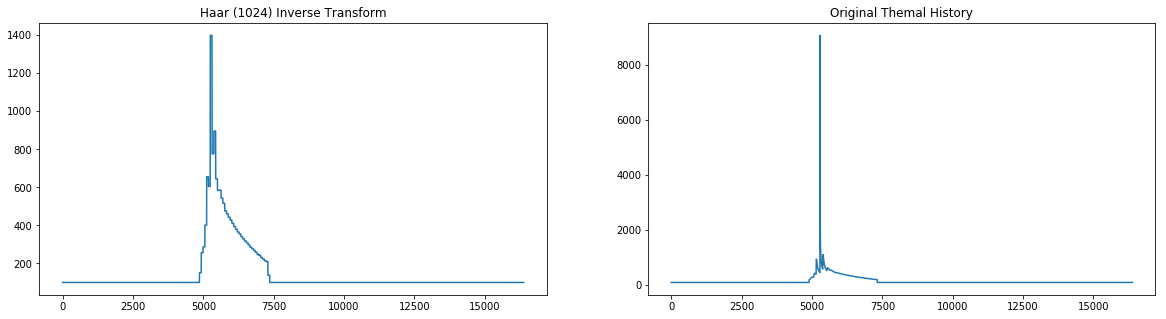

In [23]:
fig,ax = plt.subplots()

fig.set_size_inches(20,5)
plt.subplot(1,2,1)
plt.plot(Y_haarrec[994])
plt.title("Haar (1024) Inverse Transform")

plt.subplot(1,2,2)
plt.plot(Y_array[994])
plt.title("Original Themal History")

In [24]:
### Normalize the data 
from sklearn import preprocessing

X=preprocessing.normalize(X_array)
y,n=preprocessing.normalize(Y_haar,return_norm=True)

In [25]:
### Put the normalized data in a dataframe to track records
X1 = pd.DataFrame(X)
y1 = pd.DataFrame(y)

# 5. Train Test Split

In [26]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.33,shuffle=True,random_state=33)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda


# 6. Load X and Y into the PyTorch data loader

In [28]:
my_x = X_train 
my_y = Y_train  

class myDataset(Dataset):

    # Initialize the data to be later loaded on to the DataLoader
    def __init__(self,X,Y,transform=None):
        self.dim0 = X.shape[0]
        self.dim1 = X.shape[1]
        self.transform = transform
        self.x_data = X
        self.x_data = torch.FloatTensor(self.x_data).view(-1,1,self.dim1)
        self.y_data = torch.from_numpy(Y)
        self.y_data = self.y_data.float()
        
    def __getitem__(self, index):
        x = self.x_data[index]
        y = self.y_data[index]
        if self.transform:
            x=self.transform(x)
        return x,y
    
    def __len__(self):
        return self.dim0

In [29]:
# Train Dataset

xdataset = myDataset(X_train,Y_train,transform=None)
train_loader = DataLoader(dataset=xdataset,batch_size=512,
                          shuffle=False)

In [31]:
# Test Dataset, try to utilize all the CUDA cores in the GPU

test_batch_size = len(Y_test)

ydataset = myDataset(X_test,Y_test,transform=None)
test_loader = DataLoader(dataset=ydataset,batch_size=test_batch_size,
                          shuffle=False)

# 7. Build a CNN

In [33]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        
        #convolutional_layers
        self.conv1 = nn.Conv1d(1, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        self.conv3 = nn.Conv1d(16, 32, 3)
        self.conv4 = nn.Conv1d(32, 64, 3,dilation=2)

        
        #pooling_layer
        self.pool = nn.MaxPool1d(3,stride=2)
        
        #batch_normalization
        self.b_n1 = nn.BatchNorm1d(6)
        self.b_n2 = nn.BatchNorm1d(16)
        self.b_n3 = nn.BatchNorm1d(32)
        self.b_n4 = nn.BatchNorm1d(64)
    
        
        #dense/fully_connected_layers
        self.fc1 = nn.Linear(64 * 14, 1000)
        self.fc2 = nn.Linear(1000,256)
       
      
    #Feed Forward network
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.b_n1(x)
        x = self.pool(self.pool(self.pool(F.relu(self.conv2(x)))))
        x = self.b_n2(x)
        x = self.pool(self.pool(self.pool(F.relu(self.conv3(x)))))
        x = self.b_n3(x)
        x = self.pool(self.pool(self.pool(F.relu(self.conv4(x)))))
        x = self.b_n4(x)
        
        #Flatten the layer
        x = x.view(-1, 64 * 14)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
       
        
        return x

### 7.1 Optimizer

In [ ]:
import torch.optim as optim

# Choose loss function
criterion = nn.MSELoss()


# parameters to GPU
net_Adam = Net().to(device)

# Choose optimizer
opt_Adam = torch.optim.Adam(net_Adam.parameters(),lr=0.001)

name=["Adam"]
nets = [net_Adam]
optimizers = [opt_Adam]

Adaml = []

In [239]:
for epoch in range(1500):  # loop over the dataset multiple times (30 passes of all the training samples through 176 batches of 32)

    running_loss = 0.0
    r_l = 0.0
    for i, data in enumerate(train_loader,0):
        # get the inputs
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        for l,net,optimizer in zip(name,nets,optimizers):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            total += labels.size(0)
            if i % 1 == 0:    # print every mini-batch
                print(l,"(Epoch:",epoch+1,"; Batch:",i+1,")")
                print('[%2d, %3d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                if l=="Adam":
                    Adaml.append(running_loss/10)
                running_loss = 0.0
print('Finished Training')

torch.Size([512, 64, 6])
Adam (Epoch: 1 ; Batch: 1 )
[ 1,   1] loss: 0.003
torch.Size([512, 64, 6])
Adam (Epoch: 1 ; Batch: 2 )
[ 1,   2] loss: 0.001
torch.Size([512, 64, 6])
Adam (Epoch: 1 ; Batch: 3 )
[ 1,   3] loss: 0.001
torch.Size([512, 64, 6])
Adam (Epoch: 1 ; Batch: 4 )
[ 1,   4] loss: 0.001
torch.Size([512, 64, 6])
Adam (Epoch: 1 ; Batch: 5 )
[ 1,   5] loss: 0.001
torch.Size([512, 64, 6])
Adam (Epoch: 1 ; Batch: 6 )
[ 1,   6] loss: 0.001
torch.Size([512, 64, 6])
Adam (Epoch: 1 ; Batch: 7 )
[ 1,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1 ; Batch: 8 )
[ 1,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1 ; Batch: 9 )
[ 1,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 2 ; Batch: 1 )
[ 2,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 2 ; Batch: 2 )
[ 2,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 2 ; Batch: 3 )
[ 2,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 2 ; Batch: 4 )
[ 2,   4] loss: 0.000
torch.Size([512, 64, 6])


Adam (Epoch: 25 ; Batch: 1 )
[25,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 25 ; Batch: 2 )
[25,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 25 ; Batch: 3 )
[25,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 25 ; Batch: 4 )
[25,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 25 ; Batch: 5 )
[25,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 25 ; Batch: 6 )
[25,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 25 ; Batch: 7 )
[25,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 25 ; Batch: 8 )
[25,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 25 ; Batch: 9 )
[25,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 26 ; Batch: 1 )
[26,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 26 ; Batch: 2 )
[26,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 26 ; Batch: 3 )
[26,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 26 ; Batch: 4 )
[26,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch:

[48,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 49 ; Batch: 1 )
[49,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 49 ; Batch: 2 )
[49,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 49 ; Batch: 3 )
[49,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 49 ; Batch: 4 )
[49,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 49 ; Batch: 5 )
[49,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 49 ; Batch: 6 )
[49,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 49 ; Batch: 7 )
[49,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 49 ; Batch: 8 )
[49,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 49 ; Batch: 9 )
[49,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 50 ; Batch: 1 )
[50,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 50 ; Batch: 2 )
[50,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 50 ; Batch: 3 )
[50,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 50 ; Batch: 4 )
[50,   4] lo

torch.Size([311, 64, 6])
Adam (Epoch: 72 ; Batch: 9 )
[72,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 73 ; Batch: 1 )
[73,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 73 ; Batch: 2 )
[73,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 73 ; Batch: 3 )
[73,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 73 ; Batch: 4 )
[73,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 73 ; Batch: 5 )
[73,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 73 ; Batch: 6 )
[73,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 73 ; Batch: 7 )
[73,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 73 ; Batch: 8 )
[73,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 73 ; Batch: 9 )
[73,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 74 ; Batch: 1 )
[74,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 74 ; Batch: 2 )
[74,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 74 ; Batch: 3 )
[74,   3] loss: 0.000
torch.Size([

Adam (Epoch: 96 ; Batch: 8 )
[96,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 96 ; Batch: 9 )
[96,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 97 ; Batch: 1 )
[97,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 97 ; Batch: 2 )
[97,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 97 ; Batch: 3 )
[97,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 97 ; Batch: 4 )
[97,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 97 ; Batch: 5 )
[97,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 97 ; Batch: 6 )
[97,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 97 ; Batch: 7 )
[97,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 97 ; Batch: 8 )
[97,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 97 ; Batch: 9 )
[97,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 98 ; Batch: 1 )
[98,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 98 ; Batch: 2 )
[98,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch:

torch.Size([512, 64, 6])
Adam (Epoch: 120 ; Batch: 3 )
[120,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 120 ; Batch: 4 )
[120,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 120 ; Batch: 5 )
[120,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 120 ; Batch: 6 )
[120,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 120 ; Batch: 7 )
[120,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 120 ; Batch: 8 )
[120,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 120 ; Batch: 9 )
[120,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 121 ; Batch: 1 )
[121,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 121 ; Batch: 2 )
[121,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 121 ; Batch: 3 )
[121,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 121 ; Batch: 4 )
[121,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 121 ; Batch: 5 )
[121,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 121 ; Batch: 6 )
[121,   6

torch.Size([512, 64, 6])
Adam (Epoch: 143 ; Batch: 6 )
[143,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 143 ; Batch: 7 )
[143,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 143 ; Batch: 8 )
[143,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 143 ; Batch: 9 )
[143,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 144 ; Batch: 1 )
[144,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 144 ; Batch: 2 )
[144,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 144 ; Batch: 3 )
[144,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 144 ; Batch: 4 )
[144,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 144 ; Batch: 5 )
[144,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 144 ; Batch: 6 )
[144,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 144 ; Batch: 7 )
[144,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 144 ; Batch: 8 )
[144,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 144 ; Batch: 9 )
[144,   9

torch.Size([311, 64, 6])
Adam (Epoch: 166 ; Batch: 9 )
[166,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 167 ; Batch: 1 )
[167,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 167 ; Batch: 2 )
[167,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 167 ; Batch: 3 )
[167,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 167 ; Batch: 4 )
[167,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 167 ; Batch: 5 )
[167,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 167 ; Batch: 6 )
[167,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 167 ; Batch: 7 )
[167,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 167 ; Batch: 8 )
[167,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 167 ; Batch: 9 )
[167,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 168 ; Batch: 1 )
[168,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 168 ; Batch: 2 )
[168,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 168 ; Batch: 3 )
[168,   3

torch.Size([512, 64, 6])
Adam (Epoch: 190 ; Batch: 3 )
[190,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 190 ; Batch: 4 )
[190,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 190 ; Batch: 5 )
[190,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 190 ; Batch: 6 )
[190,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 190 ; Batch: 7 )
[190,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 190 ; Batch: 8 )
[190,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 190 ; Batch: 9 )
[190,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 191 ; Batch: 1 )
[191,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 191 ; Batch: 2 )
[191,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 191 ; Batch: 3 )
[191,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 191 ; Batch: 4 )
[191,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 191 ; Batch: 5 )
[191,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 191 ; Batch: 6 )
[191,   6

torch.Size([512, 64, 6])
Adam (Epoch: 213 ; Batch: 6 )
[213,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 213 ; Batch: 7 )
[213,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 213 ; Batch: 8 )
[213,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 213 ; Batch: 9 )
[213,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 214 ; Batch: 1 )
[214,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 214 ; Batch: 2 )
[214,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 214 ; Batch: 3 )
[214,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 214 ; Batch: 4 )
[214,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 214 ; Batch: 5 )
[214,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 214 ; Batch: 6 )
[214,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 214 ; Batch: 7 )
[214,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 214 ; Batch: 8 )
[214,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 214 ; Batch: 9 )
[214,   9

torch.Size([311, 64, 6])
Adam (Epoch: 236 ; Batch: 9 )
[236,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 237 ; Batch: 1 )
[237,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 237 ; Batch: 2 )
[237,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 237 ; Batch: 3 )
[237,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 237 ; Batch: 4 )
[237,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 237 ; Batch: 5 )
[237,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 237 ; Batch: 6 )
[237,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 237 ; Batch: 7 )
[237,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 237 ; Batch: 8 )
[237,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 237 ; Batch: 9 )
[237,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 238 ; Batch: 1 )
[238,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 238 ; Batch: 2 )
[238,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 238 ; Batch: 3 )
[238,   3

torch.Size([512, 64, 6])
Adam (Epoch: 260 ; Batch: 3 )
[260,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 260 ; Batch: 4 )
[260,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 260 ; Batch: 5 )
[260,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 260 ; Batch: 6 )
[260,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 260 ; Batch: 7 )
[260,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 260 ; Batch: 8 )
[260,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 260 ; Batch: 9 )
[260,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 261 ; Batch: 1 )
[261,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 261 ; Batch: 2 )
[261,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 261 ; Batch: 3 )
[261,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 261 ; Batch: 4 )
[261,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 261 ; Batch: 5 )
[261,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 261 ; Batch: 6 )
[261,   6

torch.Size([512, 64, 6])
Adam (Epoch: 283 ; Batch: 6 )
[283,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 283 ; Batch: 7 )
[283,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 283 ; Batch: 8 )
[283,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 283 ; Batch: 9 )
[283,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 284 ; Batch: 1 )
[284,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 284 ; Batch: 2 )
[284,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 284 ; Batch: 3 )
[284,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 284 ; Batch: 4 )
[284,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 284 ; Batch: 5 )
[284,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 284 ; Batch: 6 )
[284,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 284 ; Batch: 7 )
[284,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 284 ; Batch: 8 )
[284,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 284 ; Batch: 9 )
[284,   9

torch.Size([311, 64, 6])
Adam (Epoch: 306 ; Batch: 9 )
[306,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 307 ; Batch: 1 )
[307,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 307 ; Batch: 2 )
[307,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 307 ; Batch: 3 )
[307,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 307 ; Batch: 4 )
[307,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 307 ; Batch: 5 )
[307,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 307 ; Batch: 6 )
[307,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 307 ; Batch: 7 )
[307,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 307 ; Batch: 8 )
[307,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 307 ; Batch: 9 )
[307,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 308 ; Batch: 1 )
[308,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 308 ; Batch: 2 )
[308,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 308 ; Batch: 3 )
[308,   3

torch.Size([512, 64, 6])
Adam (Epoch: 330 ; Batch: 3 )
[330,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 330 ; Batch: 4 )
[330,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 330 ; Batch: 5 )
[330,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 330 ; Batch: 6 )
[330,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 330 ; Batch: 7 )
[330,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 330 ; Batch: 8 )
[330,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 330 ; Batch: 9 )
[330,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 331 ; Batch: 1 )
[331,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 331 ; Batch: 2 )
[331,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 331 ; Batch: 3 )
[331,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 331 ; Batch: 4 )
[331,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 331 ; Batch: 5 )
[331,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 331 ; Batch: 6 )
[331,   6

torch.Size([512, 64, 6])
Adam (Epoch: 353 ; Batch: 6 )
[353,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 353 ; Batch: 7 )
[353,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 353 ; Batch: 8 )
[353,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 353 ; Batch: 9 )
[353,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 354 ; Batch: 1 )
[354,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 354 ; Batch: 2 )
[354,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 354 ; Batch: 3 )
[354,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 354 ; Batch: 4 )
[354,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 354 ; Batch: 5 )
[354,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 354 ; Batch: 6 )
[354,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 354 ; Batch: 7 )
[354,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 354 ; Batch: 8 )
[354,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 354 ; Batch: 9 )
[354,   9

torch.Size([311, 64, 6])
Adam (Epoch: 376 ; Batch: 9 )
[376,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 377 ; Batch: 1 )
[377,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 377 ; Batch: 2 )
[377,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 377 ; Batch: 3 )
[377,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 377 ; Batch: 4 )
[377,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 377 ; Batch: 5 )
[377,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 377 ; Batch: 6 )
[377,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 377 ; Batch: 7 )
[377,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 377 ; Batch: 8 )
[377,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 377 ; Batch: 9 )
[377,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 378 ; Batch: 1 )
[378,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 378 ; Batch: 2 )
[378,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 378 ; Batch: 3 )
[378,   3

torch.Size([512, 64, 6])
Adam (Epoch: 400 ; Batch: 3 )
[400,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 400 ; Batch: 4 )
[400,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 400 ; Batch: 5 )
[400,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 400 ; Batch: 6 )
[400,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 400 ; Batch: 7 )
[400,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 400 ; Batch: 8 )
[400,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 400 ; Batch: 9 )
[400,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 401 ; Batch: 1 )
[401,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 401 ; Batch: 2 )
[401,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 401 ; Batch: 3 )
[401,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 401 ; Batch: 4 )
[401,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 401 ; Batch: 5 )
[401,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 401 ; Batch: 6 )
[401,   6

torch.Size([512, 64, 6])
Adam (Epoch: 423 ; Batch: 6 )
[423,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 423 ; Batch: 7 )
[423,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 423 ; Batch: 8 )
[423,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 423 ; Batch: 9 )
[423,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 424 ; Batch: 1 )
[424,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 424 ; Batch: 2 )
[424,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 424 ; Batch: 3 )
[424,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 424 ; Batch: 4 )
[424,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 424 ; Batch: 5 )
[424,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 424 ; Batch: 6 )
[424,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 424 ; Batch: 7 )
[424,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 424 ; Batch: 8 )
[424,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 424 ; Batch: 9 )
[424,   9

torch.Size([311, 64, 6])
Adam (Epoch: 446 ; Batch: 9 )
[446,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 447 ; Batch: 1 )
[447,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 447 ; Batch: 2 )
[447,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 447 ; Batch: 3 )
[447,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 447 ; Batch: 4 )
[447,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 447 ; Batch: 5 )
[447,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 447 ; Batch: 6 )
[447,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 447 ; Batch: 7 )
[447,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 447 ; Batch: 8 )
[447,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 447 ; Batch: 9 )
[447,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 448 ; Batch: 1 )
[448,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 448 ; Batch: 2 )
[448,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 448 ; Batch: 3 )
[448,   3

torch.Size([512, 64, 6])
Adam (Epoch: 470 ; Batch: 3 )
[470,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 470 ; Batch: 4 )
[470,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 470 ; Batch: 5 )
[470,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 470 ; Batch: 6 )
[470,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 470 ; Batch: 7 )
[470,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 470 ; Batch: 8 )
[470,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 470 ; Batch: 9 )
[470,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 471 ; Batch: 1 )
[471,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 471 ; Batch: 2 )
[471,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 471 ; Batch: 3 )
[471,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 471 ; Batch: 4 )
[471,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 471 ; Batch: 5 )
[471,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 471 ; Batch: 6 )
[471,   6

torch.Size([512, 64, 6])
Adam (Epoch: 493 ; Batch: 6 )
[493,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 493 ; Batch: 7 )
[493,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 493 ; Batch: 8 )
[493,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 493 ; Batch: 9 )
[493,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 494 ; Batch: 1 )
[494,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 494 ; Batch: 2 )
[494,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 494 ; Batch: 3 )
[494,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 494 ; Batch: 4 )
[494,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 494 ; Batch: 5 )
[494,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 494 ; Batch: 6 )
[494,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 494 ; Batch: 7 )
[494,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 494 ; Batch: 8 )
[494,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 494 ; Batch: 9 )
[494,   9

torch.Size([311, 64, 6])
Adam (Epoch: 516 ; Batch: 9 )
[516,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 517 ; Batch: 1 )
[517,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 517 ; Batch: 2 )
[517,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 517 ; Batch: 3 )
[517,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 517 ; Batch: 4 )
[517,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 517 ; Batch: 5 )
[517,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 517 ; Batch: 6 )
[517,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 517 ; Batch: 7 )
[517,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 517 ; Batch: 8 )
[517,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 517 ; Batch: 9 )
[517,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 518 ; Batch: 1 )
[518,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 518 ; Batch: 2 )
[518,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 518 ; Batch: 3 )
[518,   3

torch.Size([512, 64, 6])
Adam (Epoch: 540 ; Batch: 3 )
[540,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 540 ; Batch: 4 )
[540,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 540 ; Batch: 5 )
[540,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 540 ; Batch: 6 )
[540,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 540 ; Batch: 7 )
[540,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 540 ; Batch: 8 )
[540,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 540 ; Batch: 9 )
[540,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 541 ; Batch: 1 )
[541,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 541 ; Batch: 2 )
[541,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 541 ; Batch: 3 )
[541,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 541 ; Batch: 4 )
[541,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 541 ; Batch: 5 )
[541,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 541 ; Batch: 6 )
[541,   6

torch.Size([512, 64, 6])
Adam (Epoch: 563 ; Batch: 6 )
[563,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 563 ; Batch: 7 )
[563,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 563 ; Batch: 8 )
[563,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 563 ; Batch: 9 )
[563,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 564 ; Batch: 1 )
[564,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 564 ; Batch: 2 )
[564,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 564 ; Batch: 3 )
[564,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 564 ; Batch: 4 )
[564,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 564 ; Batch: 5 )
[564,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 564 ; Batch: 6 )
[564,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 564 ; Batch: 7 )
[564,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 564 ; Batch: 8 )
[564,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 564 ; Batch: 9 )
[564,   9

torch.Size([311, 64, 6])
Adam (Epoch: 586 ; Batch: 9 )
[586,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 587 ; Batch: 1 )
[587,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 587 ; Batch: 2 )
[587,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 587 ; Batch: 3 )
[587,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 587 ; Batch: 4 )
[587,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 587 ; Batch: 5 )
[587,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 587 ; Batch: 6 )
[587,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 587 ; Batch: 7 )
[587,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 587 ; Batch: 8 )
[587,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 587 ; Batch: 9 )
[587,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 588 ; Batch: 1 )
[588,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 588 ; Batch: 2 )
[588,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 588 ; Batch: 3 )
[588,   3

torch.Size([512, 64, 6])
Adam (Epoch: 610 ; Batch: 3 )
[610,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 610 ; Batch: 4 )
[610,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 610 ; Batch: 5 )
[610,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 610 ; Batch: 6 )
[610,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 610 ; Batch: 7 )
[610,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 610 ; Batch: 8 )
[610,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 610 ; Batch: 9 )
[610,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 611 ; Batch: 1 )
[611,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 611 ; Batch: 2 )
[611,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 611 ; Batch: 3 )
[611,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 611 ; Batch: 4 )
[611,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 611 ; Batch: 5 )
[611,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 611 ; Batch: 6 )
[611,   6

torch.Size([512, 64, 6])
Adam (Epoch: 633 ; Batch: 6 )
[633,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 633 ; Batch: 7 )
[633,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 633 ; Batch: 8 )
[633,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 633 ; Batch: 9 )
[633,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 634 ; Batch: 1 )
[634,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 634 ; Batch: 2 )
[634,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 634 ; Batch: 3 )
[634,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 634 ; Batch: 4 )
[634,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 634 ; Batch: 5 )
[634,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 634 ; Batch: 6 )
[634,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 634 ; Batch: 7 )
[634,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 634 ; Batch: 8 )
[634,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 634 ; Batch: 9 )
[634,   9

torch.Size([311, 64, 6])
Adam (Epoch: 656 ; Batch: 9 )
[656,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 657 ; Batch: 1 )
[657,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 657 ; Batch: 2 )
[657,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 657 ; Batch: 3 )
[657,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 657 ; Batch: 4 )
[657,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 657 ; Batch: 5 )
[657,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 657 ; Batch: 6 )
[657,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 657 ; Batch: 7 )
[657,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 657 ; Batch: 8 )
[657,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 657 ; Batch: 9 )
[657,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 658 ; Batch: 1 )
[658,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 658 ; Batch: 2 )
[658,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 658 ; Batch: 3 )
[658,   3

torch.Size([512, 64, 6])
Adam (Epoch: 680 ; Batch: 3 )
[680,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 680 ; Batch: 4 )
[680,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 680 ; Batch: 5 )
[680,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 680 ; Batch: 6 )
[680,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 680 ; Batch: 7 )
[680,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 680 ; Batch: 8 )
[680,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 680 ; Batch: 9 )
[680,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 681 ; Batch: 1 )
[681,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 681 ; Batch: 2 )
[681,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 681 ; Batch: 3 )
[681,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 681 ; Batch: 4 )
[681,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 681 ; Batch: 5 )
[681,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 681 ; Batch: 6 )
[681,   6

torch.Size([512, 64, 6])
Adam (Epoch: 703 ; Batch: 6 )
[703,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 703 ; Batch: 7 )
[703,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 703 ; Batch: 8 )
[703,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 703 ; Batch: 9 )
[703,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 704 ; Batch: 1 )
[704,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 704 ; Batch: 2 )
[704,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 704 ; Batch: 3 )
[704,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 704 ; Batch: 4 )
[704,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 704 ; Batch: 5 )
[704,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 704 ; Batch: 6 )
[704,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 704 ; Batch: 7 )
[704,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 704 ; Batch: 8 )
[704,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 704 ; Batch: 9 )
[704,   9

torch.Size([311, 64, 6])
Adam (Epoch: 726 ; Batch: 9 )
[726,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 727 ; Batch: 1 )
[727,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 727 ; Batch: 2 )
[727,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 727 ; Batch: 3 )
[727,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 727 ; Batch: 4 )
[727,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 727 ; Batch: 5 )
[727,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 727 ; Batch: 6 )
[727,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 727 ; Batch: 7 )
[727,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 727 ; Batch: 8 )
[727,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 727 ; Batch: 9 )
[727,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 728 ; Batch: 1 )
[728,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 728 ; Batch: 2 )
[728,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 728 ; Batch: 3 )
[728,   3

torch.Size([512, 64, 6])
Adam (Epoch: 750 ; Batch: 3 )
[750,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 750 ; Batch: 4 )
[750,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 750 ; Batch: 5 )
[750,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 750 ; Batch: 6 )
[750,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 750 ; Batch: 7 )
[750,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 750 ; Batch: 8 )
[750,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 750 ; Batch: 9 )
[750,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 751 ; Batch: 1 )
[751,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 751 ; Batch: 2 )
[751,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 751 ; Batch: 3 )
[751,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 751 ; Batch: 4 )
[751,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 751 ; Batch: 5 )
[751,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 751 ; Batch: 6 )
[751,   6

torch.Size([512, 64, 6])
Adam (Epoch: 773 ; Batch: 6 )
[773,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 773 ; Batch: 7 )
[773,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 773 ; Batch: 8 )
[773,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 773 ; Batch: 9 )
[773,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 774 ; Batch: 1 )
[774,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 774 ; Batch: 2 )
[774,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 774 ; Batch: 3 )
[774,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 774 ; Batch: 4 )
[774,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 774 ; Batch: 5 )
[774,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 774 ; Batch: 6 )
[774,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 774 ; Batch: 7 )
[774,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 774 ; Batch: 8 )
[774,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 774 ; Batch: 9 )
[774,   9

torch.Size([311, 64, 6])
Adam (Epoch: 796 ; Batch: 9 )
[796,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 797 ; Batch: 1 )
[797,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 797 ; Batch: 2 )
[797,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 797 ; Batch: 3 )
[797,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 797 ; Batch: 4 )
[797,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 797 ; Batch: 5 )
[797,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 797 ; Batch: 6 )
[797,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 797 ; Batch: 7 )
[797,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 797 ; Batch: 8 )
[797,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 797 ; Batch: 9 )
[797,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 798 ; Batch: 1 )
[798,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 798 ; Batch: 2 )
[798,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 798 ; Batch: 3 )
[798,   3

torch.Size([512, 64, 6])
Adam (Epoch: 820 ; Batch: 3 )
[820,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 820 ; Batch: 4 )
[820,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 820 ; Batch: 5 )
[820,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 820 ; Batch: 6 )
[820,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 820 ; Batch: 7 )
[820,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 820 ; Batch: 8 )
[820,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 820 ; Batch: 9 )
[820,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 821 ; Batch: 1 )
[821,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 821 ; Batch: 2 )
[821,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 821 ; Batch: 3 )
[821,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 821 ; Batch: 4 )
[821,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 821 ; Batch: 5 )
[821,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 821 ; Batch: 6 )
[821,   6

torch.Size([512, 64, 6])
Adam (Epoch: 843 ; Batch: 6 )
[843,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 843 ; Batch: 7 )
[843,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 843 ; Batch: 8 )
[843,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 843 ; Batch: 9 )
[843,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 844 ; Batch: 1 )
[844,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 844 ; Batch: 2 )
[844,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 844 ; Batch: 3 )
[844,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 844 ; Batch: 4 )
[844,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 844 ; Batch: 5 )
[844,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 844 ; Batch: 6 )
[844,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 844 ; Batch: 7 )
[844,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 844 ; Batch: 8 )
[844,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 844 ; Batch: 9 )
[844,   9

torch.Size([311, 64, 6])
Adam (Epoch: 866 ; Batch: 9 )
[866,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 867 ; Batch: 1 )
[867,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 867 ; Batch: 2 )
[867,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 867 ; Batch: 3 )
[867,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 867 ; Batch: 4 )
[867,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 867 ; Batch: 5 )
[867,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 867 ; Batch: 6 )
[867,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 867 ; Batch: 7 )
[867,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 867 ; Batch: 8 )
[867,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 867 ; Batch: 9 )
[867,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 868 ; Batch: 1 )
[868,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 868 ; Batch: 2 )
[868,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 868 ; Batch: 3 )
[868,   3

torch.Size([512, 64, 6])
Adam (Epoch: 890 ; Batch: 3 )
[890,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 890 ; Batch: 4 )
[890,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 890 ; Batch: 5 )
[890,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 890 ; Batch: 6 )
[890,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 890 ; Batch: 7 )
[890,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 890 ; Batch: 8 )
[890,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 890 ; Batch: 9 )
[890,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 891 ; Batch: 1 )
[891,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 891 ; Batch: 2 )
[891,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 891 ; Batch: 3 )
[891,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 891 ; Batch: 4 )
[891,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 891 ; Batch: 5 )
[891,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 891 ; Batch: 6 )
[891,   6

torch.Size([512, 64, 6])
Adam (Epoch: 913 ; Batch: 6 )
[913,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 913 ; Batch: 7 )
[913,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 913 ; Batch: 8 )
[913,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 913 ; Batch: 9 )
[913,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 914 ; Batch: 1 )
[914,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 914 ; Batch: 2 )
[914,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 914 ; Batch: 3 )
[914,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 914 ; Batch: 4 )
[914,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 914 ; Batch: 5 )
[914,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 914 ; Batch: 6 )
[914,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 914 ; Batch: 7 )
[914,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 914 ; Batch: 8 )
[914,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 914 ; Batch: 9 )
[914,   9

torch.Size([311, 64, 6])
Adam (Epoch: 936 ; Batch: 9 )
[936,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 937 ; Batch: 1 )
[937,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 937 ; Batch: 2 )
[937,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 937 ; Batch: 3 )
[937,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 937 ; Batch: 4 )
[937,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 937 ; Batch: 5 )
[937,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 937 ; Batch: 6 )
[937,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 937 ; Batch: 7 )
[937,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 937 ; Batch: 8 )
[937,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 937 ; Batch: 9 )
[937,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 938 ; Batch: 1 )
[938,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 938 ; Batch: 2 )
[938,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 938 ; Batch: 3 )
[938,   3

torch.Size([512, 64, 6])
Adam (Epoch: 960 ; Batch: 3 )
[960,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 960 ; Batch: 4 )
[960,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 960 ; Batch: 5 )
[960,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 960 ; Batch: 6 )
[960,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 960 ; Batch: 7 )
[960,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 960 ; Batch: 8 )
[960,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 960 ; Batch: 9 )
[960,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 961 ; Batch: 1 )
[961,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 961 ; Batch: 2 )
[961,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 961 ; Batch: 3 )
[961,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 961 ; Batch: 4 )
[961,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 961 ; Batch: 5 )
[961,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 961 ; Batch: 6 )
[961,   6

torch.Size([512, 64, 6])
Adam (Epoch: 983 ; Batch: 6 )
[983,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 983 ; Batch: 7 )
[983,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 983 ; Batch: 8 )
[983,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 983 ; Batch: 9 )
[983,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 984 ; Batch: 1 )
[984,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 984 ; Batch: 2 )
[984,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 984 ; Batch: 3 )
[984,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 984 ; Batch: 4 )
[984,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 984 ; Batch: 5 )
[984,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 984 ; Batch: 6 )
[984,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 984 ; Batch: 7 )
[984,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 984 ; Batch: 8 )
[984,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 984 ; Batch: 9 )
[984,   9

Adam (Epoch: 1006 ; Batch: 7 )
[1006,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1006 ; Batch: 8 )
[1006,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1006 ; Batch: 9 )
[1006,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1007 ; Batch: 1 )
[1007,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1007 ; Batch: 2 )
[1007,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1007 ; Batch: 3 )
[1007,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1007 ; Batch: 4 )
[1007,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1007 ; Batch: 5 )
[1007,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1007 ; Batch: 6 )
[1007,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1007 ; Batch: 7 )
[1007,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1007 ; Batch: 8 )
[1007,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1007 ; Batch: 9 )
[1007,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1008 ; Batch: 1 )
[1008,   

torch.Size([512, 64, 6])
Adam (Epoch: 1029 ; Batch: 5 )
[1029,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1029 ; Batch: 6 )
[1029,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1029 ; Batch: 7 )
[1029,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1029 ; Batch: 8 )
[1029,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1029 ; Batch: 9 )
[1029,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1030 ; Batch: 1 )
[1030,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1030 ; Batch: 2 )
[1030,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1030 ; Batch: 3 )
[1030,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1030 ; Batch: 4 )
[1030,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1030 ; Batch: 5 )
[1030,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1030 ; Batch: 6 )
[1030,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1030 ; Batch: 7 )
[1030,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 10

[1052,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1052 ; Batch: 3 )
[1052,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1052 ; Batch: 4 )
[1052,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1052 ; Batch: 5 )
[1052,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1052 ; Batch: 6 )
[1052,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1052 ; Batch: 7 )
[1052,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1052 ; Batch: 8 )
[1052,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1052 ; Batch: 9 )
[1052,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1053 ; Batch: 1 )
[1053,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1053 ; Batch: 2 )
[1053,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1053 ; Batch: 3 )
[1053,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1053 ; Batch: 4 )
[1053,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1053 ; Batch: 5 )
[1053,   5] loss: 0.000
torch.Size([512,

Adam (Epoch: 1074 ; Batch: 9 )
[1074,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1075 ; Batch: 1 )
[1075,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1075 ; Batch: 2 )
[1075,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1075 ; Batch: 3 )
[1075,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1075 ; Batch: 4 )
[1075,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1075 ; Batch: 5 )
[1075,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1075 ; Batch: 6 )
[1075,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1075 ; Batch: 7 )
[1075,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1075 ; Batch: 8 )
[1075,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1075 ; Batch: 9 )
[1075,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1076 ; Batch: 1 )
[1076,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1076 ; Batch: 2 )
[1076,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1076 ; Batch: 3 )
[1076,   

torch.Size([512, 64, 6])
Adam (Epoch: 1097 ; Batch: 7 )
[1097,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1097 ; Batch: 8 )
[1097,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1097 ; Batch: 9 )
[1097,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1098 ; Batch: 1 )
[1098,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1098 ; Batch: 2 )
[1098,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1098 ; Batch: 3 )
[1098,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1098 ; Batch: 4 )
[1098,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1098 ; Batch: 5 )
[1098,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1098 ; Batch: 6 )
[1098,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1098 ; Batch: 7 )
[1098,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1098 ; Batch: 8 )
[1098,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1098 ; Batch: 9 )
[1098,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 10

[1120,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1120 ; Batch: 5 )
[1120,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1120 ; Batch: 6 )
[1120,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1120 ; Batch: 7 )
[1120,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1120 ; Batch: 8 )
[1120,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1120 ; Batch: 9 )
[1120,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1121 ; Batch: 1 )
[1121,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1121 ; Batch: 2 )
[1121,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1121 ; Batch: 3 )
[1121,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1121 ; Batch: 4 )
[1121,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1121 ; Batch: 5 )
[1121,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1121 ; Batch: 6 )
[1121,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1121 ; Batch: 7 )
[1121,   7] loss: 0.000
torch.Size([512,

Adam (Epoch: 1143 ; Batch: 2 )
[1143,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1143 ; Batch: 3 )
[1143,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1143 ; Batch: 4 )
[1143,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1143 ; Batch: 5 )
[1143,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1143 ; Batch: 6 )
[1143,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1143 ; Batch: 7 )
[1143,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1143 ; Batch: 8 )
[1143,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1143 ; Batch: 9 )
[1143,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1144 ; Batch: 1 )
[1144,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1144 ; Batch: 2 )
[1144,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1144 ; Batch: 3 )
[1144,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1144 ; Batch: 4 )
[1144,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1144 ; Batch: 5 )
[1144,   

torch.Size([311, 64, 6])
Adam (Epoch: 1165 ; Batch: 9 )
[1165,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1166 ; Batch: 1 )
[1166,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1166 ; Batch: 2 )
[1166,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1166 ; Batch: 3 )
[1166,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1166 ; Batch: 4 )
[1166,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1166 ; Batch: 5 )
[1166,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1166 ; Batch: 6 )
[1166,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1166 ; Batch: 7 )
[1166,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1166 ; Batch: 8 )
[1166,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1166 ; Batch: 9 )
[1166,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1167 ; Batch: 1 )
[1167,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1167 ; Batch: 2 )
[1167,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 11

[1188,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1188 ; Batch: 7 )
[1188,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1188 ; Batch: 8 )
[1188,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1188 ; Batch: 9 )
[1188,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1189 ; Batch: 1 )
[1189,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1189 ; Batch: 2 )
[1189,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1189 ; Batch: 3 )
[1189,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1189 ; Batch: 4 )
[1189,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1189 ; Batch: 5 )
[1189,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1189 ; Batch: 6 )
[1189,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1189 ; Batch: 7 )
[1189,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1189 ; Batch: 8 )
[1189,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1189 ; Batch: 9 )
[1189,   9] loss: 0.000
torch.Size([512,

Adam (Epoch: 1211 ; Batch: 4 )
[1211,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1211 ; Batch: 5 )
[1211,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1211 ; Batch: 6 )
[1211,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1211 ; Batch: 7 )
[1211,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1211 ; Batch: 8 )
[1211,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1211 ; Batch: 9 )
[1211,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1212 ; Batch: 1 )
[1212,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1212 ; Batch: 2 )
[1212,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1212 ; Batch: 3 )
[1212,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1212 ; Batch: 4 )
[1212,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1212 ; Batch: 5 )
[1212,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1212 ; Batch: 6 )
[1212,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1212 ; Batch: 7 )
[1212,   

torch.Size([512, 64, 6])
Adam (Epoch: 1234 ; Batch: 2 )
[1234,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1234 ; Batch: 3 )
[1234,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1234 ; Batch: 4 )
[1234,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1234 ; Batch: 5 )
[1234,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1234 ; Batch: 6 )
[1234,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1234 ; Batch: 7 )
[1234,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1234 ; Batch: 8 )
[1234,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1234 ; Batch: 9 )
[1234,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1235 ; Batch: 1 )
[1235,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1235 ; Batch: 2 )
[1235,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1235 ; Batch: 3 )
[1235,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1235 ; Batch: 4 )
[1235,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 12

[1256,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1256 ; Batch: 9 )
[1256,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1257 ; Batch: 1 )
[1257,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1257 ; Batch: 2 )
[1257,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1257 ; Batch: 3 )
[1257,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1257 ; Batch: 4 )
[1257,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1257 ; Batch: 5 )
[1257,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1257 ; Batch: 6 )
[1257,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1257 ; Batch: 7 )
[1257,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1257 ; Batch: 8 )
[1257,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1257 ; Batch: 9 )
[1257,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1258 ; Batch: 1 )
[1258,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1258 ; Batch: 2 )
[1258,   2] loss: 0.000
torch.Size([512,

Adam (Epoch: 1279 ; Batch: 6 )
[1279,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1279 ; Batch: 7 )
[1279,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1279 ; Batch: 8 )
[1279,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1279 ; Batch: 9 )
[1279,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1280 ; Batch: 1 )
[1280,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1280 ; Batch: 2 )
[1280,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1280 ; Batch: 3 )
[1280,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1280 ; Batch: 4 )
[1280,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1280 ; Batch: 5 )
[1280,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1280 ; Batch: 6 )
[1280,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1280 ; Batch: 7 )
[1280,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1280 ; Batch: 8 )
[1280,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1280 ; Batch: 9 )
[1280,   

torch.Size([512, 64, 6])
Adam (Epoch: 1302 ; Batch: 4 )
[1302,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1302 ; Batch: 5 )
[1302,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1302 ; Batch: 6 )
[1302,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1302 ; Batch: 7 )
[1302,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1302 ; Batch: 8 )
[1302,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1302 ; Batch: 9 )
[1302,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1303 ; Batch: 1 )
[1303,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1303 ; Batch: 2 )
[1303,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1303 ; Batch: 3 )
[1303,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1303 ; Batch: 4 )
[1303,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1303 ; Batch: 5 )
[1303,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1303 ; Batch: 6 )
[1303,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 13

[1325,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1325 ; Batch: 2 )
[1325,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1325 ; Batch: 3 )
[1325,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1325 ; Batch: 4 )
[1325,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1325 ; Batch: 5 )
[1325,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1325 ; Batch: 6 )
[1325,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1325 ; Batch: 7 )
[1325,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1325 ; Batch: 8 )
[1325,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1325 ; Batch: 9 )
[1325,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1326 ; Batch: 1 )
[1326,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1326 ; Batch: 2 )
[1326,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1326 ; Batch: 3 )
[1326,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1326 ; Batch: 4 )
[1326,   4] loss: 0.000
torch.Size([512,

Adam (Epoch: 1347 ; Batch: 8 )
[1347,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1347 ; Batch: 9 )
[1347,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1348 ; Batch: 1 )
[1348,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1348 ; Batch: 2 )
[1348,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1348 ; Batch: 3 )
[1348,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1348 ; Batch: 4 )
[1348,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1348 ; Batch: 5 )
[1348,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1348 ; Batch: 6 )
[1348,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1348 ; Batch: 7 )
[1348,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1348 ; Batch: 8 )
[1348,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1348 ; Batch: 9 )
[1348,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1349 ; Batch: 1 )
[1349,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1349 ; Batch: 2 )
[1349,   

torch.Size([512, 64, 6])
Adam (Epoch: 1370 ; Batch: 6 )
[1370,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1370 ; Batch: 7 )
[1370,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1370 ; Batch: 8 )
[1370,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1370 ; Batch: 9 )
[1370,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1371 ; Batch: 1 )
[1371,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1371 ; Batch: 2 )
[1371,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1371 ; Batch: 3 )
[1371,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1371 ; Batch: 4 )
[1371,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1371 ; Batch: 5 )
[1371,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1371 ; Batch: 6 )
[1371,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1371 ; Batch: 7 )
[1371,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1371 ; Batch: 8 )
[1371,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 13

[1393,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1393 ; Batch: 4 )
[1393,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1393 ; Batch: 5 )
[1393,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1393 ; Batch: 6 )
[1393,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1393 ; Batch: 7 )
[1393,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1393 ; Batch: 8 )
[1393,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1393 ; Batch: 9 )
[1393,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1394 ; Batch: 1 )
[1394,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1394 ; Batch: 2 )
[1394,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1394 ; Batch: 3 )
[1394,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1394 ; Batch: 4 )
[1394,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1394 ; Batch: 5 )
[1394,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1394 ; Batch: 6 )
[1394,   6] loss: 0.000
torch.Size([512,

Adam (Epoch: 1416 ; Batch: 1 )
[1416,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1416 ; Batch: 2 )
[1416,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1416 ; Batch: 3 )
[1416,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1416 ; Batch: 4 )
[1416,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1416 ; Batch: 5 )
[1416,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1416 ; Batch: 6 )
[1416,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1416 ; Batch: 7 )
[1416,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1416 ; Batch: 8 )
[1416,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1416 ; Batch: 9 )
[1416,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1417 ; Batch: 1 )
[1417,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1417 ; Batch: 2 )
[1417,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1417 ; Batch: 3 )
[1417,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1417 ; Batch: 4 )
[1417,   

torch.Size([512, 64, 6])
Adam (Epoch: 1438 ; Batch: 8 )
[1438,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1438 ; Batch: 9 )
[1438,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1439 ; Batch: 1 )
[1439,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1439 ; Batch: 2 )
[1439,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1439 ; Batch: 3 )
[1439,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1439 ; Batch: 4 )
[1439,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1439 ; Batch: 5 )
[1439,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1439 ; Batch: 6 )
[1439,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1439 ; Batch: 7 )
[1439,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1439 ; Batch: 8 )
[1439,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1439 ; Batch: 9 )
[1439,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1440 ; Batch: 1 )
[1440,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 14

[1461,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1461 ; Batch: 6 )
[1461,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1461 ; Batch: 7 )
[1461,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1461 ; Batch: 8 )
[1461,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1461 ; Batch: 9 )
[1461,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1462 ; Batch: 1 )
[1462,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1462 ; Batch: 2 )
[1462,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1462 ; Batch: 3 )
[1462,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1462 ; Batch: 4 )
[1462,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1462 ; Batch: 5 )
[1462,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1462 ; Batch: 6 )
[1462,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1462 ; Batch: 7 )
[1462,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1462 ; Batch: 8 )
[1462,   8] loss: 0.000
torch.Size([311,

Adam (Epoch: 1484 ; Batch: 3 )
[1484,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1484 ; Batch: 4 )
[1484,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1484 ; Batch: 5 )
[1484,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1484 ; Batch: 6 )
[1484,   6] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1484 ; Batch: 7 )
[1484,   7] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1484 ; Batch: 8 )
[1484,   8] loss: 0.000
torch.Size([311, 64, 6])
Adam (Epoch: 1484 ; Batch: 9 )
[1484,   9] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1485 ; Batch: 1 )
[1485,   1] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1485 ; Batch: 2 )
[1485,   2] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1485 ; Batch: 3 )
[1485,   3] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1485 ; Batch: 4 )
[1485,   4] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1485 ; Batch: 5 )
[1485,   5] loss: 0.000
torch.Size([512, 64, 6])
Adam (Epoch: 1485 ; Batch: 6 )
[1485,   

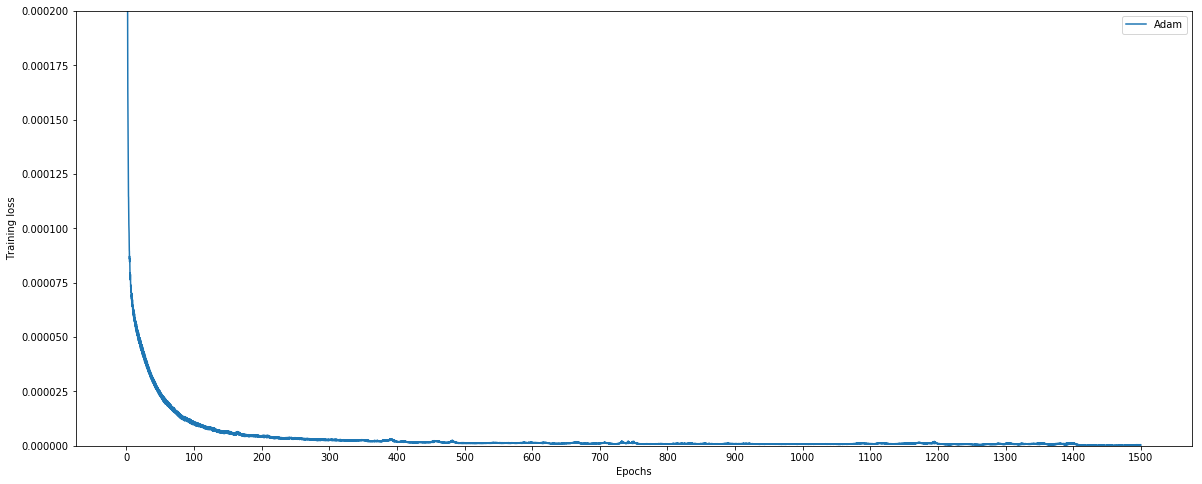

In [276]:
# Plot the losses through epochs

lo = [Adaml]
ticks = len(X_train)/9

fig,ax = plt.subplots()
fig.set_size_inches(20,8)
for i, k in enumerate(lo):
    plt.plot(k,label = name[i])
    plt.xlim(0,500)
    plt.ylim(0,0.0002)
    plt.xticks([w*len(X_train)/ticks for w in range(0,1501,100)],['%i'%w for w in range(0,1501,100)])
    plt.xlabel("Epochs")
    plt.ylabel("Training loss")
    plt.legend()

# 8 Predictions

### 8.1 CPU Prediction

In [278]:
import time

y_hat = []
y_t = []


net_Adam.to('cpu')

with torch.no_grad():
    start_time = time.time() 
    for data in test_loader:
        inputs, labels = data 
        inputs = inputs.to('cpu')
        labels = labels.to('cpu')
        
        
        outputs = net_Adam(inputs)
        
        for i in range(0,len(outputs)):
            y_hat.append(outputs[i])
            y_t.append(labels[i])
        
    end_time = time.time()
for i in range(len(y_hat)):

    y_hat[i] = y_hat[i].cpu().numpy()
    y_t[i] = y_t[i].cpu().numpy()


torch.Size([2172, 64, 6])


In [279]:
print("Total time to predict {} thermal histories in CPU:".format(len(Y_test)),end_time-start_time)

Total time to predict 2172 thermal histories in CPU: 8.790533304214478


### 8.2 GPU Prediction

In [ ]:
y_hat = []
y_t = []

In [339]:
import time

net_Adam.to(device)

with torch.no_grad():
    start_time = time.time() 
    for data in test_loader:
        inputs, labels = data 
       
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = net_Adam(inputs)
        
        #for i in range(0,len(outputs)):
            #y_hat.append(outputs[i])
            #y_t.append(labels[i])
        
        
    end_time = time.time()
#for i in range(len(y_hat)):

    #y_hat[i] = y_hat[i].cpu().numpy()
    #y_t[i] = y_t[i].cpu().numpy()


torch.Size([2172, 64, 6])


In [340]:
print("Total time to predict {} thermal histories in GPU:".format(len(Y_test)),end_time-start_time)

Total time to predict 2172 thermal histories in GPU: 0.15988540649414062


In [308]:
# A function to find the curve number after shuffling the data in the trai_test_split

def find_curve(Y):
    for i in range(len(y1)):
        if np.array_equal(np.round(y1.iloc[i],4),np.round(np.array(Y,float),4)):
            return i

### 8.3 Visualize some of the plots

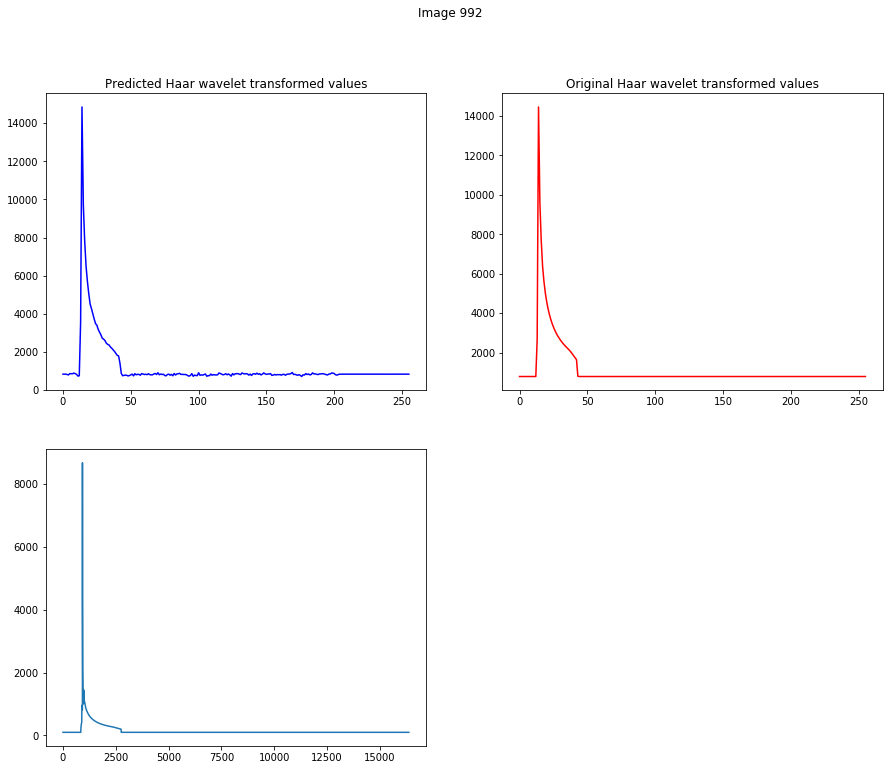

In [309]:
k=2086

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

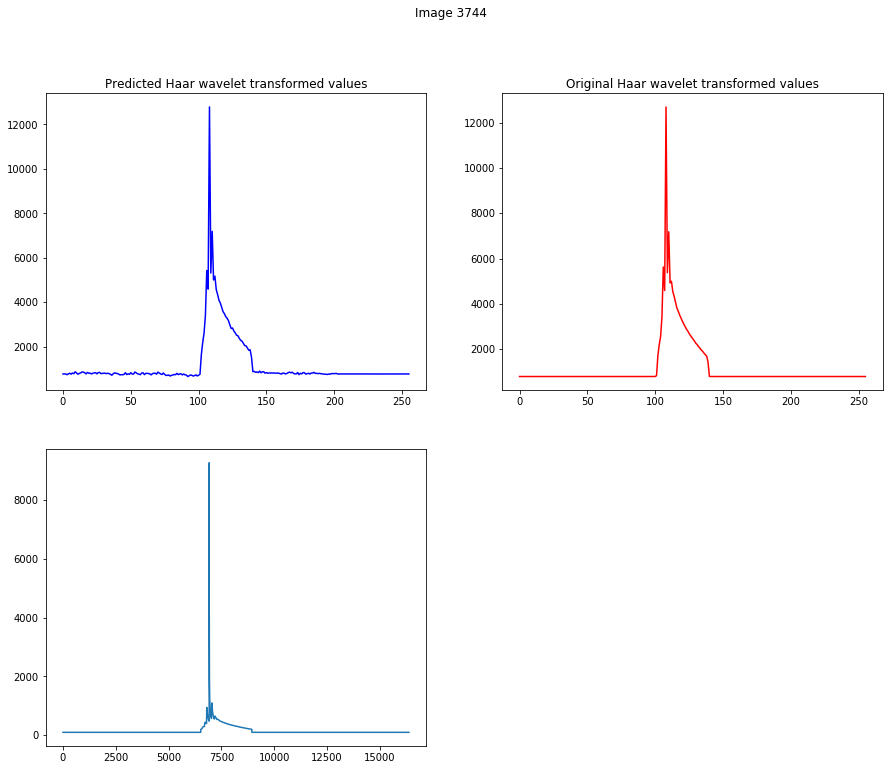

In [310]:
k=2000

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])


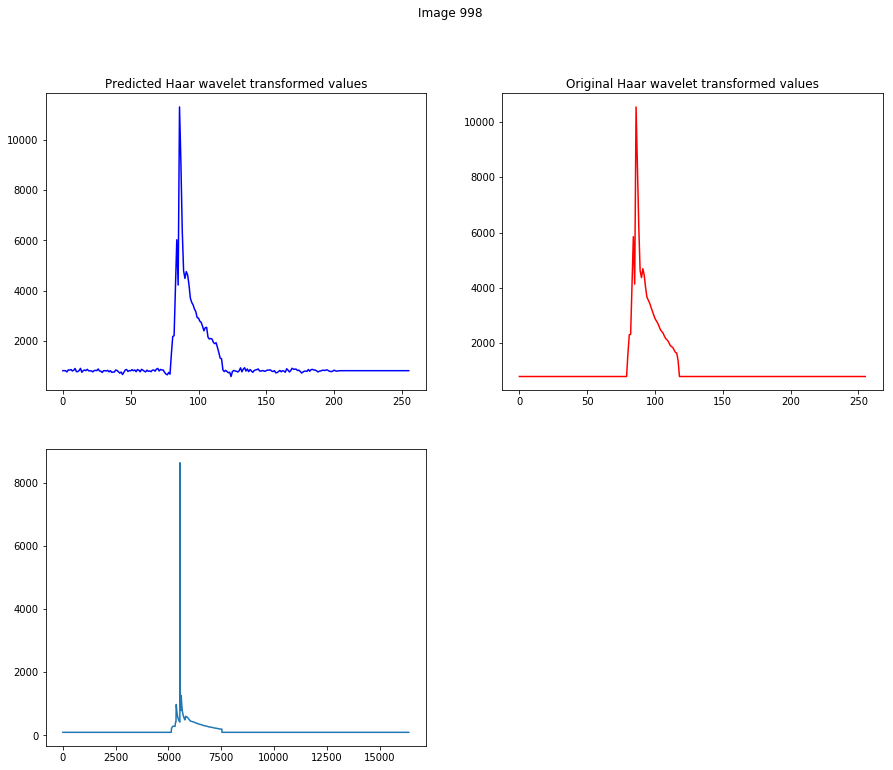

In [311]:
k=1998

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

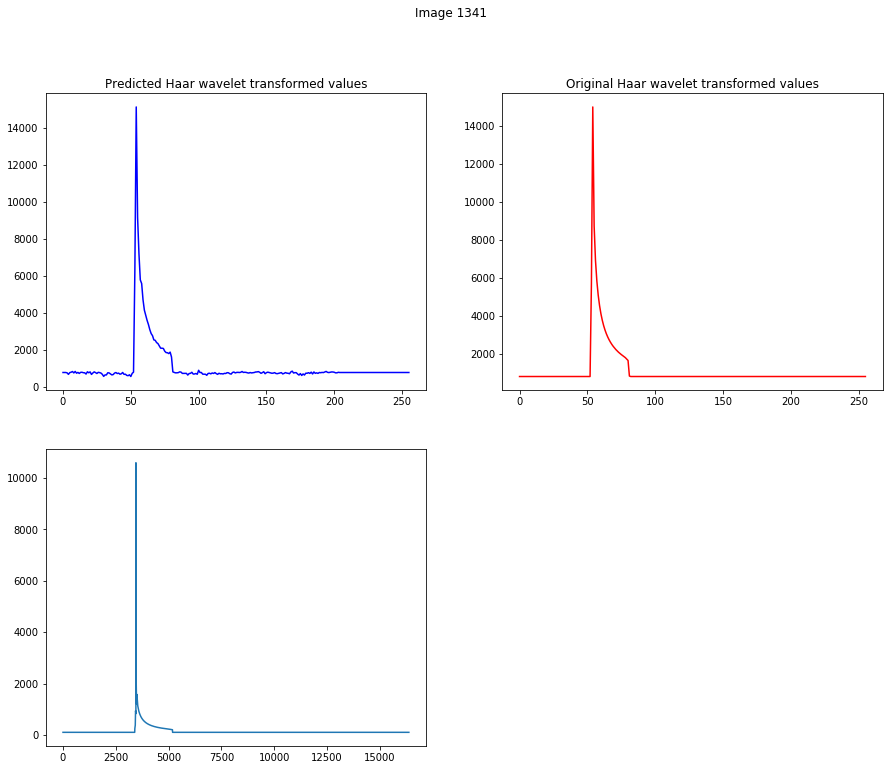

In [312]:
k=2001

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

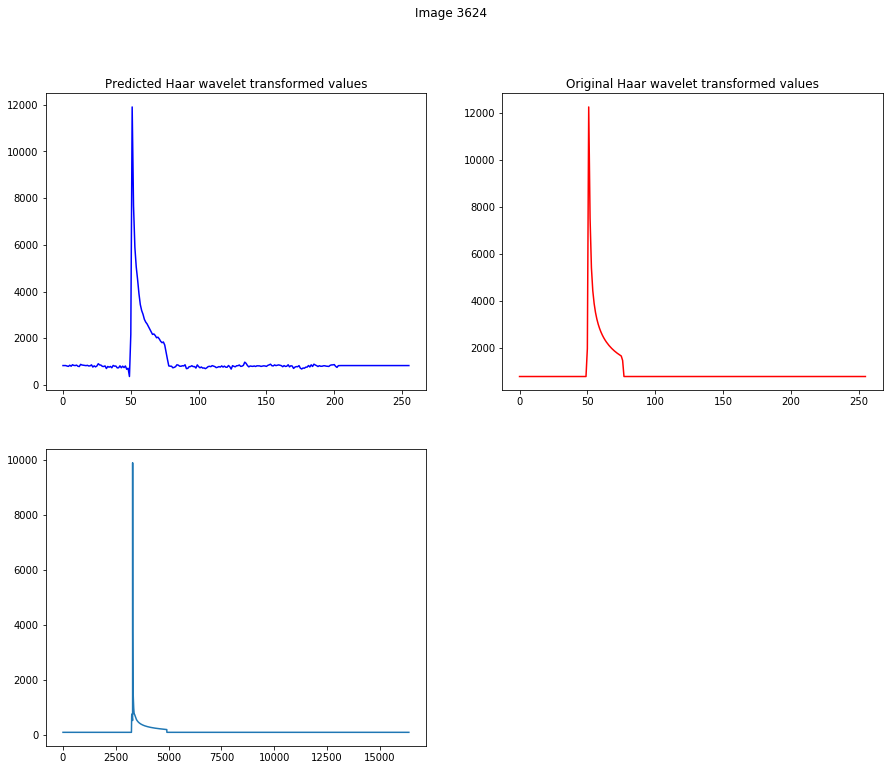

In [313]:
k=1803

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

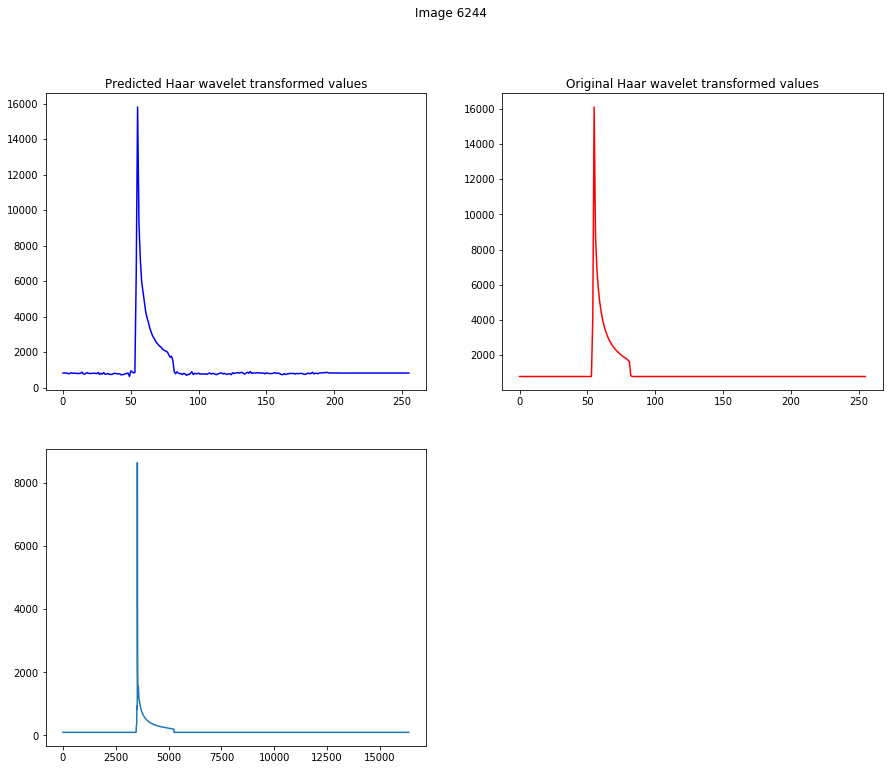

In [314]:
k=1807

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

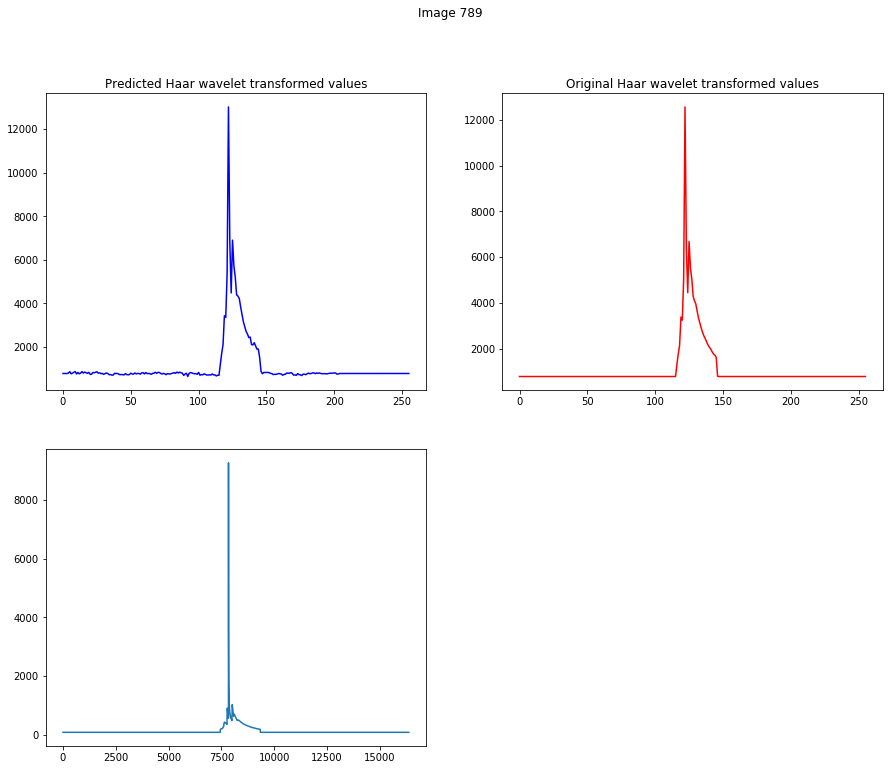

In [315]:
k=105

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

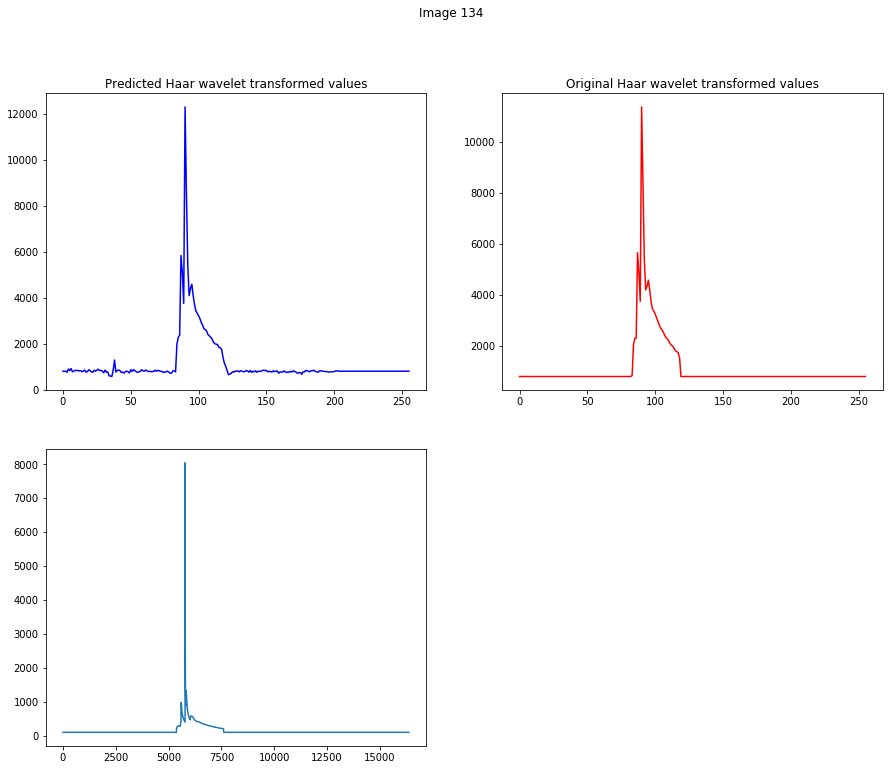

In [316]:
k=512

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

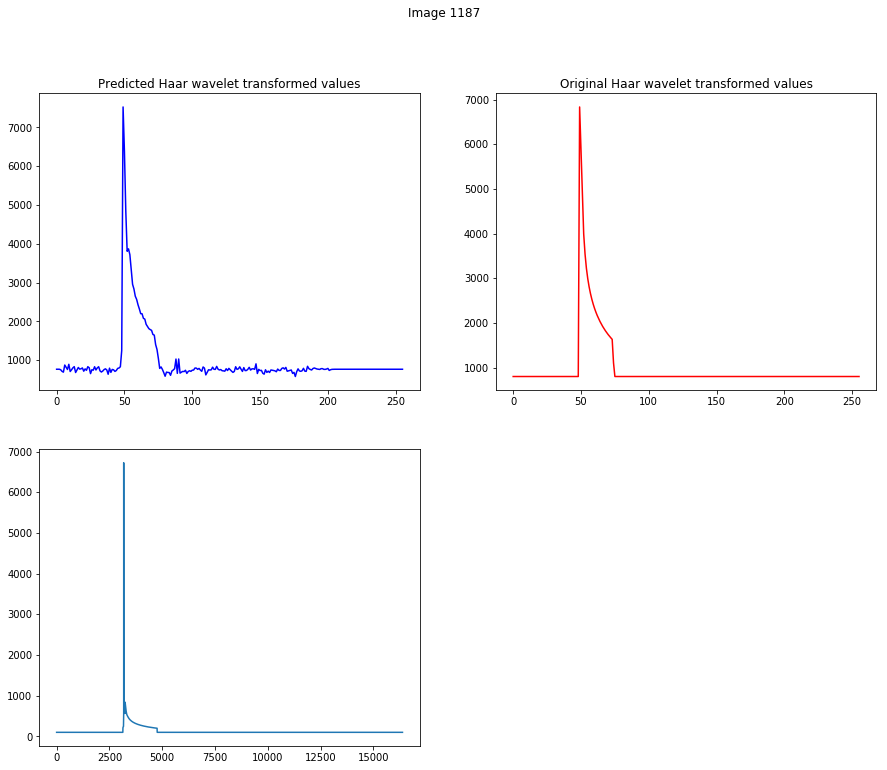

In [317]:
k=1209

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

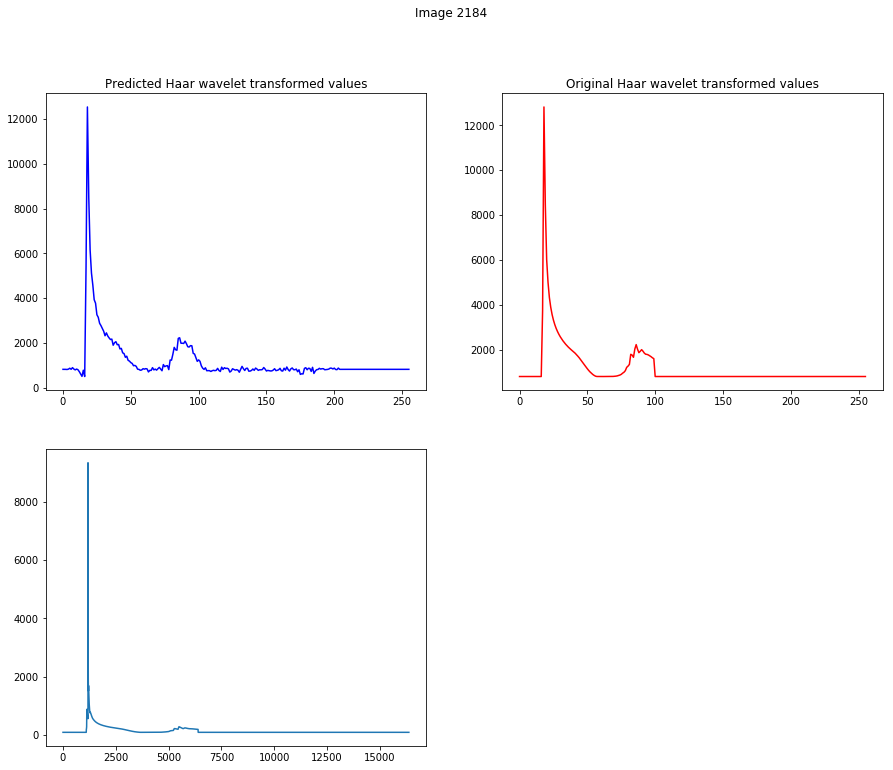

In [318]:
k=632

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

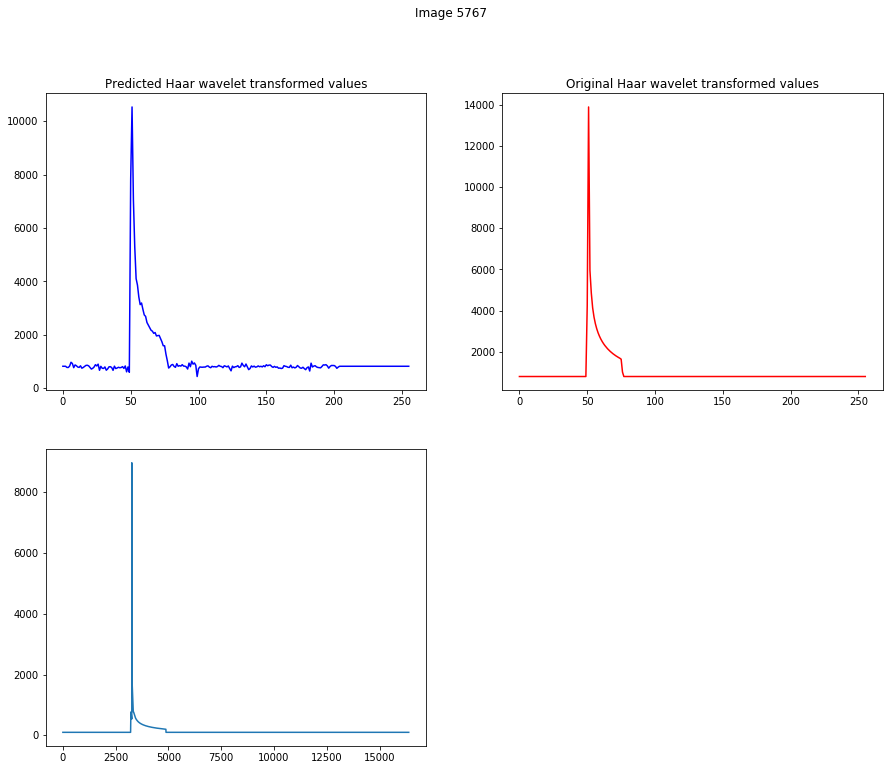

In [319]:
k=1176

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

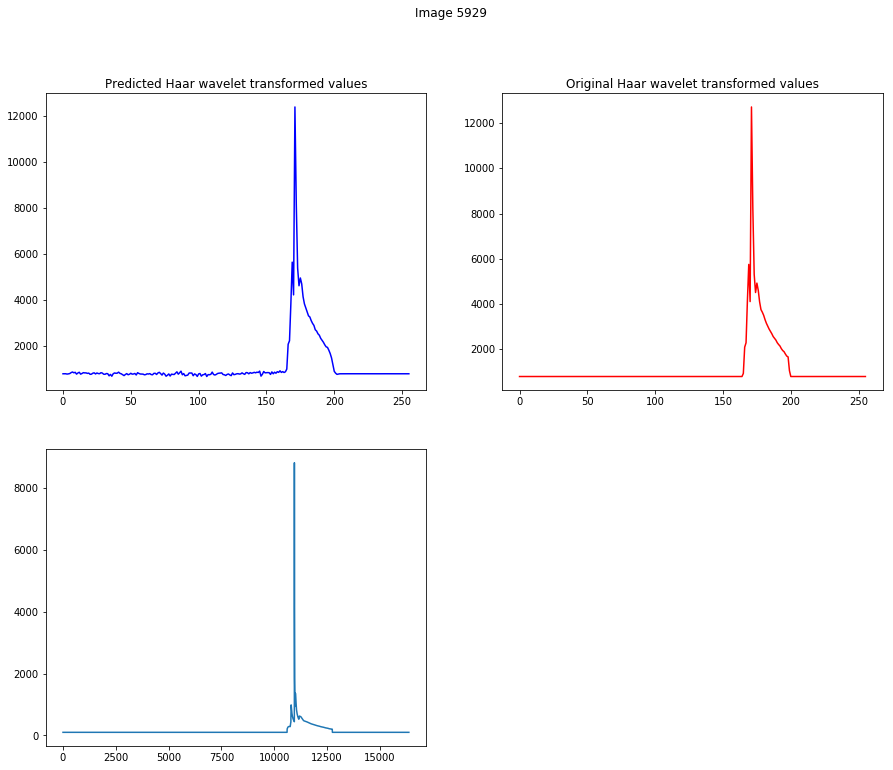

In [320]:
k=358

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

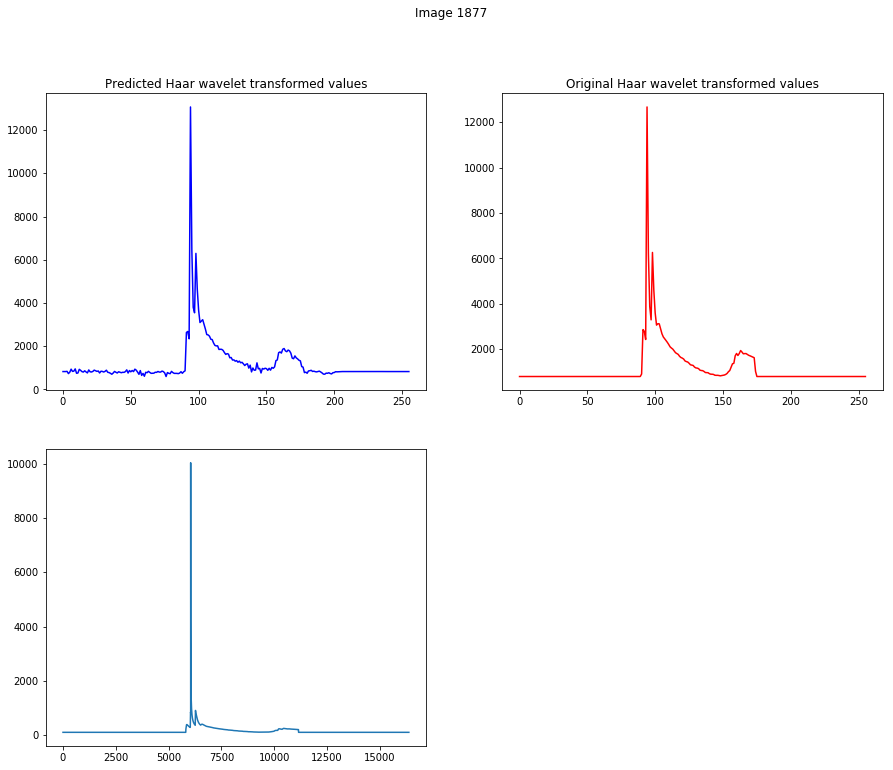

In [321]:
k=28

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

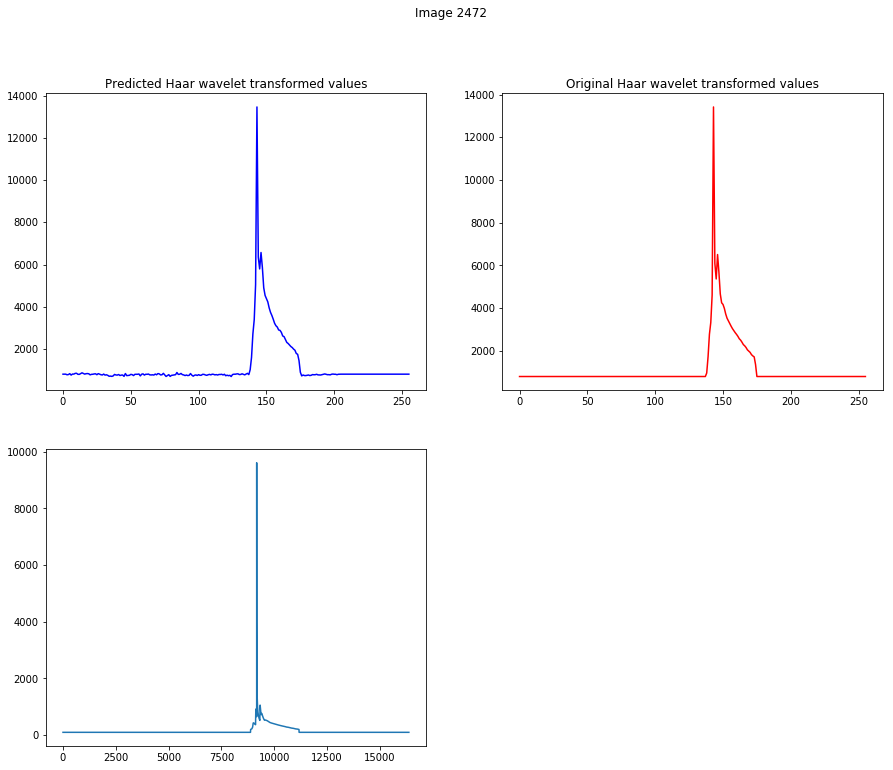

In [322]:
k=15

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

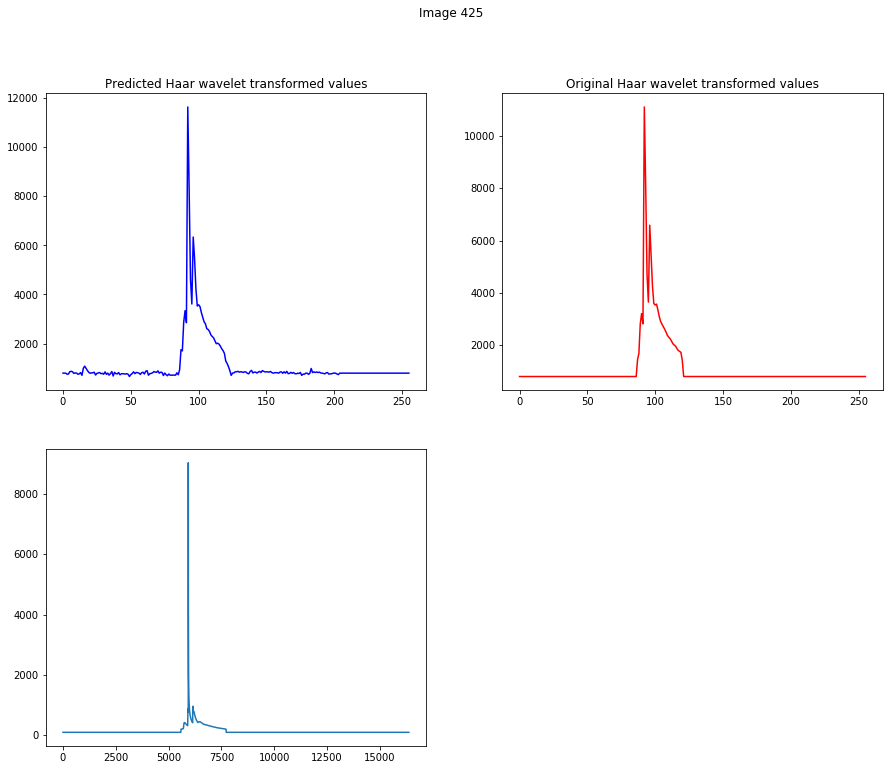

In [323]:
k=53

fig,ax = plt.subplots()


fig.set_size_inches(15,12)


fig.suptitle("Image {}".format(find_curve(y_t[k])))

plt.subplot(2,2,1)
plt.plot(y_hat[k]*n[find_curve(y_t[k])],c="b")
plt.title("Predicted Haar wavelet transformed values")

plt.subplot(2,2,2)
plt.plot(y_t[k]*n[find_curve(y_t[k])],c="r")
plt.title("Original Haar wavelet transformed values")

plt.subplot(2,2,3)
plt.plot(Y_array[find_curve(y_t[k])])

In [324]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_t,y_hat))

0.0052593714

In [70]:
### Hellinger distance
### renormalize